# EPS 109 Final Project: *Utilizing Sensor Fusion to Locate a High Altitude Balloon Payload in the Mojave Desert (or at least try to...)*

### Hunter Hall — hall@berkeley.edu
### December, 2020

# READ ME:

## 1. Due to the intrinsically large file sizes generated by the Landsat 8 satellite used to generate the final products of this project, I have taken a few procedures to decrease the notebook size.
> __1.1__ In order to save computational time, I locally saved (in the same directory as this notebook) manipulated and/or final images as I progressed through the code. This means that I only loaded in the original Landsat 8 data in __two cells in the entire notebook marked with orange text__: <font color=orange>__"Original Landsat 8 RGB Data Import (in cell below)"__</font> and <font color=orange>__"Original Landsat 8 Panchromatic Data Import (in cell below)"__</font>.
<br>

> __1.2__ For the purposes of being able to upload this notebook with a reasonable size limit, I have __NOT__ included the original Landsat 8 data I used to generate the final images. The cells that I mentioned in 1.1 require the original Landsat 8 data in order to run, so I have commented those cells out.
<br>

> __1.3__ Because of what I just mentioned in 1.1 and 1.2, I have only included the __locally saved small image files__ in the directory this notebook is in. If for some reason, the locally saved files that are supposed to be used with this notebook aren't working or didn't download properly, you can download them directly from the following Google Drive ZIP. Simply download the ZIP, unarchive it and place all of the individual files in the same directory that this notebook is currently running in *(important to note that you should not change any of the names in the actual unarchived folder, as this notebook is written to use those folder and file names)*. Link to Google Drive ZIP: https://drive.google.com/file/d/1vlynXHX7dB--Qym4JkMRE4qZ_dbGLqqB/view?usp=sharing
<br>

> __1.4__ __However__, I have uploaded all of the original Landsat 8 data I used to Google Drive as a ZIP that you can use to run the entire notebook from start to stop with original data and change the bands and colors around if you want. To get the original data, simply click the following link, download the ZIP file to the directory this folder is currently running in and double click the ZIP file to unarchive it *(important to note that you should not change any of the names in the actual unarchived folder, as this notebook is written to use those folder and file names)*. Link to Google Drive ZIP: https://drive.google.com/drive/folders/1EeUFVoKW_QHD4awEYyXRLCEK0WzUKn0_?usp=sharing

## 2. Also due to the intrinsically large file sizes, my computer (2016 Macbook Air with 8 GB of RAM) was taking a very long time to load, manipulate, and show the images when working with the original Landsat 8 data (anywhere between 20 minutes and 1.5 hours depending on the file I was using).
> __2.1__ __Because of this__ I installed *__numba's JIT__ (Just-In-Time compilation)* (https://numba.pydata.org/) to decrease computational time by enabling parallel processing and other built-in functions of __JIT__ (https://numba.readthedocs.io/en/stable/user/overview.html). Using it actually ran my Landsat data manipulation funcitons on average ~47% faster than without it.
<br>

> __2.2__ While it is not necessary to use *__numba's JIT__* to run this notebook (especially if you have a better computer than mine), __you must comment out__ the <font color=purple>__@jit__</font> statements seen before each function, as well as __commenting out__ the __"<font color=green>from</font> numba <font color=green>import</font> jit"__ statement in the __"Necessary Packages"__ cell below these instructions.
<br>

> __2.3__ __If you DO wish to use__ *__numba's JIT__* simply follow the installation instructions linked here: https://numba.readthedocs.io/en/stable/user/5minguide.html. 
<br>
*It is as simple as running one of the following in your terminal before running this notebook:*
<br>
> - __conda install numba__ (if you're using Anaconda)
<br>
> - __pip install numba__ (if you want to use wheels)

## 3. In order to run the Monte Carlo (MC) balloon flight path simulations, you must first install the ASTRA High Altitude Balloon Flight Planner. 
<font color=grey>*(Optional additional documentation, if you want more info about the planner):*</font>
- <font color=grey>*The original paper published on the planner can be found here:*</font> *https://arc.aiaa.org/doi/10.2514/1.J052900*
    - <font color=grey>*Direct link to PDF of paper (on my Google Drive) if you can't download the paper from AIAA:*</font> *https://bit.ly/34vKNPu*
- <font color=grey>*The browser-based simulator can be found here:*</font> *http://astra-planner.soton.ac.uk/*

> __3.1__ In order to install this package, simply follow the instructions listed:
<br>
> - In your terminal, navigate to the directory in which this notebook is in.
> - Next, clone the Git repo from the ASTRA Github with the follow command:
>     - __git clone https://github.com/sobester/astra_simulator.git__
<br>

> __3.2__ Once this repo has been cloned to same directory this notebook is in, you can change the parameters in the __<font color=magenta>*ASTRA balloon predictions*</font>__ cell (marked with <font color=magenta>__magenta text__</font>) to whatever balloon parameters you want. In this case, I have chosen the parameters that most accurately represent the balloon flight and payload lost on August 13, 2020.
<br>

> __3.3__ If you do not wish to use the balloon flight simulator, simply comment out everything in the __"Necessary packages for the ASTRA HAB predictor"__, as well as the __<font color=magenta>*ASTRA balloon predictions*</font>__ cells towards the bottom of the notebook (marked with <font color=magenta>__magenta text__</font>). 



# $I-$ Landsat 8 Section

# Necessary packages for Landsat 8 Section

In [2]:
### For the Landsat 8 Section ###
#-------------------------------------------------------------------------------#
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 
import numpy as np
from skimage import io
from skimage import img_as_ubyte, img_as_uint, img_as_float64
from skimage import data,exposure
from skimage.transform import rotate
from skimage.transform import rescale
from skimage.transform import resize
import time
import warnings
warnings.filterwarnings('ignore')

# Comment out the line below if you are not using JIT, as explained in Section 2.2 of the READ ME.
from numba import jit
#-------------------------------------------------------------------------------#

## 1. Low-res RGB Landsat 8 Images
### 1.1 Functions for low-res RGB images

In [2]:
### Dates when the images were taken ###
#-------------------------------------------------------------------------------#
dates = ['08_07_2020', '08_22_2020', '09_05_2020', '09_20_2020', '10_07_2020', '11_04_2020', '11_19_2020', '12_03_2020']
#-------------------------------------------------------------------------------#

In [3]:
### Array info function from class ###

# Used for quickly getting info on the output images
#-------------------------------------------------------------------------------#
@jit
def PrintArrayInfo(a):
    print("Array info:")
    print("shape:", a.shape)
    print("dtype:", a.dtype)
    print("min, max:", a.min(), a.max())
#-------------------------------------------------------------------------------#

In [4]:
### LOW-RES RGB ###

# Used to rescale the color intensities
#-------------------------------------------------------------------------------#
@jit(parallel=True)
def rescale_intensities(image,flow,fhigh):

    # Scale the intensities for each channel of an R B G image given an upper
    # and lower percentaile and return the re-scaled image.

    red = image[:,:,0]
    green = image[:,:,1]
    blue = image[:,:,2]

    mask = ( red + green + blue ) > 0

    # Pick percentile overwhich to rescale intensities
    #flow = 2
    #fhigh = 98

    plow, phigh = np.percentile(red[mask], (flow, fhigh))
    ls_red_rs= exposure.rescale_intensity(red, in_range=(plow, phigh))

    plow, phigh = np.percentile(green[mask], (flow, fhigh))
    ls_green_rs= exposure.rescale_intensity(green, in_range=(plow, phigh))

    plow, phigh = np.percentile(blue[mask], (flow, fhigh))
    ls_blue_rs= exposure.rescale_intensity(blue, in_range=(plow, phigh))

    # Define empty image
    nx,ny = ls_red_rs.shape
    ls_rgb_stretched = np.zeros([nx,ny,3],dtype=np.float64)

    # set all 3 channels of the image
    ls_rgb_stretched[:,:,0] = ls_red_rs
    ls_rgb_stretched[:,:,1] = ls_green_rs
    ls_rgb_stretched[:,:,2] = ls_blue_rs

    return  ls_rgb_stretched
#-------------------------------------------------------------------------------#

In [5]:
### LOW-RES RGB ###

# Used to load in, rotate, and scale a single Landsat8 image with three color bands
#-------------------------------------------------------------------------------#
@jit(parallel=True)
def prepare_landsat_image_single_updated(date, bands, flow, fhigh, left, top, window_size):
    
    # date: date of Landsat8 image taken in the following format: mm_dd_yyyy
    # bands: which three bands you want to input for the R,G,B channels in the following format: 
            # bands = [first band number, second band number, third band number]
    # angle: the angle offset you want to apply to the raw image in the following format: 
            # positive values are CCW, negatives are CW 
    # flow: the lower intensity cutoff for the color channels
    # fhigh: the upper intensity cutoff for the color channels
    # square_window_size: the pixel length of one of the sides of the square search window
    # window_center: the pixel coordinates of the center of the search window in the following format:
            # window_center = [y,x] 
    

    # prepare a false color image for a combination of 3 landsat bands
    # Note this is specific to the set of images we provided, and the
    # hardcoded values for rotating need to be changed if you download a new
    # set of landsat images.
    
    # Modifying

    ls_red = io.imread('landsat8/'+str(date)+'/B'+str(bands[0])+'.tif') # red
    ls_green = io.imread('landsat8/'+str(date)+'/B'+str(bands[1])+'.tif') # green
    ls_blue = io.imread('landsat8/'+str(date)+'/B'+str(bands[2])+'.tif') # blue

    ls_red = img_as_float64(ls_red)
    ls_green = img_as_float64(ls_green)
    ls_blue = img_as_float64(ls_blue)

    nx,ny = ls_red.shape
    ls_false = np.zeros([nx,ny,3],dtype=np.float64)

    ls_false[:,:,0] = ls_red
    ls_false[:,:,1] = ls_green
    ls_false[:,:,2] = ls_blue

    
    
    #flow = 2
    #fhigh = 98

    ls_false_rescale = rescale_intensities(ls_false,flow,fhigh)
#     left = 3000+150
    right = left + window_size

#     top = 1500
    bottom = top + window_size

    ls_false_rescale = ls_false_rescale[top:bottom,left:right]
    
    return ls_false_rescale
#-------------------------------------------------------------------------------#

#### 1.1.1 Computing performance: Comparing numba's JIT with standard processing
##### *Deciding whether or not to use  for this project...*

In [6]:
# ### Without JIT ###

#-------------------------------------------------------------------------------#
# #bands = [4,3,2] # Natural Color 

# date1 = '08_07_2020'
#----------------------------------------------------#

# # DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
# start = time.time()
# ls_1_new = prepare_landsat_image_single_updated(date1, bands, 2, 98, 3000, 1500, 200)
# end = time.time()
# print("Elapsed (with compilation) = %s" % (end - start))

# # NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
# start = time.time()
# ls_1_new = prepare_landsat_image_single_updated(date1, bands, 2, 98, 3000, 1500, 200)
# end = time.time()
# print("Elapsed (after compilation) = %s" % (end - start))

#----------------------------------------------------#

# # Results in seconds:

# # Elapsed (with compilation) = 54.9093382358551
# # Elapsed (after compilation) = 47.23549270629883
#-------------------------------------------------------------------------------#

#### Without JIT computational results running the low-res RGB Landsat 8 image prep function:

- Elapsed (with compilation) = 54.9093382358551 seconds
- Elapsed (after compilation) = 47.23549270629883 seconds

In [7]:
# ### With JIT ###

#-------------------------------------------------------------------------------#
# #bands = [4,3,2] # Natural Color 

# date1 = '08_07_2020'
#----------------------------------------------------#

# # DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
# start = time.time()
# ls_1_new = prepare_landsat_image_single_updated(date1, bands, 2, 98, 3000, 1500, 200)
# end = time.time()
# print("Elapsed (with compilation) = %s" % (end - start))

# # NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
# start = time.time()
# ls_1_new = prepare_landsat_image_single_updated(date1, bands, 2, 98, 3000, 1500, 200)
# end = time.time()
# print("Elapsed (after compilation) = %s" % (end - start))

#----------------------------------------------------#

# # Results in seconds:

# # Elapsed (with compilation) = 25.53570795059204
# # Elapsed (after compilation) = 22.98537588119507
#-------------------------------------------------------------------------------#

#### With JIT computational results running the low-res RGB Landsat 8 image prep function:

- Elapsed (with compilation) = 25.53570795059204 seconds
- Elapsed (after compilation) = 22.98537588119507 seconds

#### Conclusion: DEFINITELY using JIT for all of the large TIFF file manipulation in this project.
- __Elapsed (with compilation) = 46.5% faster__
- __Elapsed (after compilation) = 48.6% faster__

### 1.2 Generating the low-res versions of the Landsat 8 images of the ~ 2x2 km search area

# <font color=orange>Original Landsat 8 RGB Data Import (in cell below)</font>

In [8]:
# ### LOW-RES RGB ###

# # This cell is used to choose the best bands for each image, align each image's window to match the others, and finally save the desired images locally as npz's so that we don't have to use the full sized Landsat frames every time.
# # Once the desired images are saved locally, this entire cell can be commented out.

# #-------------------------------------------------------------------------------#
# bands_natural = [4,3,2] # Natural Color 
# bands_urban = [7,6,4] # False Color (Urban)
# bands_c_IR = [5,4,3] # Color infrared (Vegetation)
# bands_ag = [6,5,2] # Agriculture
# bands_atm_pen = [7,6,5] # Atmospheric Penetration
# bands_h_veg = [5,6,2] # Healthy Vegetation
# bands_land_water = [5,6,2] # Land/Water
# bands_geology = [7,6,2] # Geological boundaries and features
# bands_natural_no_atm = [7,5,3] # Natural with Atmospheric Removal
# bands_sw_IR = [7,5,4] # Shortwave Infrared
# bands_veg_anal = [6,5,4] # Vegetation Analysis
# bands_lw_IR_1 = [6,4,11] # LW infrared 1
# bands_lw_IR_2 = [6,4,10] # LW infrared 2
# bands_atm_cirus = [7,9,3] # Cirus cloud penatration
# bands_lw_IR_1_no_atm = [7,5,11] #LW infrared 1 without atm
# #----------------------------------------------------#

# # date0 = '08_07_2020'
# # date1 = '08_22_2020'
# # date2 = '09_05_2020'
# # date3 = '09_20_2020'
# # date4 = '10_07_2020'
# # date5 = '11_04_2020'
# # date6 = '11_19_2020'
# # date7 = '12_03_2020'

# dates = ['08_07_2020', '08_22_2020', '09_05_2020', '09_20_2020', '10_07_2020', '11_04_2020', '11_19_2020', '12_03_2020']

# #----------------------------------------------------#

# ls_0_new = prepare_landsat_image_single_updated(dates[0], bands_lw_IR_1, 10, 99.9, 3165+50, 1525+50, 100)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# #plt.axis('off')
# plt.imshow(ls_0_new)
# plt.title(dates[0])
# plt.show()
# PrintArrayInfo(ls_0_new)

# #np.savez('ls_0_lw', ls_0_new)

# #----------------------------------------------------#

# ls_1_new = prepare_landsat_image_single_updated(dates[1], bands_natural_no_atm, 10, 99.9, 3165+50, 1525+50, 100)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# #plt.axis('off')
# plt.imshow(ls_1_new)
# plt.title(dates[1])
# plt.show()
# PrintArrayInfo(ls_1_new)

# #np.savez('ls_1_lw', ls_1_new)

# #----------------------------------------------------#

# ls_2_new = prepare_landsat_image_single_updated(dates[2], bands_lw_IR_1, 10, 99.9, 3165+50+10, 1525+50, 100)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# #plt.axis('off')
# plt.imshow(ls_2_new)
# plt.title(dates[2])
# plt.show()
# PrintArrayInfo(ls_2_new)

# #np.savez('ls_2_lw', ls_2_new)

# #----------------------------------------------------#

# ls_3_new = prepare_landsat_image_single_updated(dates[3], bands_lw_IR_1, 10, 99.9, 3165+50+40, 1525+50, 100)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# #plt.axis('off')
# plt.imshow(ls_3_new)
# plt.title(dates[3])
# plt.show()
# PrintArrayInfo(ls_3_new)

# #np.savez('ls_3_lw', ls_3_new)

# #----------------------------------------------------#

# ls_4_new = prepare_landsat_image_single_updated(dates[4], bands_lw_IR_1, 10, 99.9, 3165+50+50, 1525+50, 100)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# #plt.axis('off')
# plt.imshow(ls_4_new)
# plt.title(dates[4])
# plt.show()
# PrintArrayInfo(ls_4_new)

# #np.savez('ls_4_lw', ls_4_new)

# #----------------------------------------------------#

# ls_5_new = prepare_landsat_image_single_updated(dates[5], bands_natural_no_atm, 10, 99.9, 3165+50+40, 1525+50, 100)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# #plt.axis('off')
# plt.imshow(ls_5_new)
# plt.title(dates[5])
# plt.show()
# PrintArrayInfo(ls_5_new)

# #np.savez('ls_5_lw', ls_5_new)

# #----------------------------------------------------#

# ls_6_new = prepare_landsat_image_single_updated(dates[6], bands_lw_IR_1, 10, 99.9, 3165+50, 1525+50, 100)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# #plt.axis('off')
# plt.imshow(ls_6_new)
# plt.title(dates[6])
# plt.show()
# PrintArrayInfo(ls_6_new)

# #np.savez('ls_6_lw', ls_6_new)

# #----------------------------------------------------#

# ls_7_new = prepare_landsat_image_single_updated(dates[7], bands_lw_IR_1, 10, 99.9, 3165+70+60-20, 1525+50, 100)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# #plt.axis('off')
# plt.imshow(ls_7_new)
# plt.title(dates[7])
# plt.show()
# PrintArrayInfo(ls_7_new)

# #np.savez('ls_7_lw', ls_7_new)

# #----------------------------------------------------#


#### 1.2.1 Loading in the locally saved low-res RGB images

In [9]:
### LOW-RES RGB ###

# Load in the locally saved low-res images
#-------------------------------------------------------------------------------#
ls_0_lw = np.load('ls_0_lw'+'.npz')
ls_0_lw = ls_0_lw['arr_0']

ls_1_lw = np.load('ls_1_lw'+'.npz')
ls_1_lw = ls_1_lw['arr_0']

ls_2_lw = np.load('ls_2_lw'+'.npz')
ls_2_lw = ls_2_lw['arr_0']

ls_3_lw = np.load('ls_3_lw'+'.npz')
ls_3_lw = ls_3_lw['arr_0']

ls_4_lw = np.load('ls_4_lw'+'.npz')
ls_4_lw = ls_4_lw['arr_0']

ls_5_lw = np.load('ls_5_lw'+'.npz')
ls_5_lw = ls_5_lw['arr_0']

ls_6_lw = np.load('ls_6_lw'+'.npz')
ls_6_lw = ls_6_lw['arr_0']

ls_7_lw = np.load('ls_7_lw'+'.npz')
ls_7_lw = ls_7_lw['arr_0']
#-------------------------------------------------------------------------------#

#### 1.2.2 Plotting the locally saved low-res RGB images

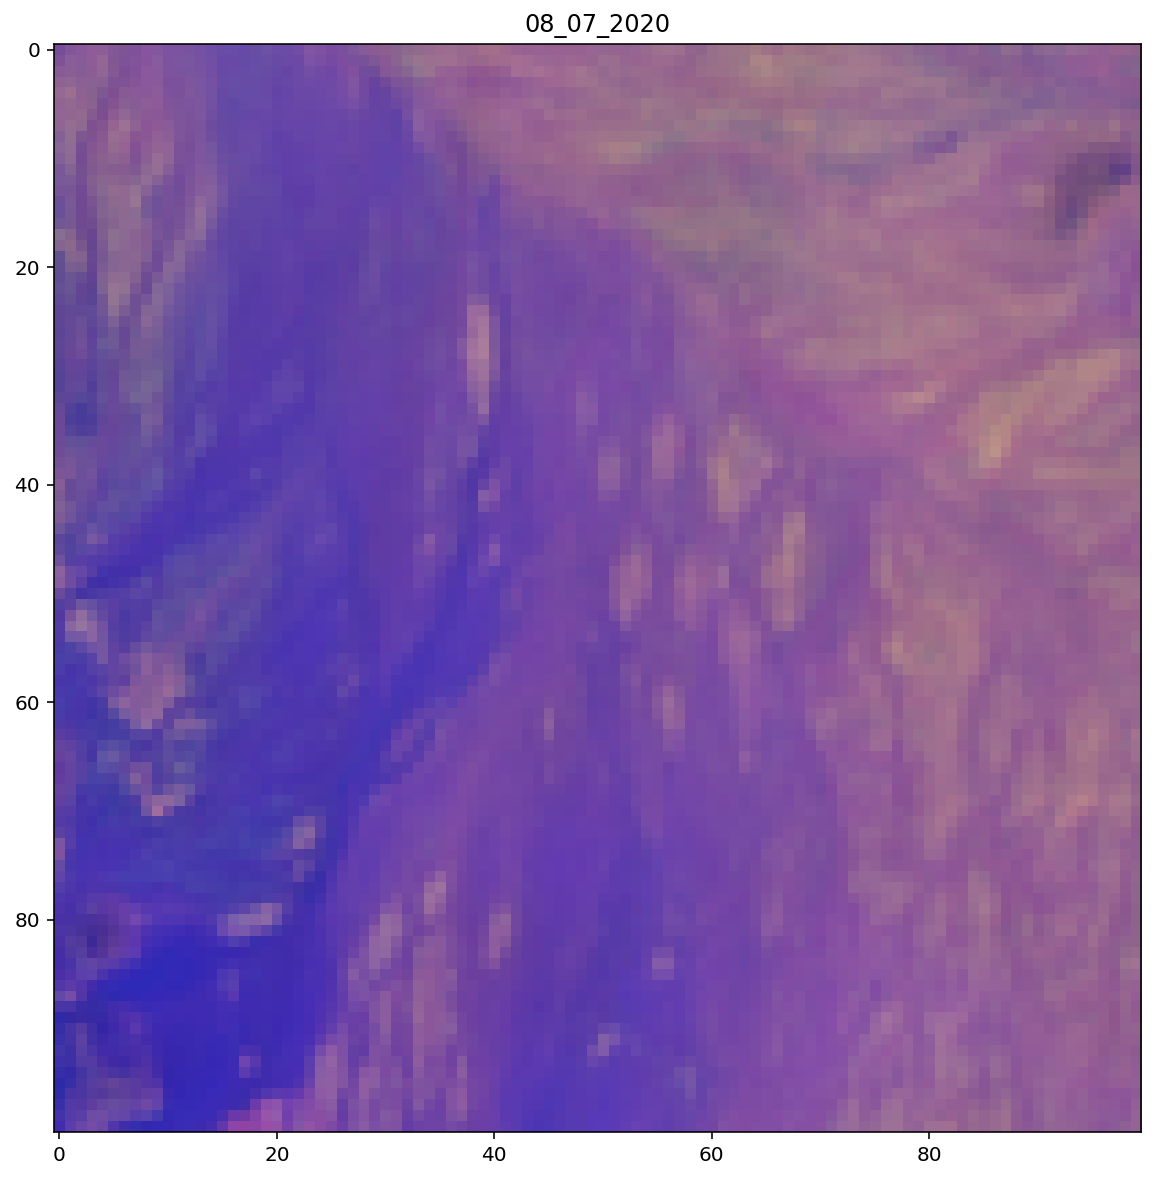

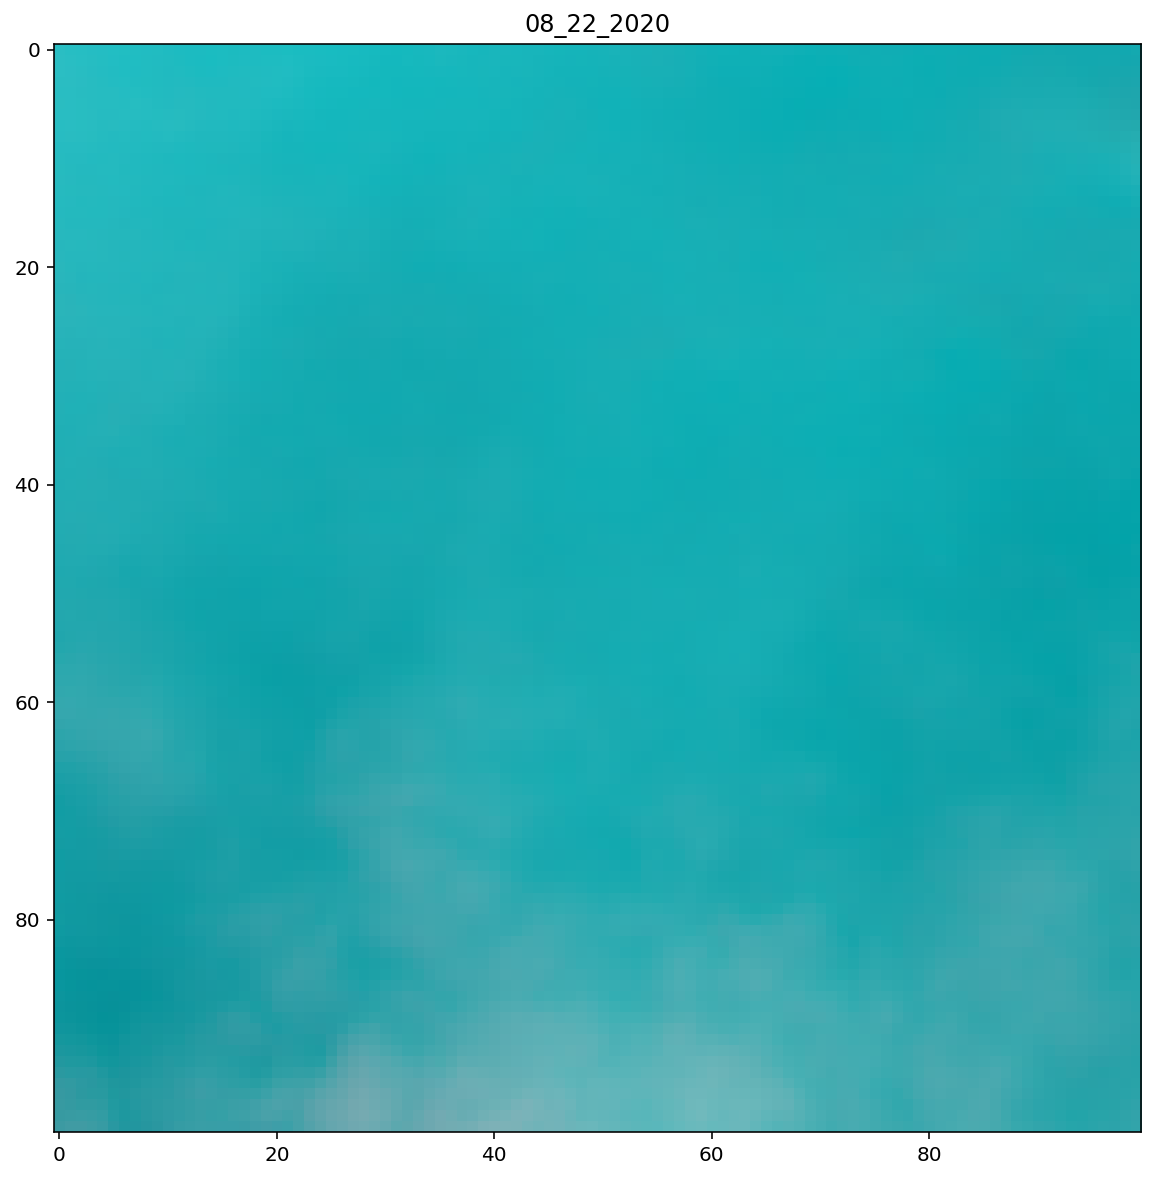

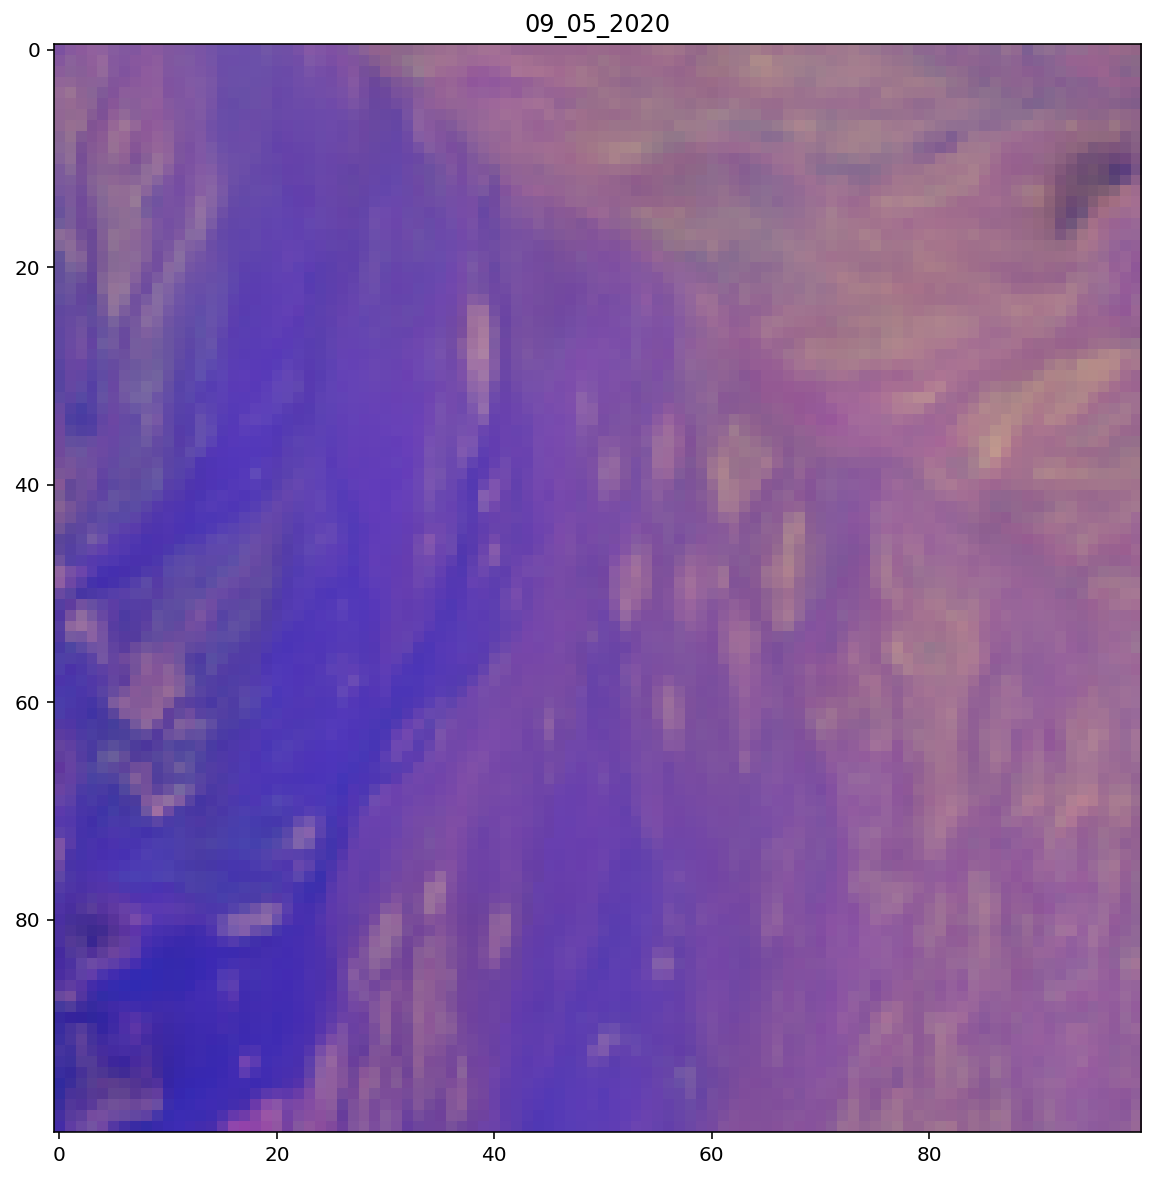

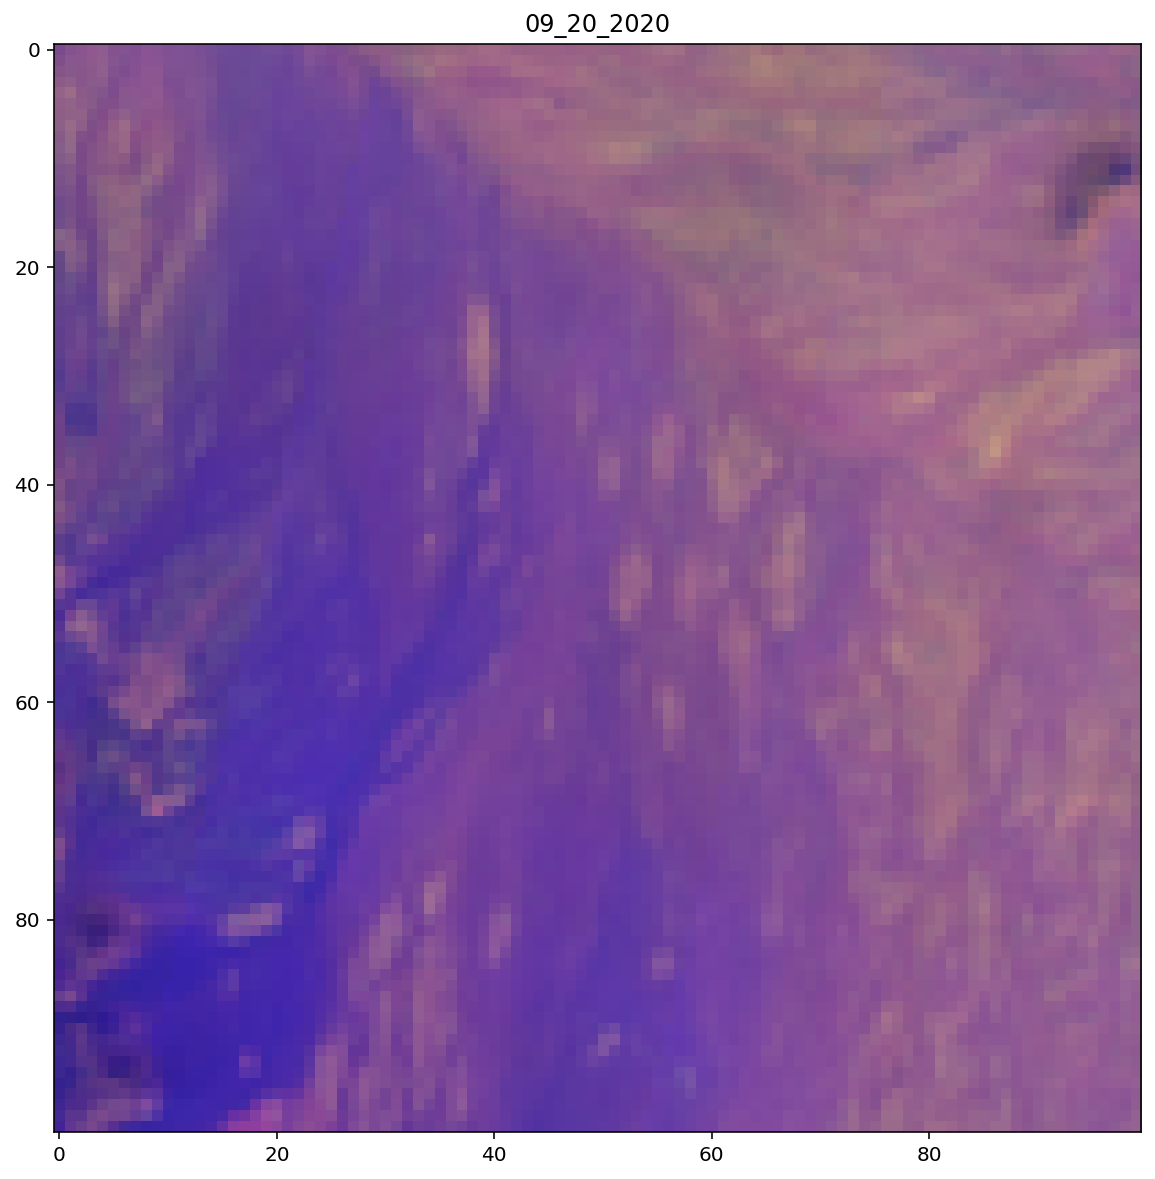

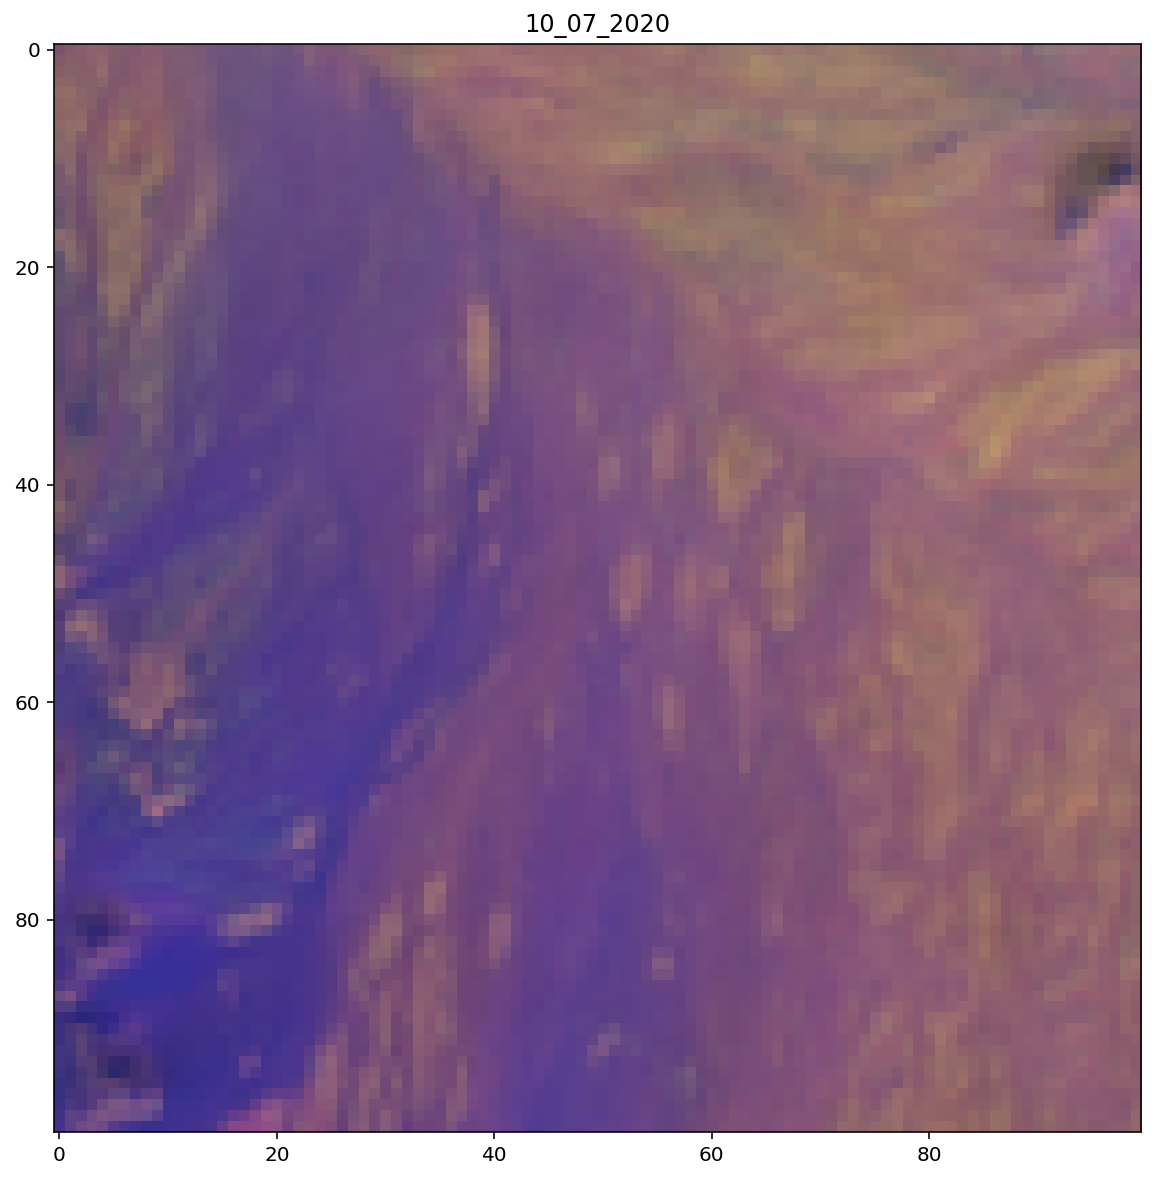

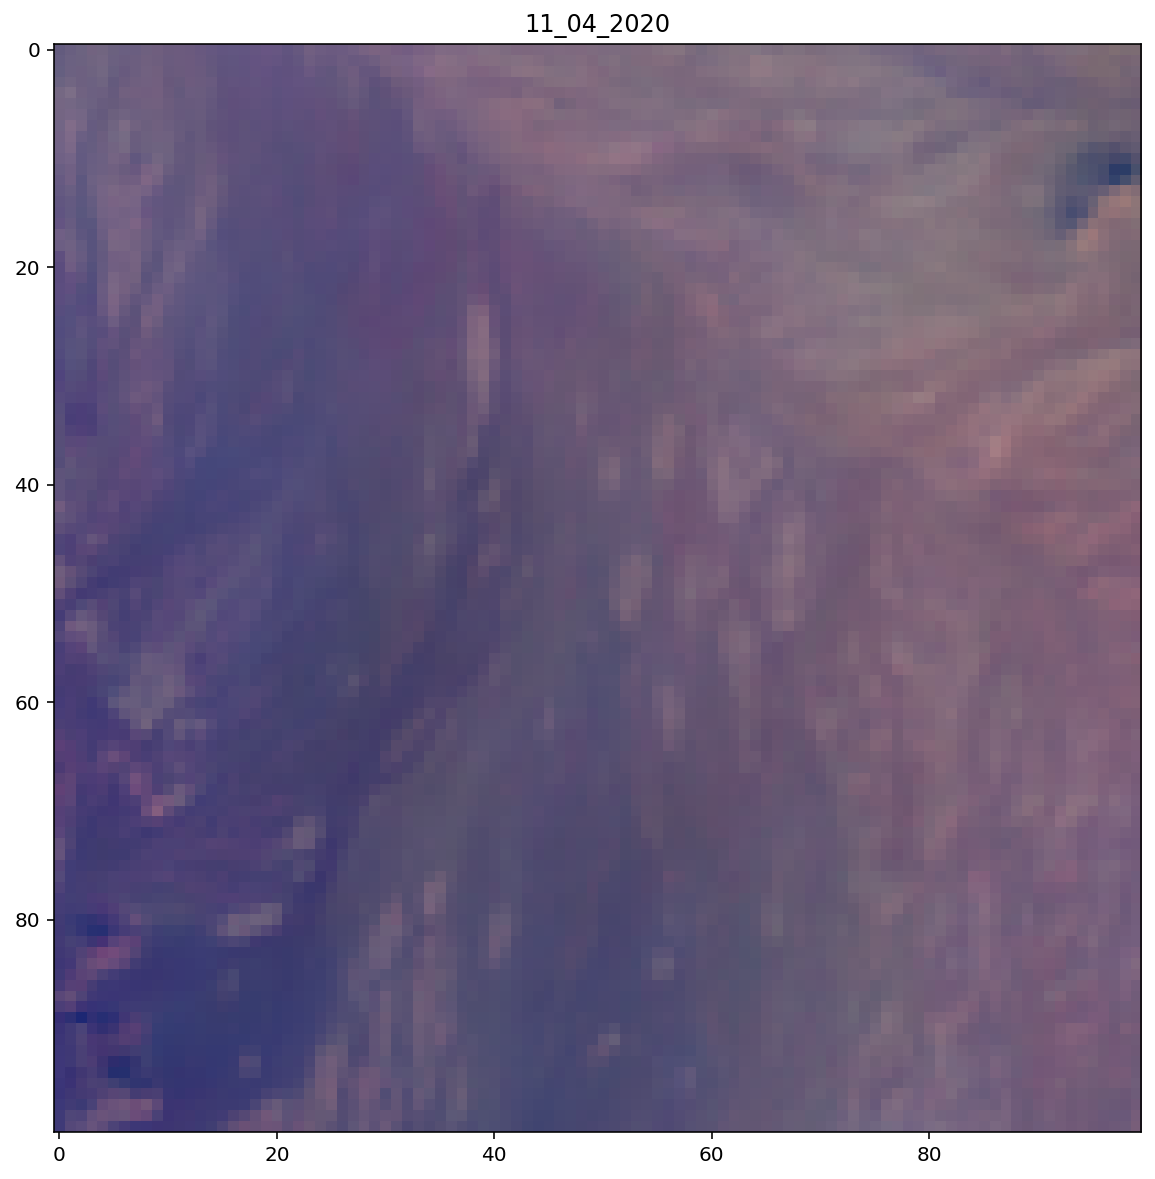

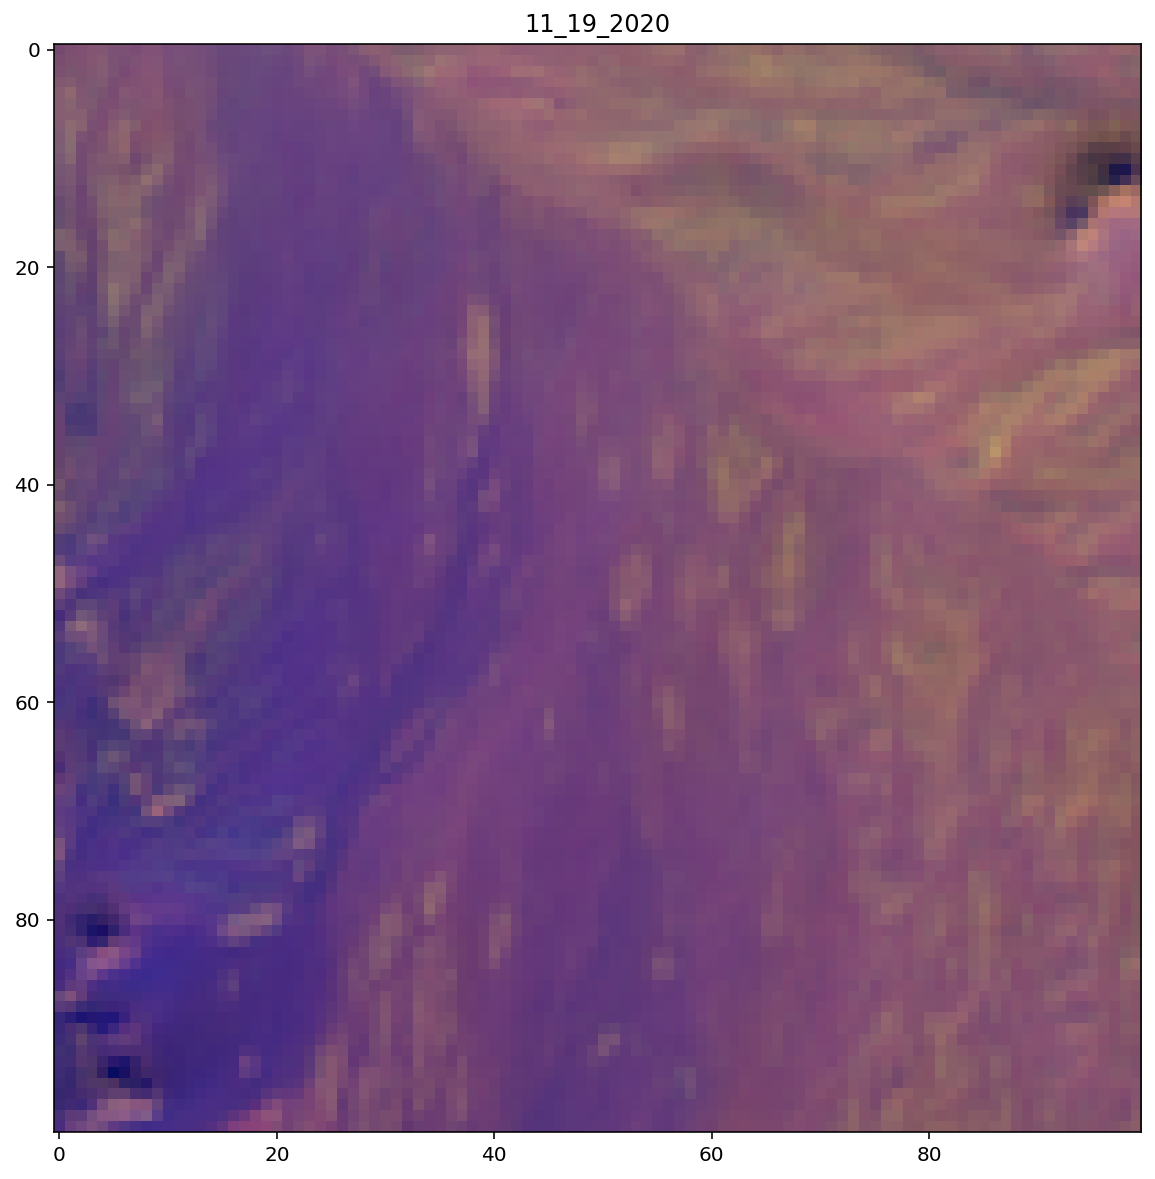

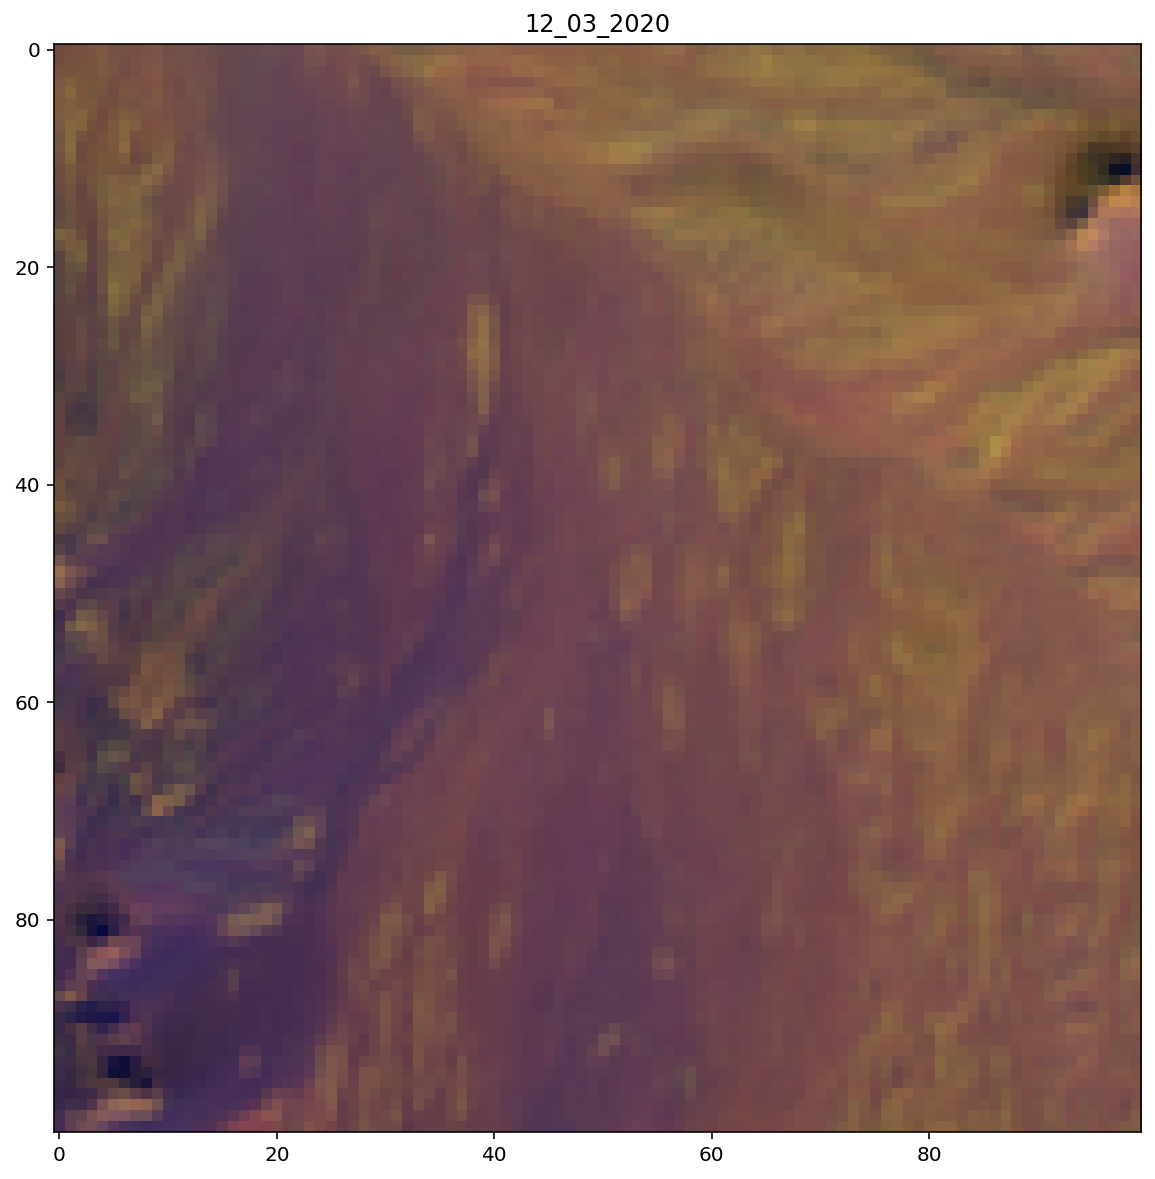

In [10]:
### LOW-RES RGB ###

# Plotting the locally saved low-res images to test them
# This cell can be commented out if the locally saved images plotted correctly after running this cell, as this is just a way to visually confirm the correct image adjustments.
#-------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_0_lw)
plt.title(dates[0])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_1_lw)
plt.title(dates[1])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_2_lw)
plt.title(dates[2])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_3_lw)
plt.title(dates[3])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_4_lw)
plt.title(dates[4])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_5_lw)
plt.title(dates[5])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_6_lw)
plt.title(dates[6])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_7_lw)
plt.title(dates[7])
plt.show()
#-------------------------------------------------------------------------------#

## 2. Panchromatic Landsat 8 Images
### 2.1 Functions for panchromatic images 

In [11]:
### PAN ###

# Used to rescale the color intensities
#-------------------------------------------------------------------------------#
@jit(parallel=True)
def rescale_intensities_individual(image):

    # Scale the intensities for each channel of an R B G image given an upper
    # and lower percentaile and return the re-scaled image.

    red = image[:,:,0]
    green = image[:,:,1]
    blue = image[:,:,2]

    mask = ( red + green + blue ) > 0

    # Pick percentile overwhich to rescale intensities
    flow_red = 10
    fhigh_red = 100
    
    flow_green = 10
    fhigh_green = 100
    
    flow_blue = 10
    fhigh_blue = 100

    plow_red, phigh_red = np.percentile(red[mask], (flow_red, fhigh_red))
    ls_red_rs= exposure.rescale_intensity(red, in_range=(plow_red, phigh_red))

    plow_green, phigh_green = np.percentile(green[mask], (flow_green, fhigh_green))
    ls_green_rs= exposure.rescale_intensity(green, in_range=(plow_green, phigh_green))

    plow_blue, phigh_blue = np.percentile(blue[mask], (flow_blue, fhigh_blue))
    ls_blue_rs= exposure.rescale_intensity(blue, in_range=(plow_blue, phigh_blue))

    # Define empty image
    nx,ny = ls_red_rs.shape
    ls_rgb_stretched_new = np.zeros([nx,ny,3],dtype=np.float64)

    # set all 3 channels of the image
    ls_rgb_stretched_new[:,:,0] = ls_red_rs
    ls_rgb_stretched_new[:,:,1] = ls_green_rs
    ls_rgb_stretched_new[:,:,2] = ls_blue_rs

    return  ls_rgb_stretched_new
#-------------------------------------------------------------------------------#

In [12]:
### PAN ###

# Used to load in the panchromatic large Landsat 8 images - in order to reduce file sizes, I cropped the panchromatic band 8 in Preview to a smaller window and renamed the new TIF as B12 - band 12 - in the Landsat 8 directories
#-------------------------------------------------------------------------------#
@jit(parallel=True)
def prepare_landsat_image_large(date, bands, left, top, window_size):

    # prepare a false color image for a combination of 3 landsat bands
    # Note this is specific to the set of images we provided, and the
    # hardcoded values for rotating need to be changed if you download a new
    # set of landsat images.
    
    # Modifying

    ls_red = io.imread('landsat8/'+str(date)+'/B'+str(bands[0])+'.tif') # red
    ls_green = io.imread('landsat8/'+str(date)+'/B'+str(bands[0])+'.tif') # green
    ls_blue = io.imread('landsat8/'+str(date)+'/B'+str(bands[0])+'.tif') # blue

    ls_red = img_as_float64(ls_red)
    ls_green = img_as_float64(ls_green)
    ls_blue = img_as_float64(ls_blue)

    nx,ny = ls_red.shape
    ls_false = np.zeros([nx,ny,3],dtype=np.float64)

    ls_false[:,:,0] = ls_red
    ls_false[:,:,1] = ls_green
    ls_false[:,:,2] = ls_blue

    #flow = 2
    #fhigh = 98

    ls_false_rescale = rescale_intensities_individual(ls_false)


#     left = 6300
    right = left + window_size

# #     top = 3000
    bottom = top + window_size

    ls_false_rescale = ls_false_rescale[top:bottom,left:right]

    return ls_false_rescale
#-------------------------------------------------------------------------------#

### 2.2 Generating the panchromatic Landsat 8 images of the ~ 2x2 km search area

# <font color=orange>Original Landsat 8 Panchromatic Data Import (in cell below)</font> 

In [13]:
# ## PAN ###

# ### This cell is used to align load in, align, and locally save the panchromatic images from each Landsat 8 dataset
# ### Once the desired images are saved locally, this entire cell can be commented out.

# #-------------------------------------------------------------------------------#
# bands_pan = [12] # Panchromatic
# #----------------------------------------------------#

# # date0 = '08_07_2020'
# # date1 = '08_22_2020'
# # date2 = '09_05_2020'
# # date3 = '09_20_2020'
# # date4 = '10_07_2020'
# # date5 = '11_04_2020'
# # date6 = '11_19_2020'
# # date7 = '12_03_2020'

# dates = ['08_07_2020', '08_22_2020', '09_05_2020', '09_20_2020', '10_07_2020', '11_04_2020', '11_19_2020', '12_03_2020']

# #----------------------------------------------------#

# ls_0_large = prepare_landsat_image_large(dates[0], bands_pan, 525, 390, 200)
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# #plt.axis('off')
# plt.imshow(ls_0_large)
# plt.title(dates[0])
# plt.show()
# PrintArrayInfo(ls_0_large)

# #np.savez('ls_0_large', ls_0_large)

# #----------------------------------------------------#

# ## Skipping this image, because too much cloud cover

# # ls_1_large = prepare_landsat_image_large(dates[1], bands_pan, 525, 390, 200)

# # fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# # #plt.axis('off')
# # plt.imshow(ls_1_large)
# # plt.title(dates[1])
# # plt.show()
# # PrintArrayInfo(ls_1_large)

# # np.savez('ls_1_large', ls_1_large)

# #----------------------------------------------------#

# ls_2_large = prepare_landsat_image_large(dates[2], bands_pan, 505, 170, 200)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# #plt.axis('off')
# plt.imshow(ls_2_large)
# plt.title(dates[2])
# plt.show()
# PrintArrayInfo(ls_2_large)

# #np.savez('ls_2_large', ls_2_large)

# #----------------------------------------------------#

# ls_3_large = prepare_landsat_image_large(dates[3], bands_pan, 805-4, 265+3, 200)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# #plt.axis('off')
# plt.imshow(ls_3_large)
# plt.title(dates[3])
# plt.show()
# PrintArrayInfo(ls_3_large)

# #np.savez('ls_3_large', ls_3_large)

# #----------------------------------------------------#

# ls_4_large = prepare_landsat_image_large(dates[4], bands_pan, 797-4, 265+1, 200)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# #plt.axis('off')
# plt.imshow(ls_4_large)
# plt.title(dates[4])
# plt.show()
# PrintArrayInfo(ls_4_large)

# #np.savez('ls_4_large', ls_4_large)

# #----------------------------------------------------#

# ls_5_large = prepare_landsat_image_large(dates[5], bands_pan, 525+45-6, 250+60+3, 200)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# #plt.axis('off')
# plt.imshow(ls_5_large)
# plt.title(dates[5])
# plt.show()
# PrintArrayInfo(ls_5_large)

# #np.savez('ls_5_large', ls_5_large)

# #----------------------------------------------------#

# ls_6_large = prepare_landsat_image_large(dates[6], bands_pan, 805-8, 265, 200)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# #plt.axis('off')
# plt.imshow(ls_6_large)
# plt.title(dates[6])
# plt.show()
# PrintArrayInfo(ls_6_large)

# #np.savez('ls_6_large', ls_6_large)

# #----------------------------------------------------#

# ls_7_large = prepare_landsat_image_large(dates[7], bands_pan, 625+72-5, 350-27, 200)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# #plt.axis('off')
# plt.imshow(ls_7_large)
# plt.title(dates[7])
# plt.show()
# PrintArrayInfo(ls_7_large)

# #np.savez('ls_7_large', ls_7_large)

# #----------------------------------------------------#


#### 2.2.1 Loading in the locally saved panchromatic images

In [14]:
### PAN ###

# Load in the locally saved pan images
#-------------------------------------------------------------------------------#
ls_0_large = np.load('ls_0_large'+'.npz')
ls_0_large = ls_0_large['arr_0']

ls_2_large = np.load('ls_2_large'+'.npz')
ls_2_large = ls_2_large['arr_0']

ls_3_large = np.load('ls_3_large'+'.npz')
ls_3_large = ls_3_large['arr_0']

ls_4_large = np.load('ls_4_large'+'.npz')
ls_4_large = ls_4_large['arr_0']

ls_5_large = np.load('ls_5_large'+'.npz')
ls_5_large = ls_5_large['arr_0']

ls_6_large = np.load('ls_6_large'+'.npz')
ls_6_large = ls_6_large['arr_0']

ls_7_large = np.load('ls_7_large'+'.npz')
ls_7_large = ls_7_large['arr_0']
#-------------------------------------------------------------------------------#

#### 2.2.2 Plotting the locally saved panchromatic images

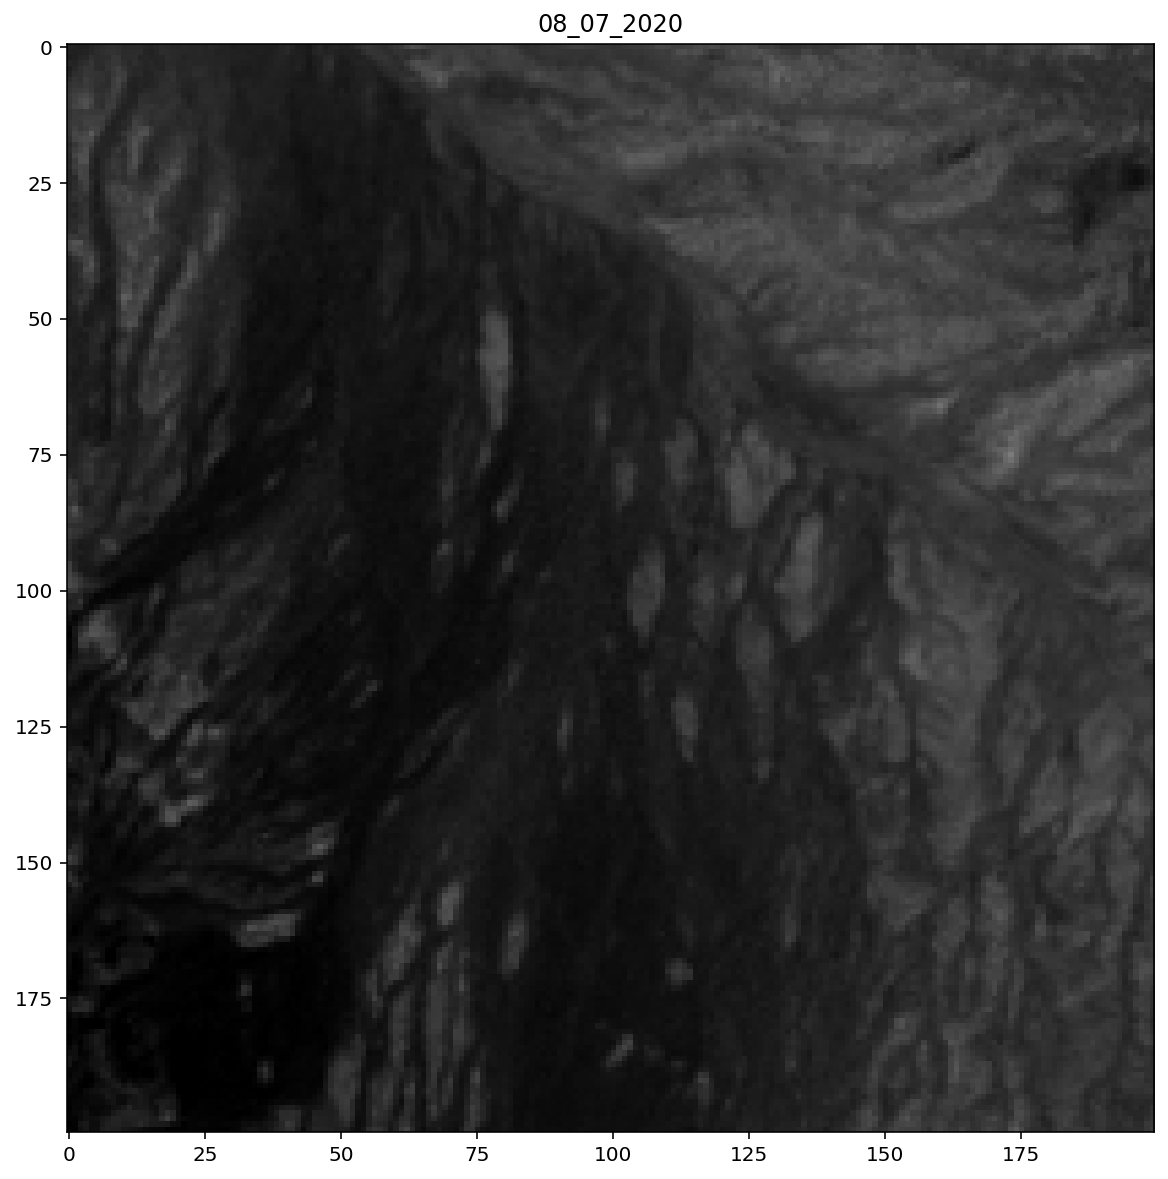

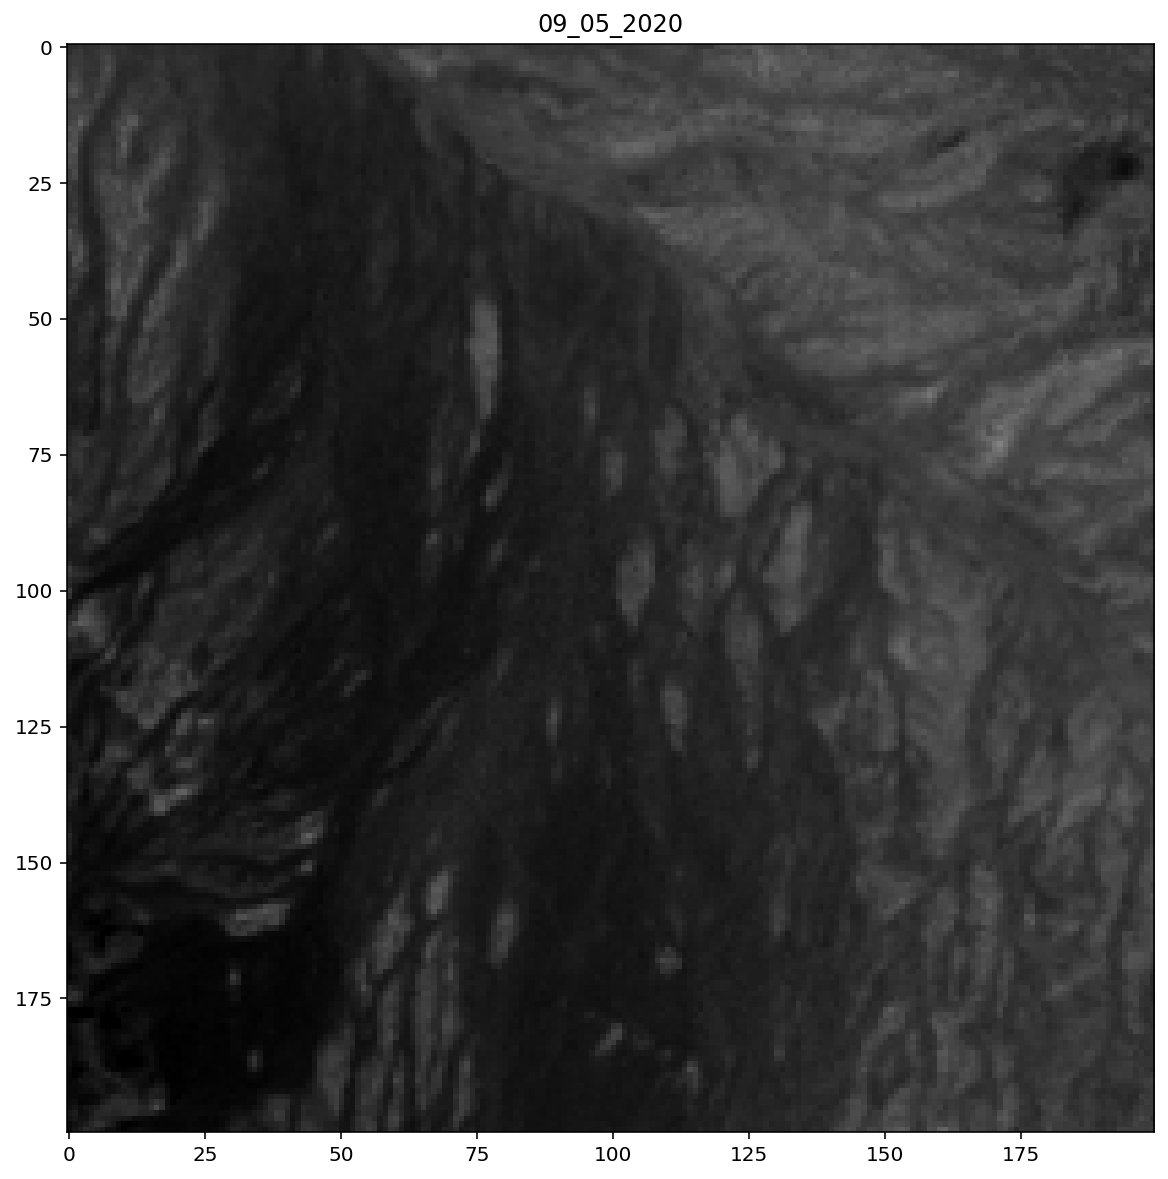

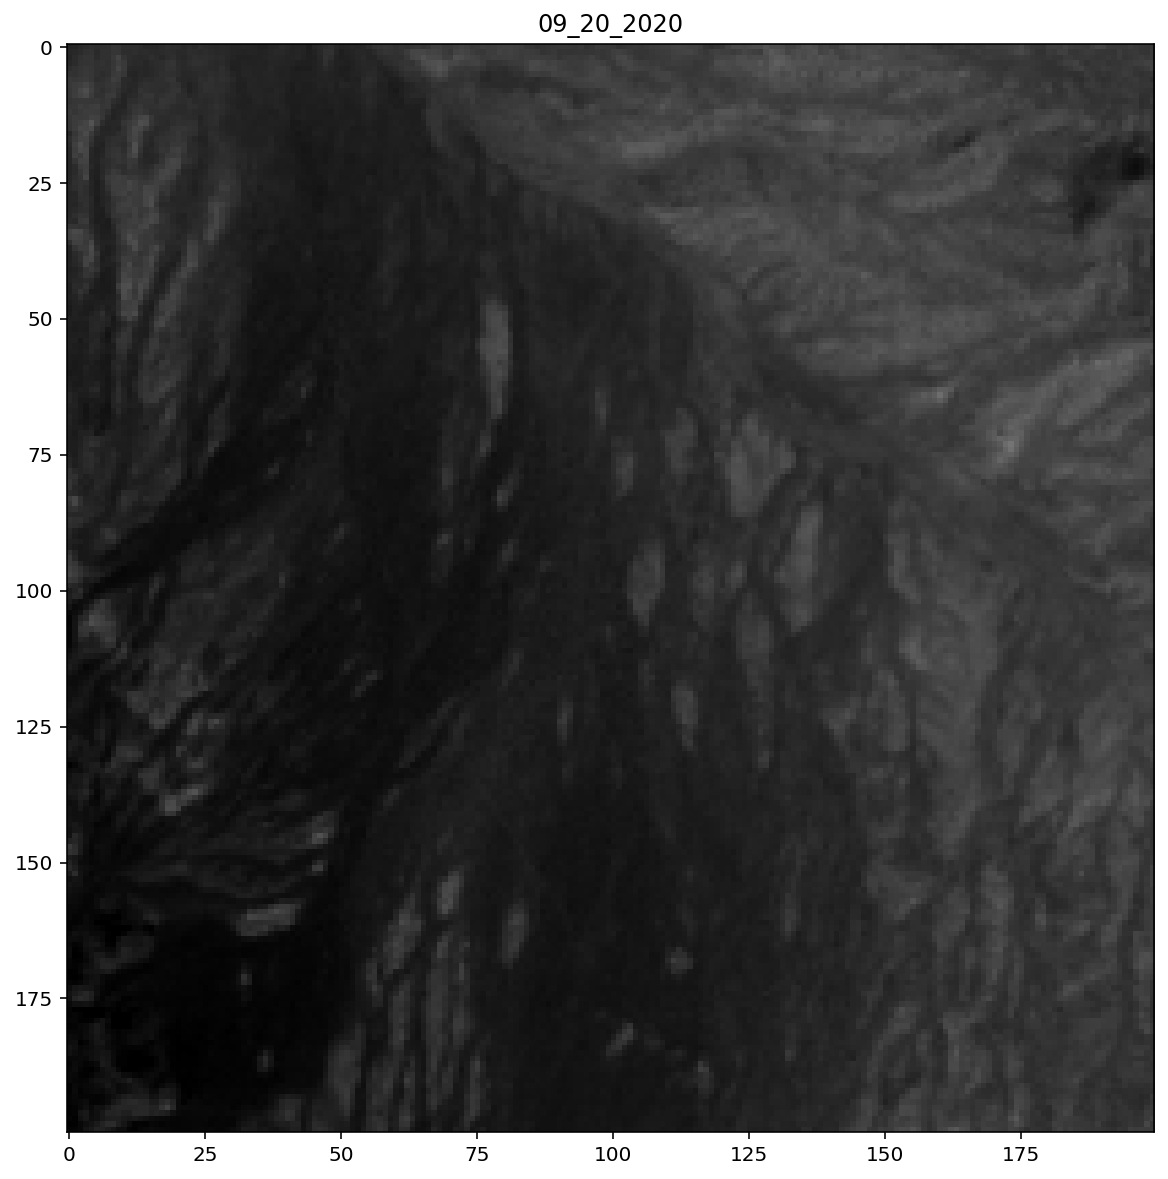

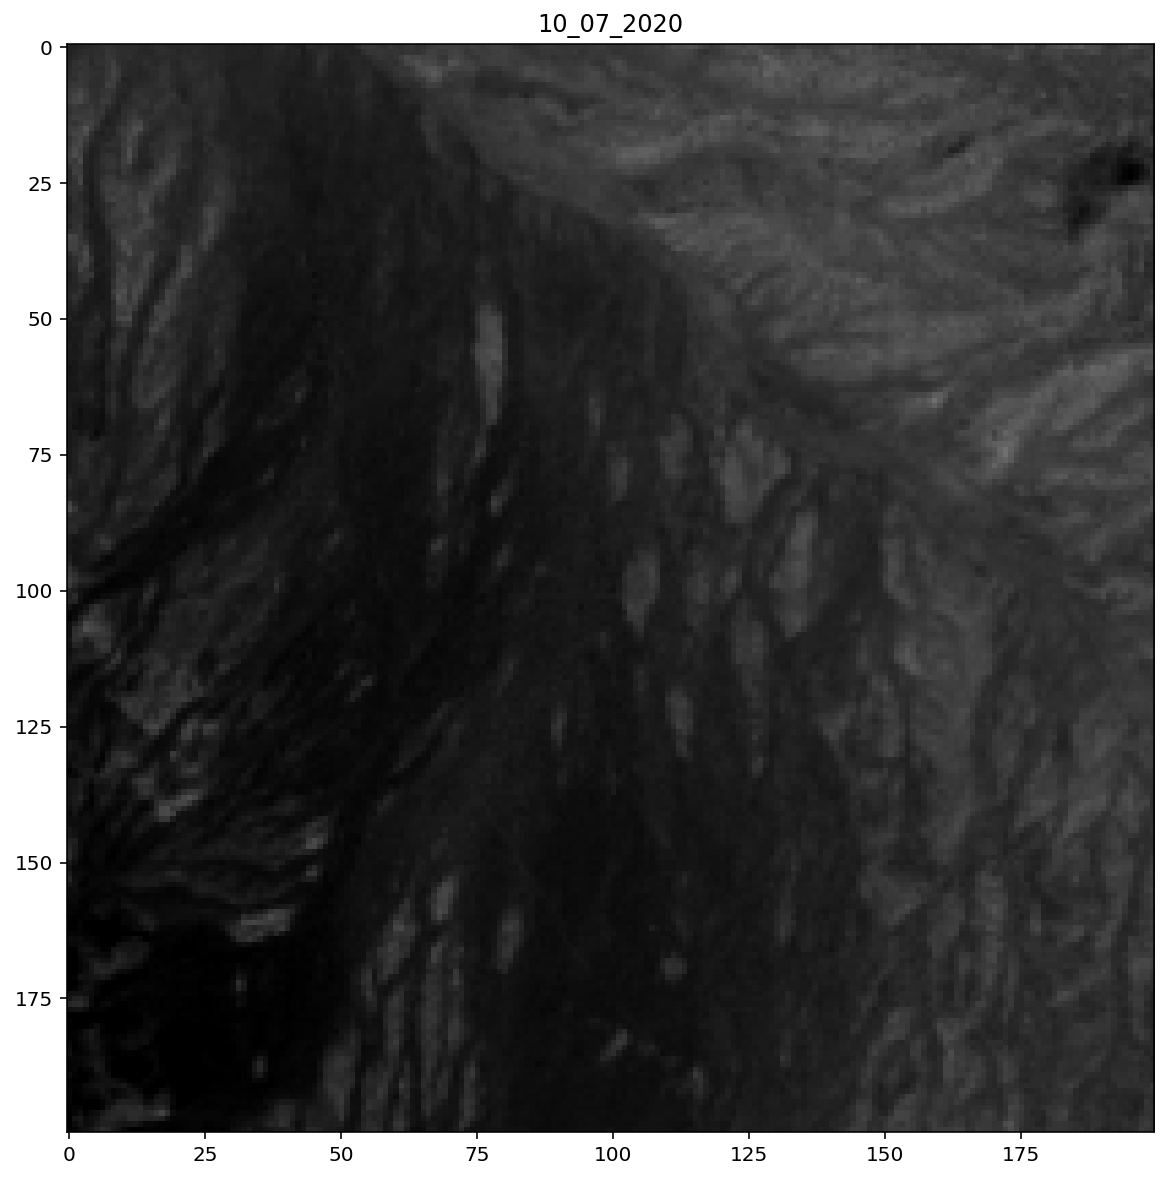

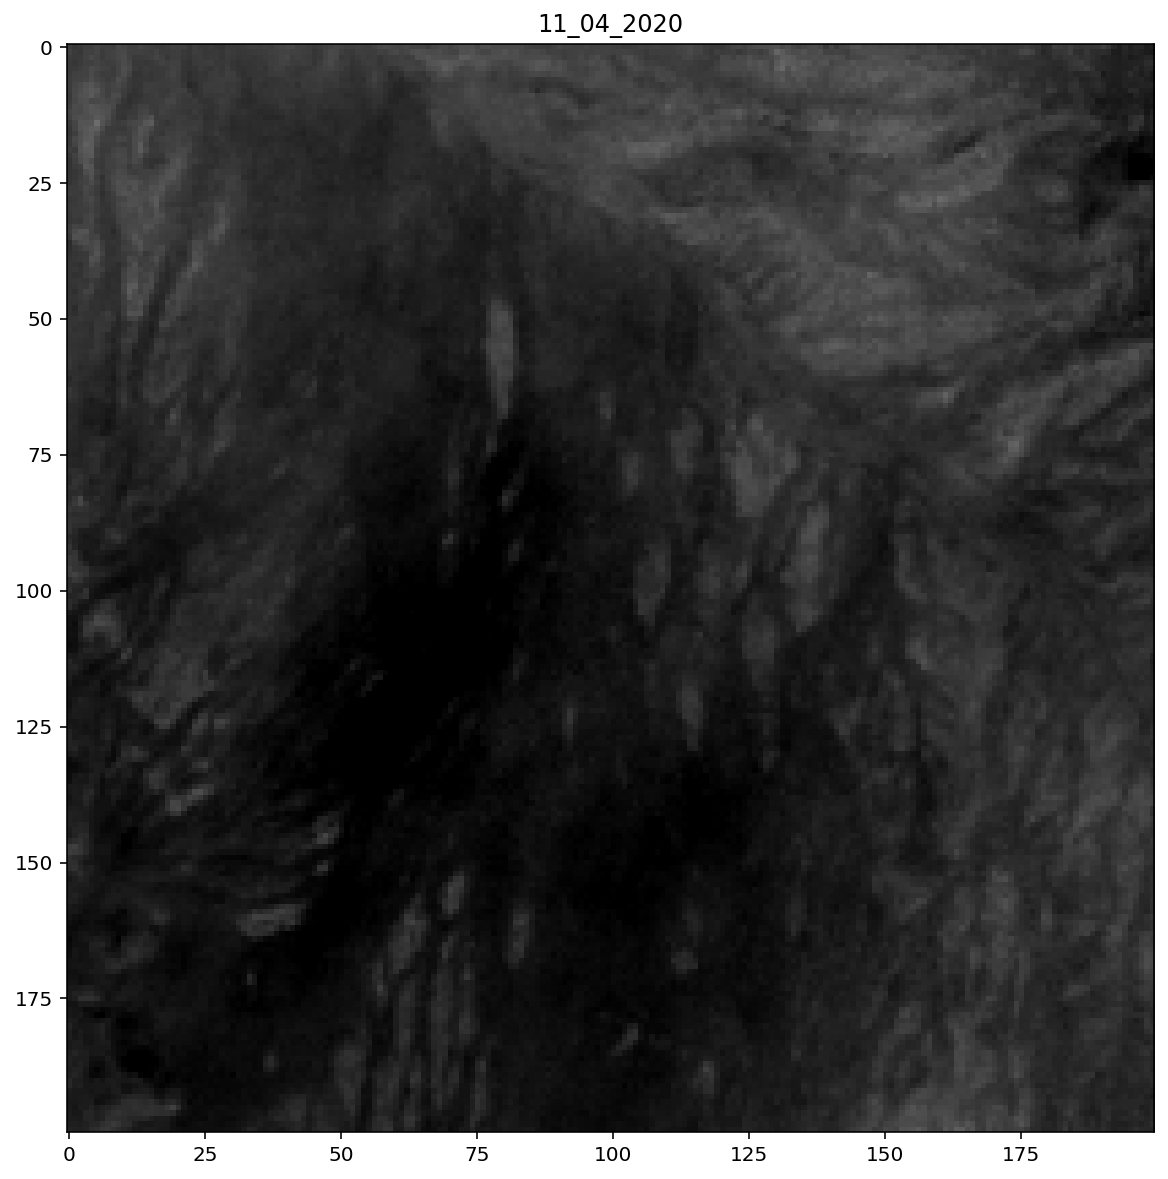

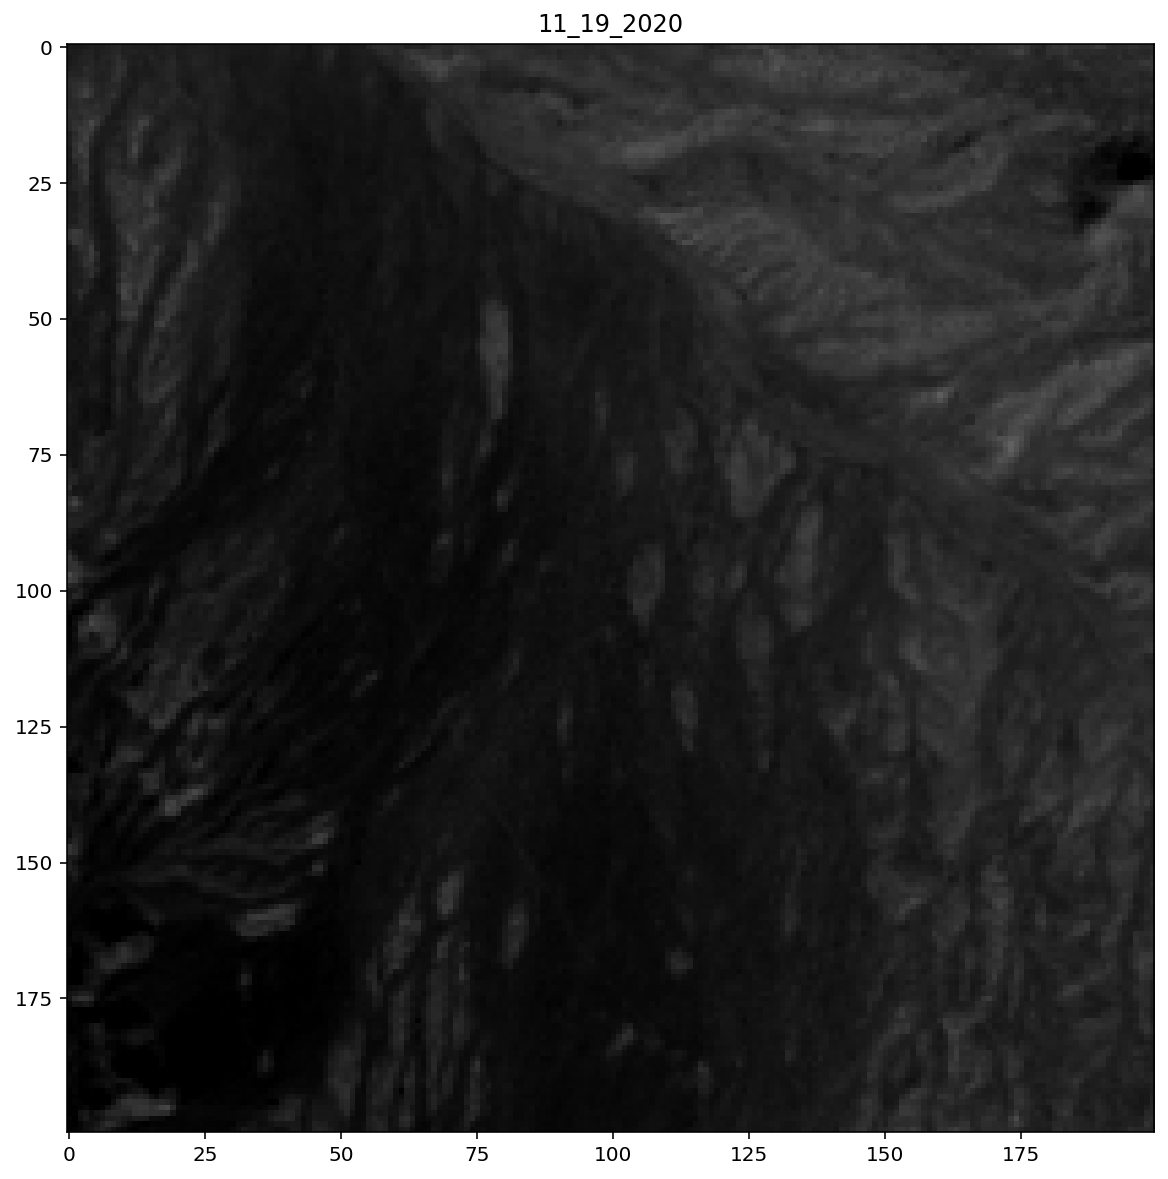

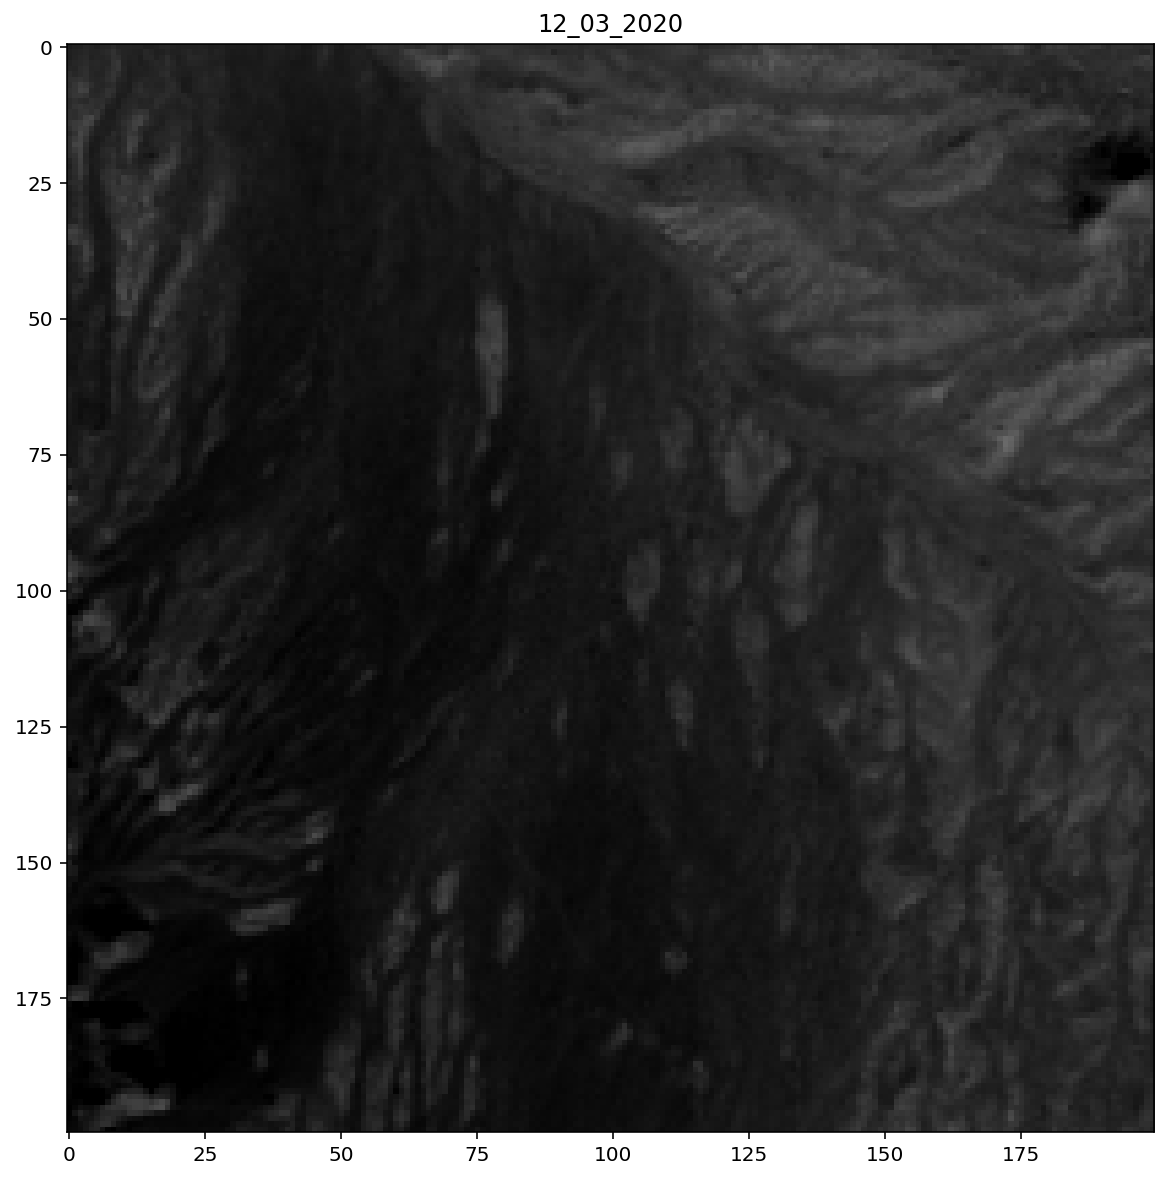

In [15]:
### PAN ###

# Plotting the locally saved pan images to test them
# This cell can be commented out if the locally saved images plotted correctly after running this cell, as this is just a way to visually confirm the correct image adjustments.
#-------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_0_large)
plt.title(dates[0])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_2_large)
plt.title(dates[2])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_3_large)
plt.title(dates[3])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_4_large)
plt.title(dates[4])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_5_large)
plt.title(dates[5])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_6_large)
plt.title(dates[6])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_7_large)
plt.title(dates[7])
plt.show()
#-------------------------------------------------------------------------------#

## 3. Rescale the low-res RGB images to have the same array size as the panchromatic images
### 3.1 Functions for rescaling and plotting the rescaled images 

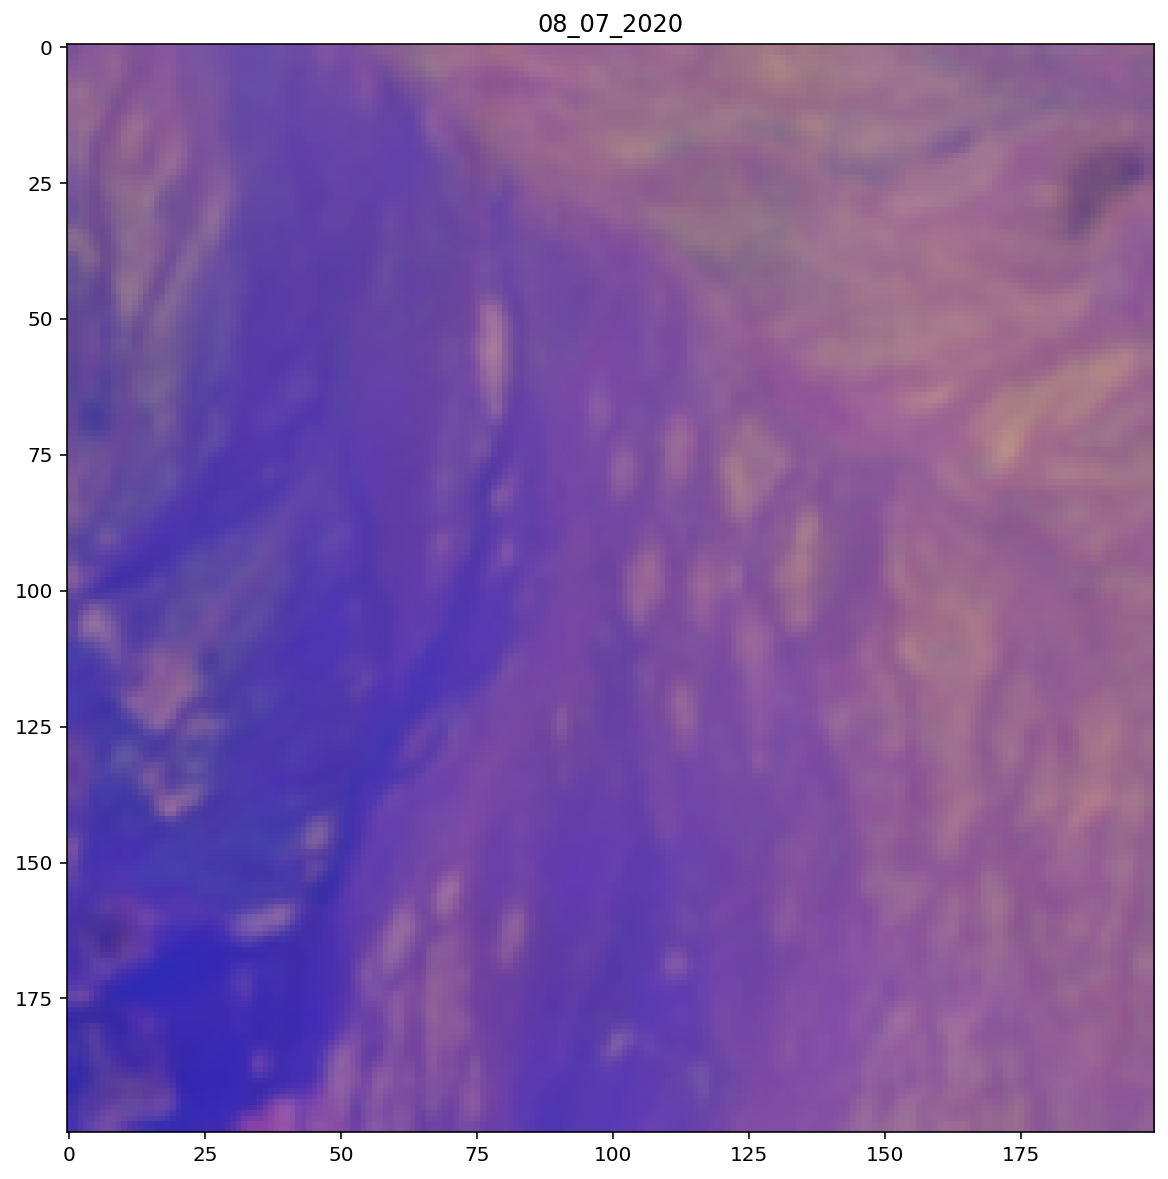

Array info:
shape: (200, 200, 3)
dtype: float64
min, max: 0.14847059556441558 0.7257527698355959


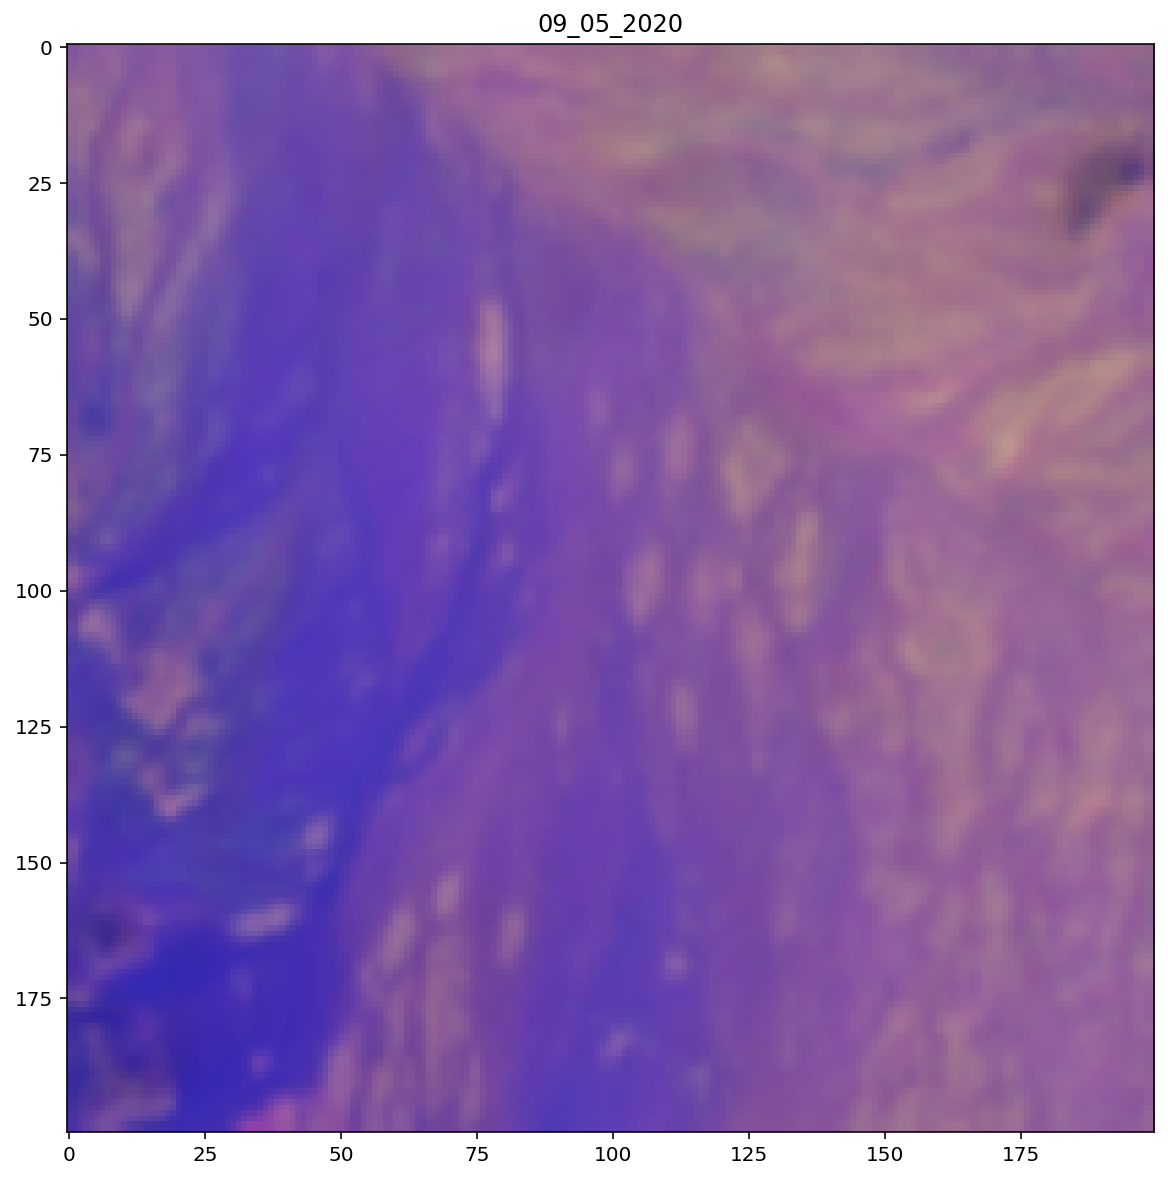

Array info:
shape: (200, 200, 3)
dtype: float64
min, max: 0.1494868751745324 0.7449595479645553


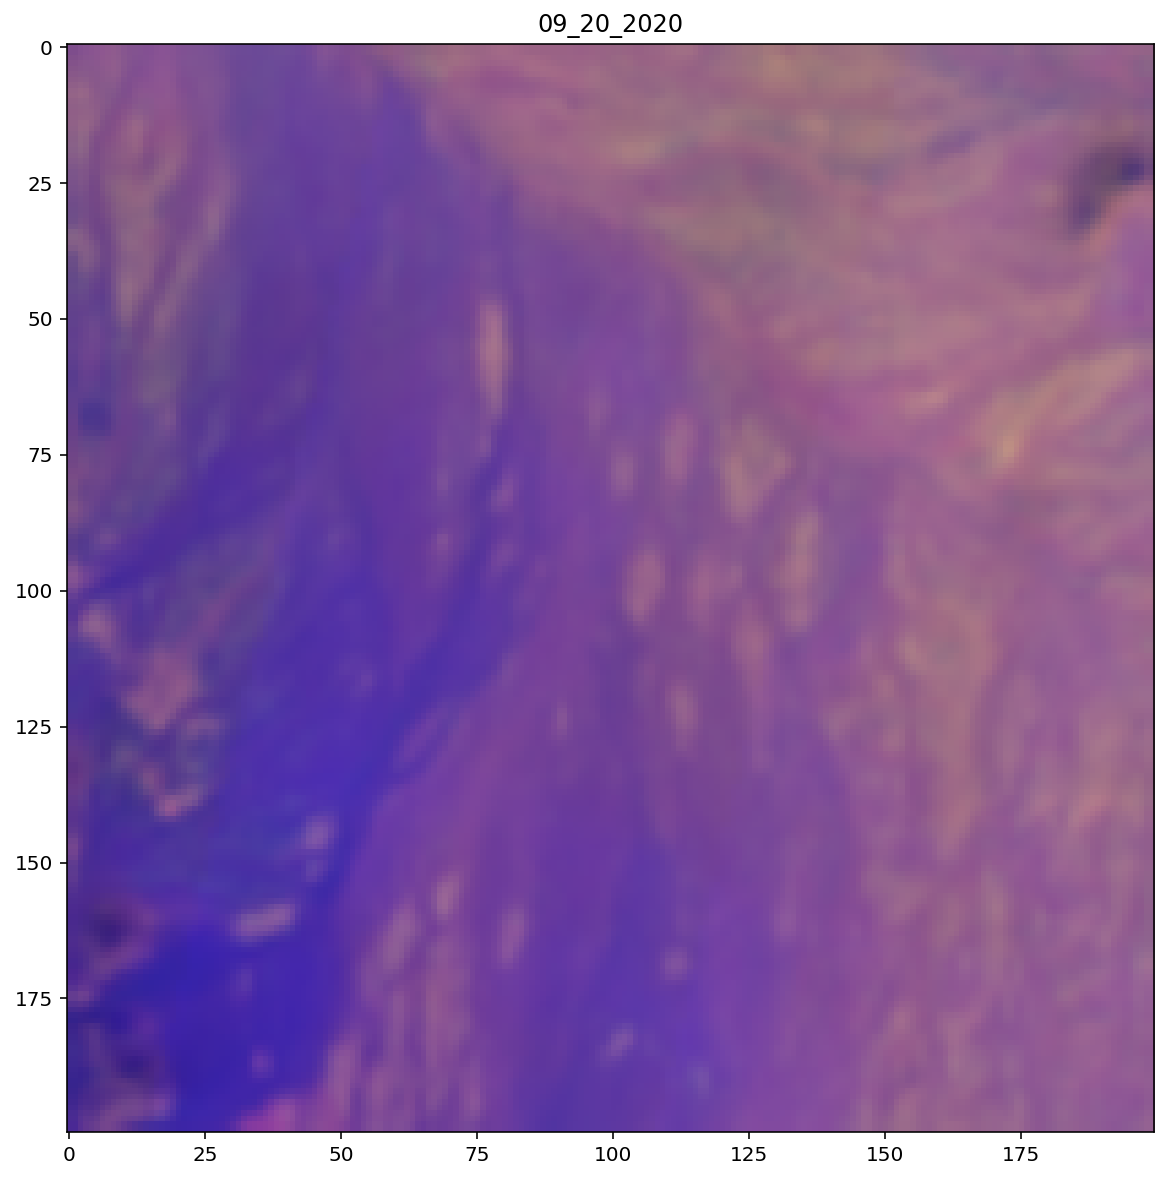

Array info:
shape: (200, 200, 3)
dtype: float64
min, max: 0.11128246052972167 0.7432344915722564


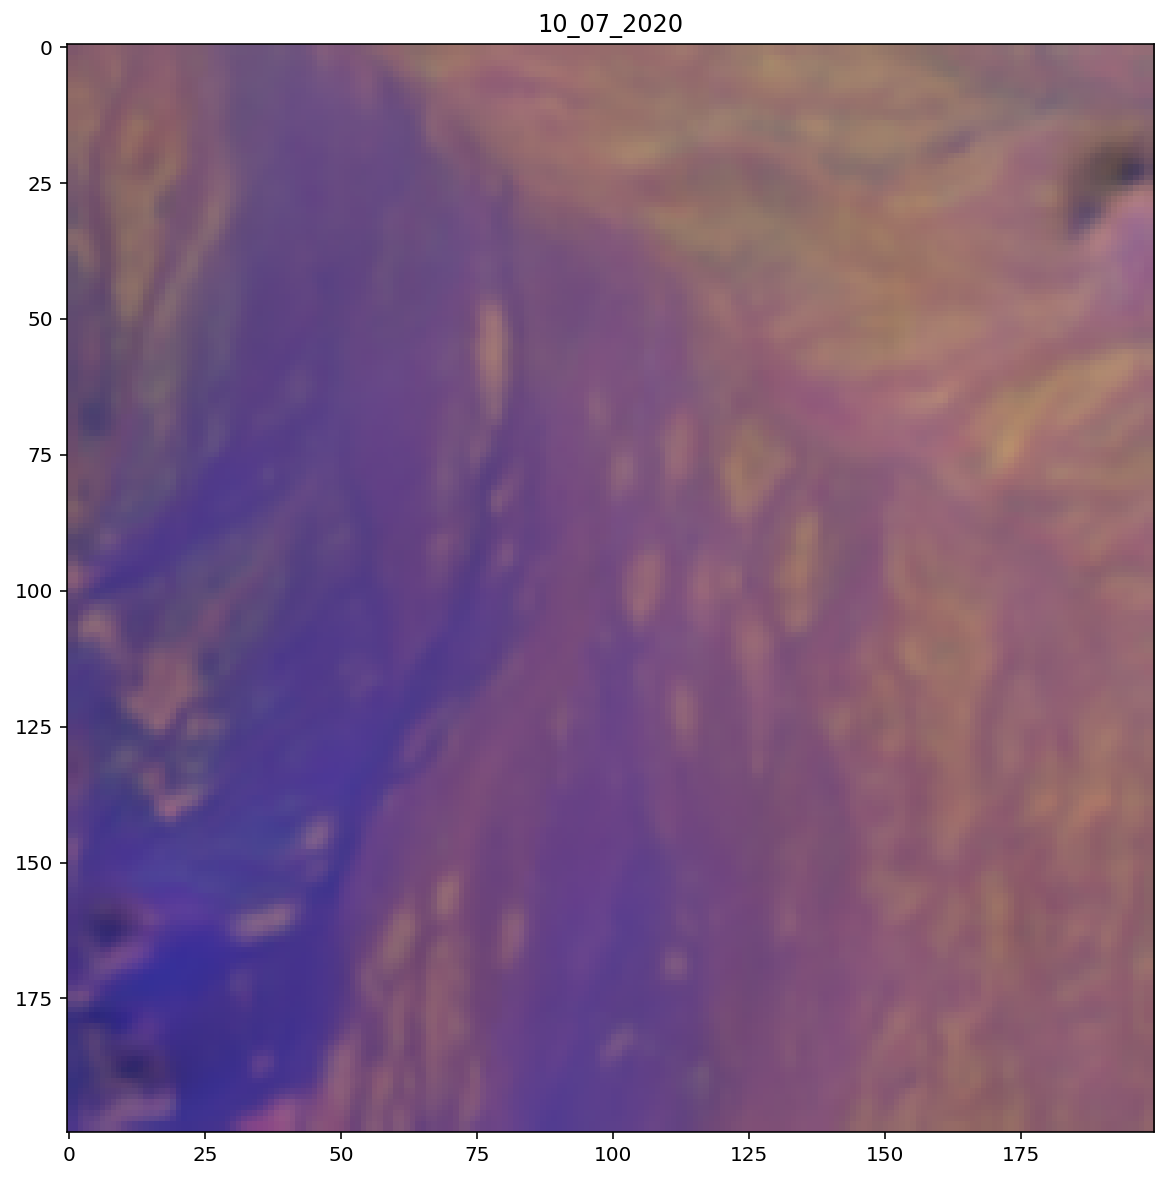

Array info:
shape: (200, 200, 3)
dtype: float64
min, max: 0.15430238522698136 0.7211876222206121


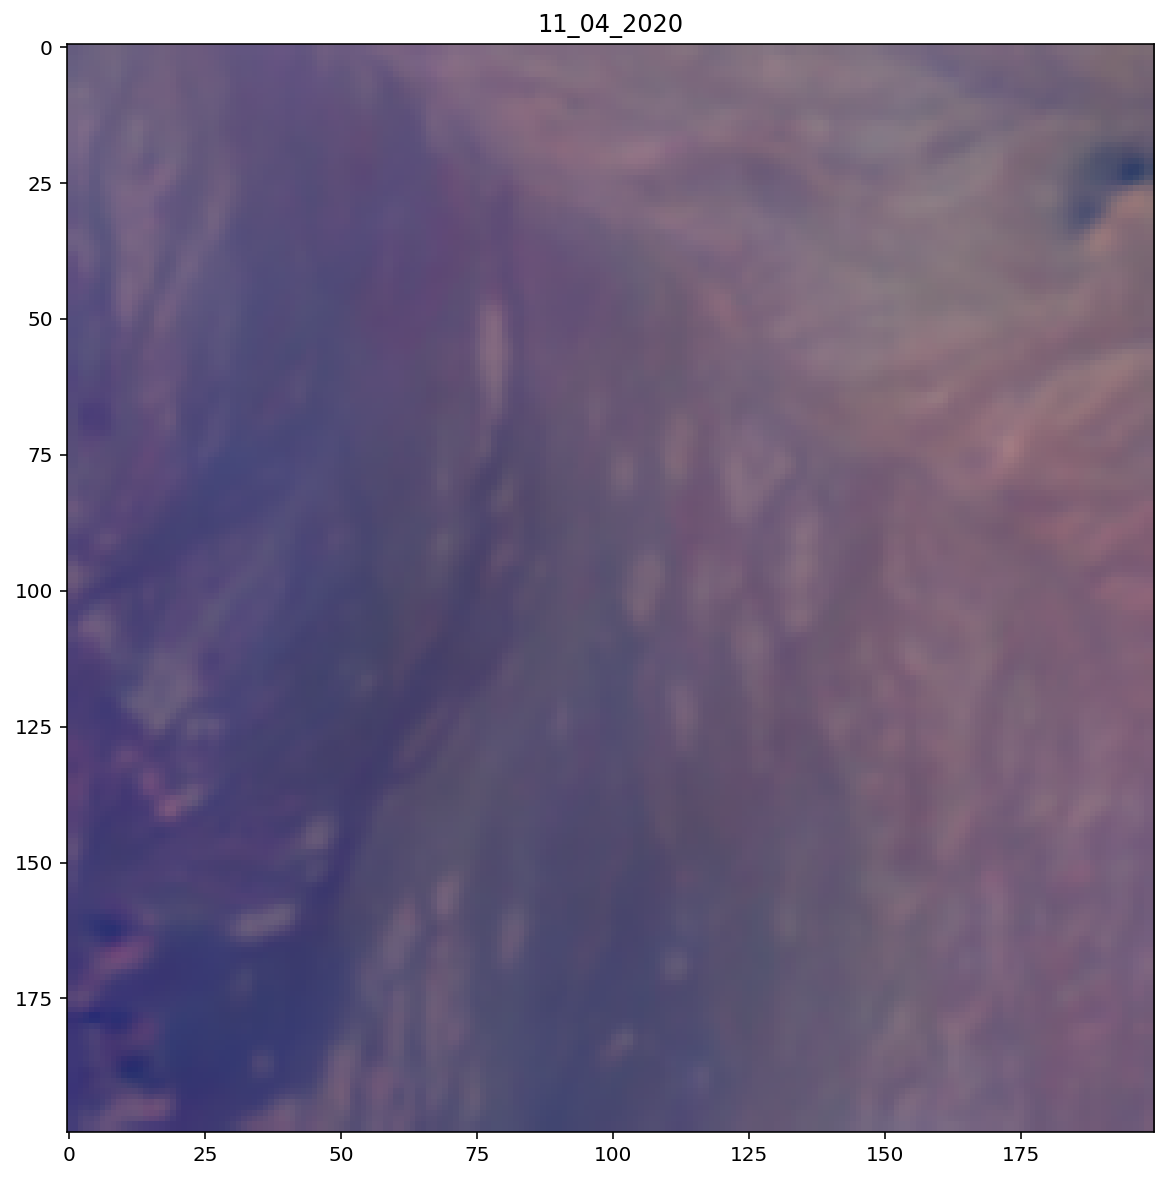

Array info:
shape: (200, 200, 3)
dtype: float64
min, max: 0.15302249106852844 0.6353016401429026


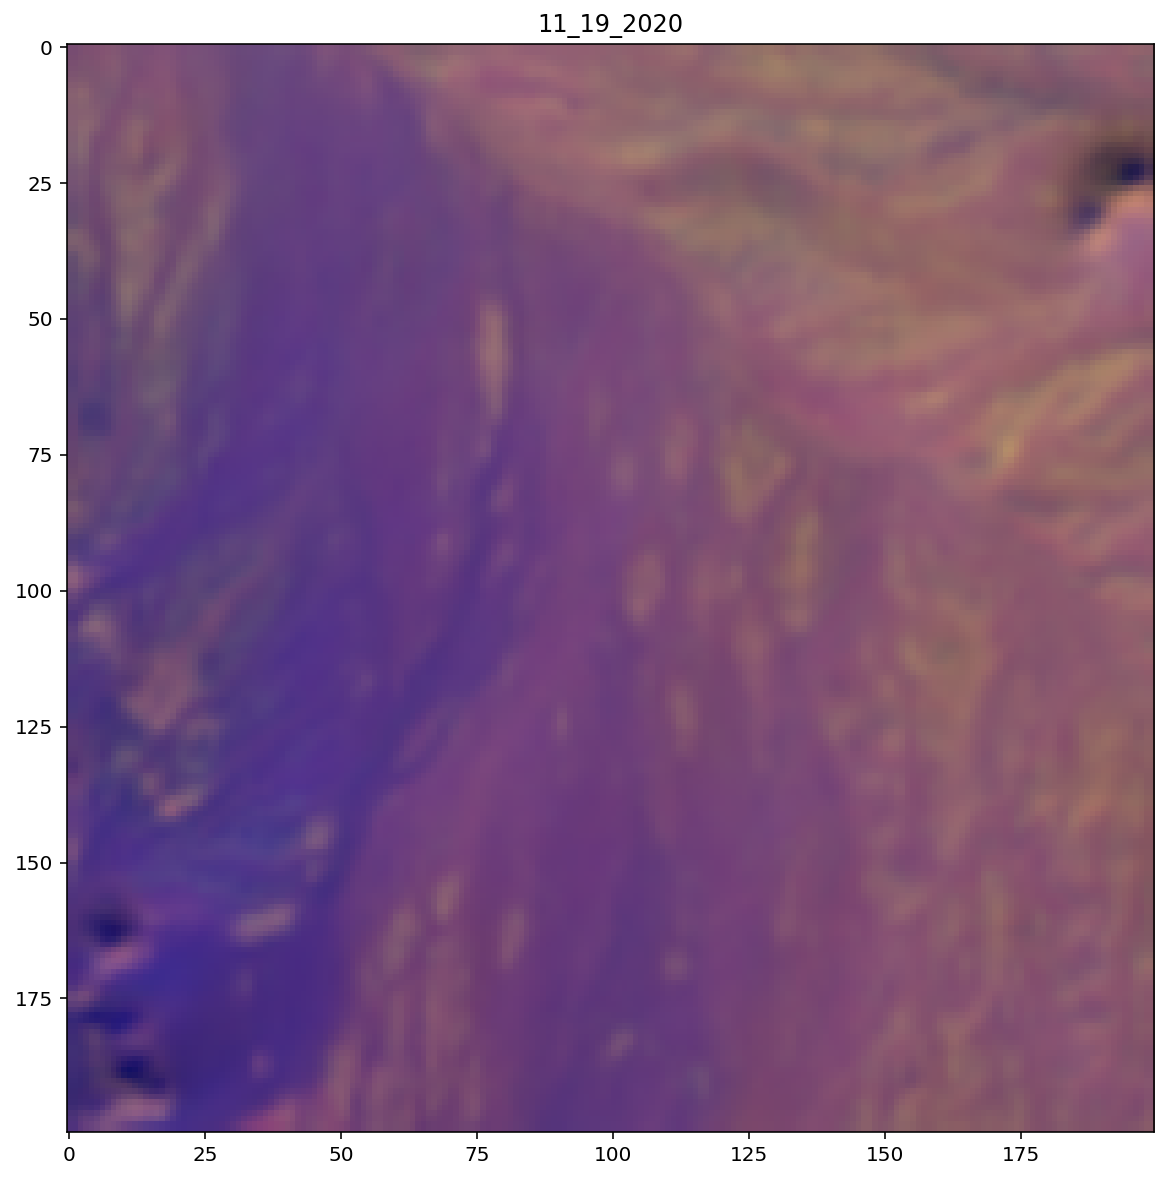

Array info:
shape: (200, 200, 3)
dtype: float64
min, max: 0.06367097550764028 0.7512359073013601


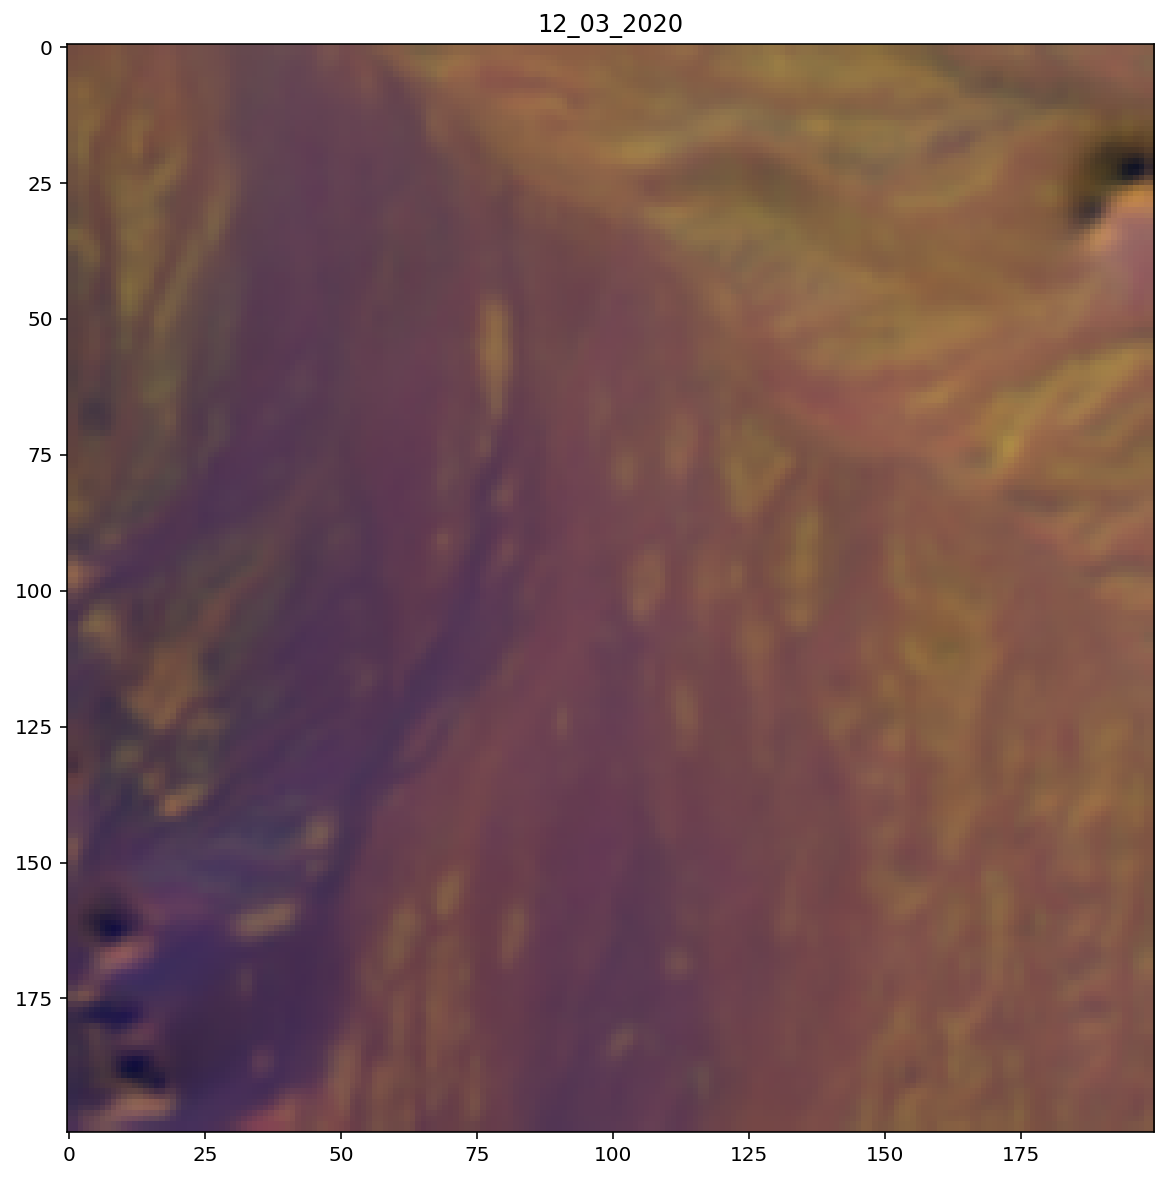

Array info:
shape: (200, 200, 3)
dtype: float64
min, max: 0.056625886119367884 0.7427402887263759


In [16]:
## LOW-RES RESCALED RGB ###

### This cell is used to resize the low-res images to match the array size of the pan images finally save the desired images locally as npz's so that we don't have to use the full sized Landsat frames every time.
### Once the desired images are saved locally, this entire cell can be commented out.
#-------------------------------------------------------------------------------#
# date0 = '08_07_2020'
# date1 = '08_22_2020'
# date2 = '09_05_2020'
# date3 = '09_20_2020'
# date4 = '10_07_2020'
# date5 = '11_04_2020'
# date6 = '11_19_2020'
# date7 = '12_03_2020'

dates = ['08_07_2020', '08_22_2020', '09_05_2020', '09_20_2020', '10_07_2020', '11_04_2020', '11_19_2020', '12_03_2020']

#----------------------------------------------------#

ls_0_lw_large = resize(ls_0_lw, (ls_0_lw.shape[0] * 2, ls_0_lw.shape[1] * 2),anti_aliasing=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_0_lw_large)
plt.title(dates[0])
plt.show()
PrintArrayInfo(ls_0_lw_large)

#np.savez('ls_0_lw_large', ls_0_lw_large)

#----------------------------------------------------#

### Skipping this image due to too much cloud cover

# ls_1_lw_large = resize(ls_1_lw, (ls_1_lw.shape[0] * 2, ls_1_lw.shape[1] * 2),anti_aliasing=True)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# #plt.axis('off')
# plt.imshow(ls_1_lw_large)
# plt.title(dates[1])
# plt.show()
# PrintArrayInfo(ls_1_lw_large)

# #np.savez('ls_1_lw_large', ls_1_lw_large)

#----------------------------------------------------#

ls_2_lw_large = resize(ls_2_lw, (ls_2_lw.shape[0] * 2, ls_2_lw.shape[1] * 2),anti_aliasing=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_2_lw_large)
plt.title(dates[2])
plt.show()
PrintArrayInfo(ls_2_lw_large)

#np.savez('ls_2_lw_large', ls_2_lw_large)

#----------------------------------------------------#

ls_3_lw_large = resize(ls_3_lw, (ls_3_lw.shape[0] * 2, ls_3_lw.shape[1] * 2),anti_aliasing=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_3_lw_large)
plt.title(dates[3])
plt.show()
PrintArrayInfo(ls_3_lw_large)

#np.savez('ls_3_lw_large', ls_3_lw_large)

#----------------------------------------------------#

ls_4_lw_large = resize(ls_4_lw, (ls_4_lw.shape[0] * 2, ls_4_lw.shape[1] * 2),anti_aliasing=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_4_lw_large)
plt.title(dates[4])
plt.show()
PrintArrayInfo(ls_4_lw_large)

#np.savez('ls_4_lw_large', ls_4_lw_large)

#----------------------------------------------------#

ls_5_lw_large = resize(ls_5_lw, (ls_5_lw.shape[0] * 2, ls_5_lw.shape[1] * 2),anti_aliasing=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_5_lw_large)
plt.title(dates[5])
plt.show()
PrintArrayInfo(ls_5_lw_large)

#np.savez('ls_5_lw_large', ls_5_lw_large)

#----------------------------------------------------#

ls_6_lw_large = resize(ls_6_lw, (ls_6_lw.shape[0] * 2, ls_6_lw.shape[1] * 2),anti_aliasing=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_6_lw_large)
plt.title(dates[6])
plt.show()
PrintArrayInfo(ls_6_lw_large)

#np.savez('ls_6_lw_large', ls_6_lw_large)

#----------------------------------------------------#

ls_7_lw_large = resize(ls_7_lw, (ls_7_lw.shape[0] * 2, ls_7_lw.shape[1] * 2),anti_aliasing=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_7_lw_large)
plt.title(dates[7])
plt.show()
PrintArrayInfo(ls_7_lw_large)

#np.savez('ls_7_lw_large', ls_7_lw_large)

#----------------------------------------------------#

#### 3.1.1 Loading in the locally saved low-res rescaled RGB images

In [17]:
### LOW-RES RESCALED RGB ###

# Load in the locally saved resized low-res images
#-------------------------------------------------------------------------------#
ls_0_lw_large = np.load('ls_0_lw_large'+'.npz')
ls_0_lw_large = ls_0_lw_large['arr_0']

ls_2_lw_large = np.load('ls_2_lw_large'+'.npz')
ls_2_lw_large = ls_2_lw_large['arr_0']

ls_3_lw_large = np.load('ls_3_lw_large'+'.npz')
ls_3_lw_large = ls_3_lw_large['arr_0']

ls_4_lw_large = np.load('ls_4_lw_large'+'.npz')
ls_4_lw_large = ls_4_lw_large['arr_0']

ls_5_lw_large = np.load('ls_5_lw_large'+'.npz')
ls_5_lw_large = ls_5_lw_large['arr_0']

ls_6_lw_large = np.load('ls_6_lw_large'+'.npz')
ls_6_lw_large = ls_6_lw_large['arr_0']

ls_7_lw_large = np.load('ls_7_lw_large'+'.npz')
ls_7_lw_large = ls_7_lw_large['arr_0']
#-------------------------------------------------------------------------------#

#### 3.1.2 Plotting in the locally saved low-res rescaled RGB images

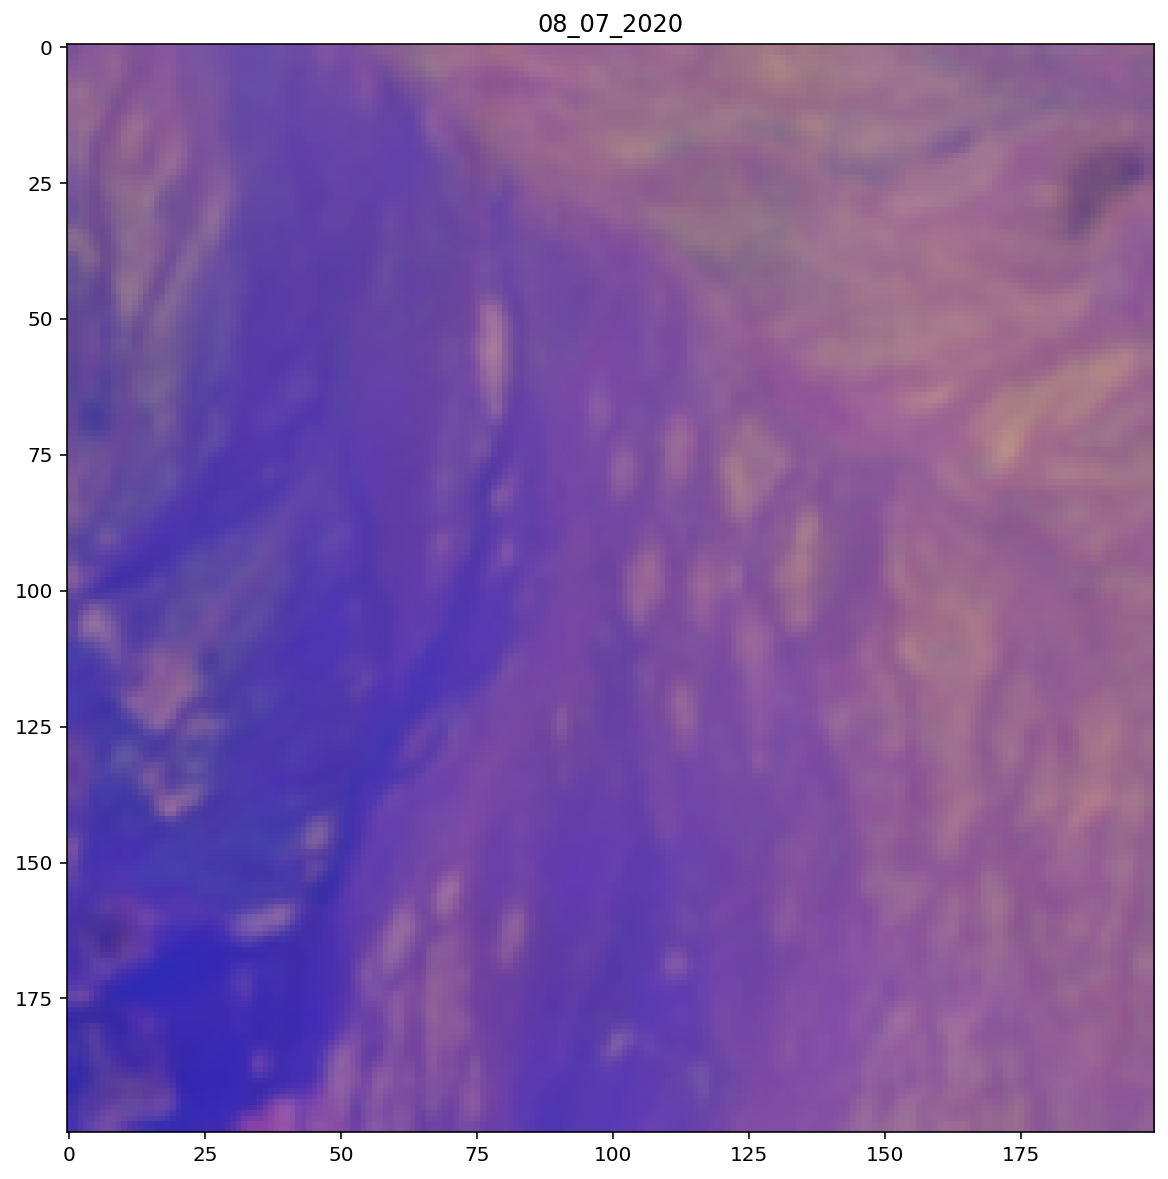

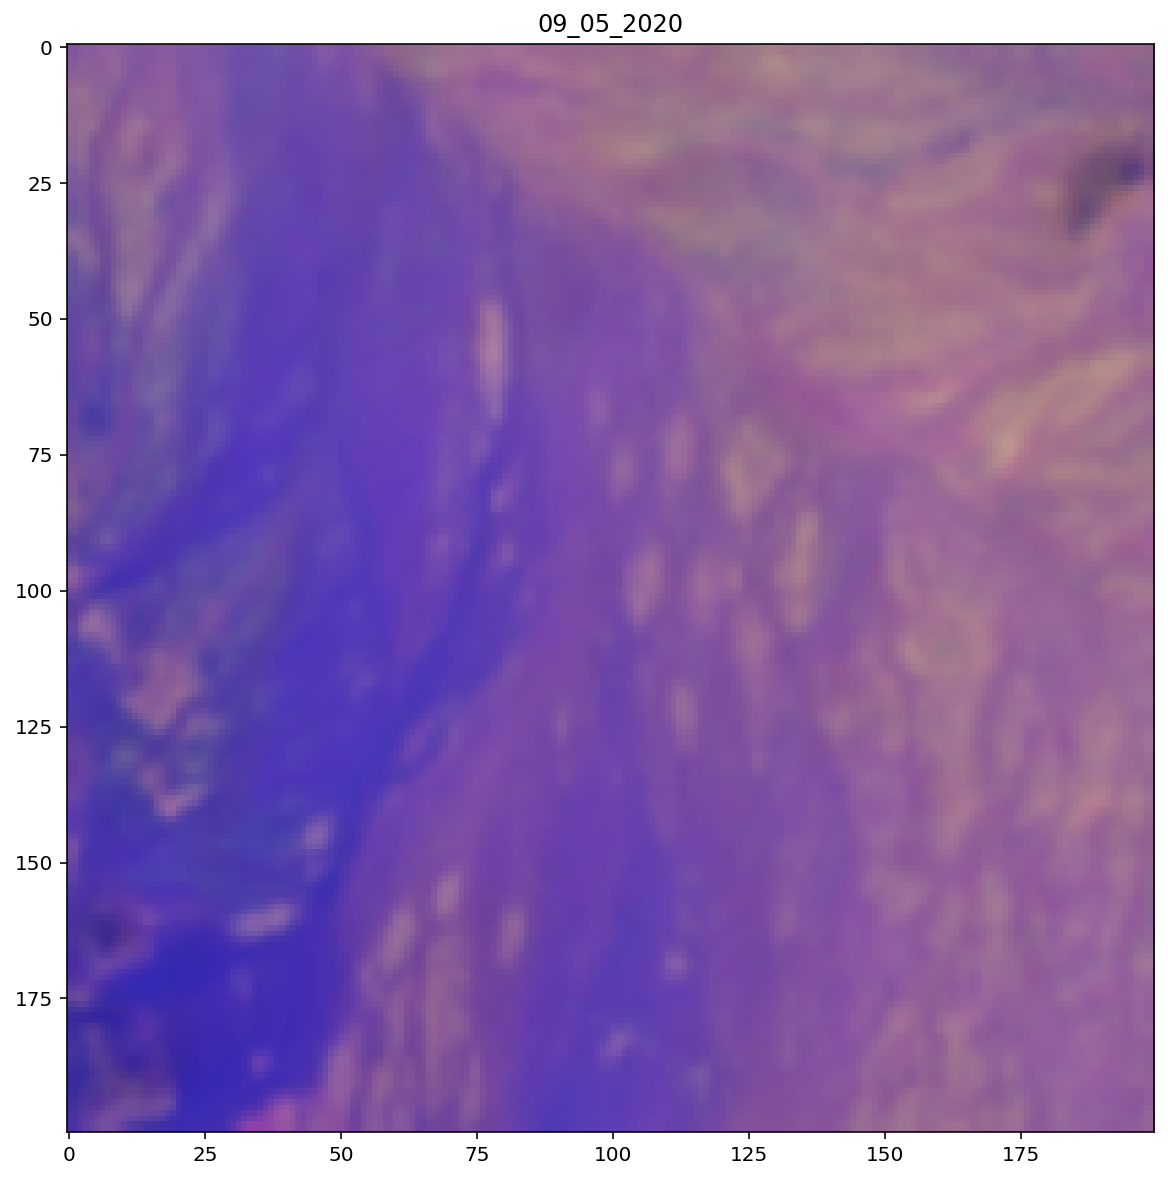

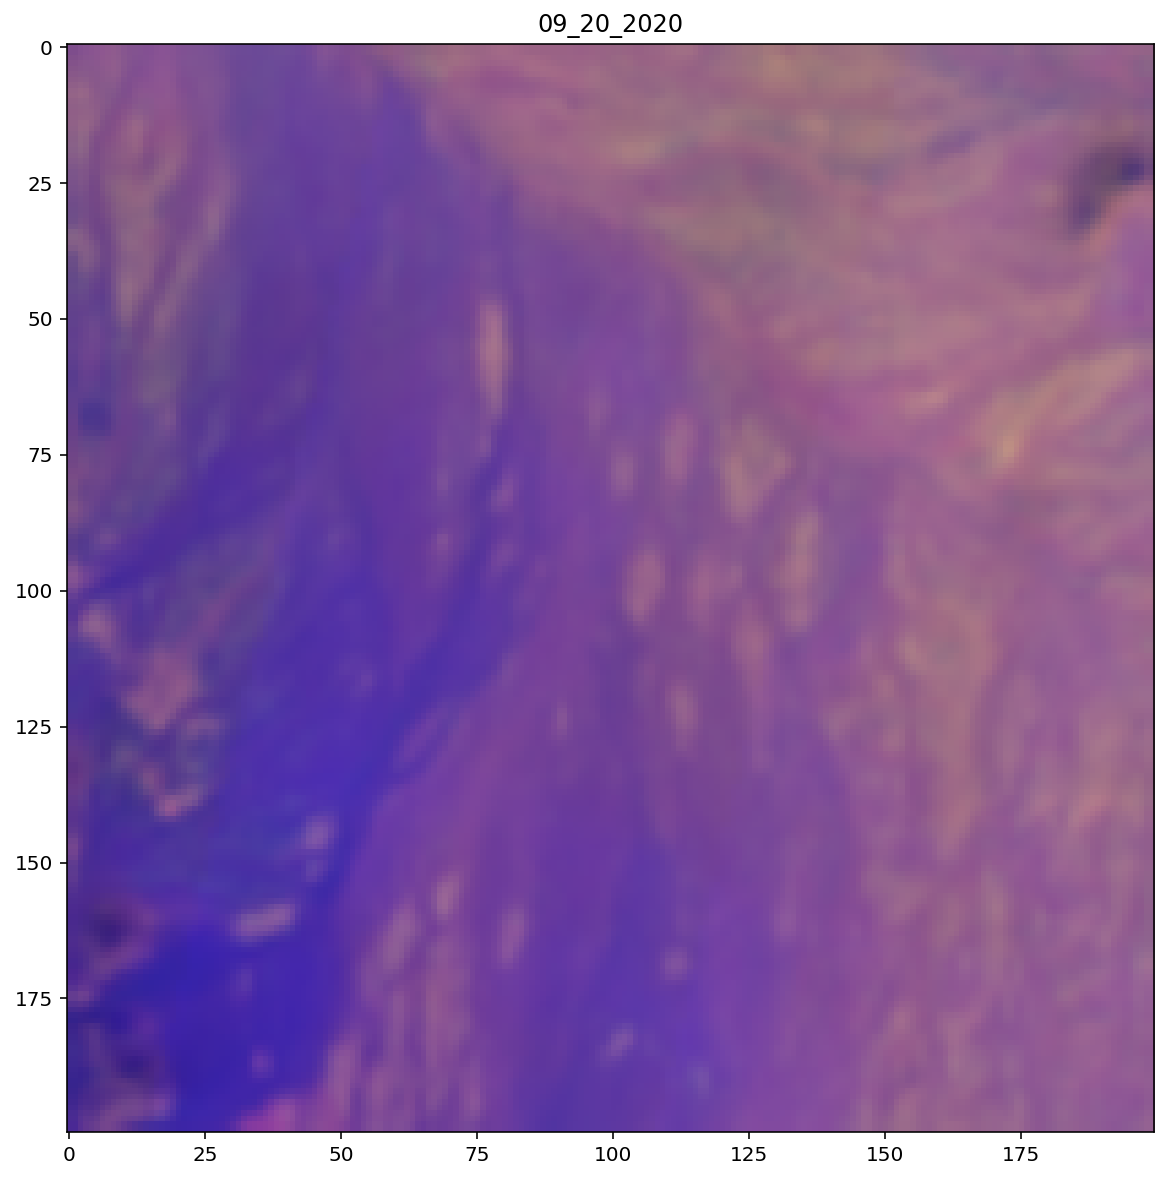

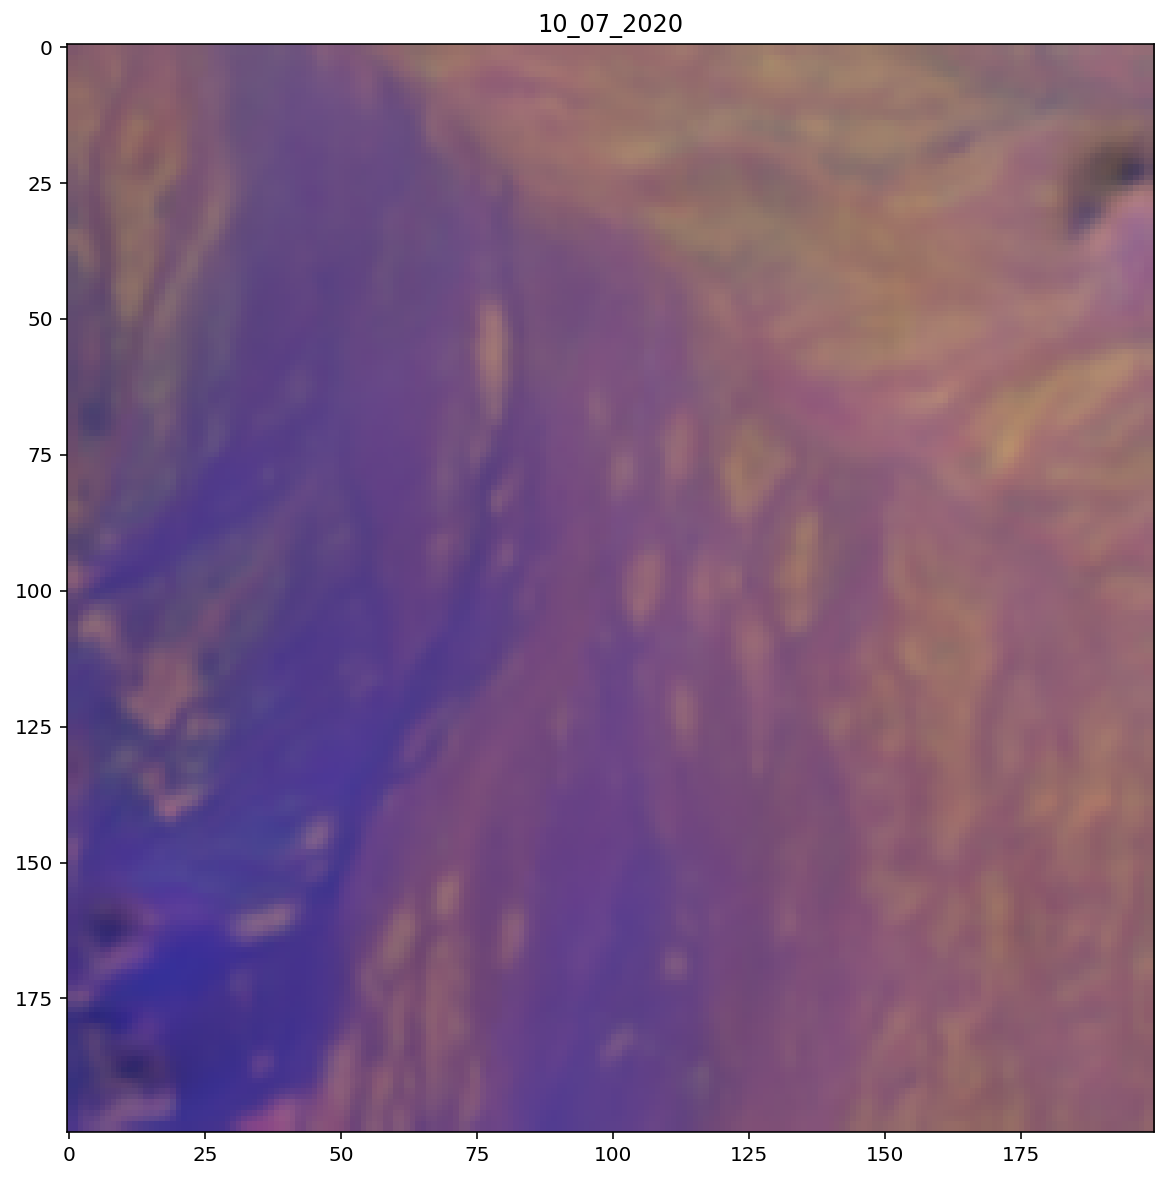

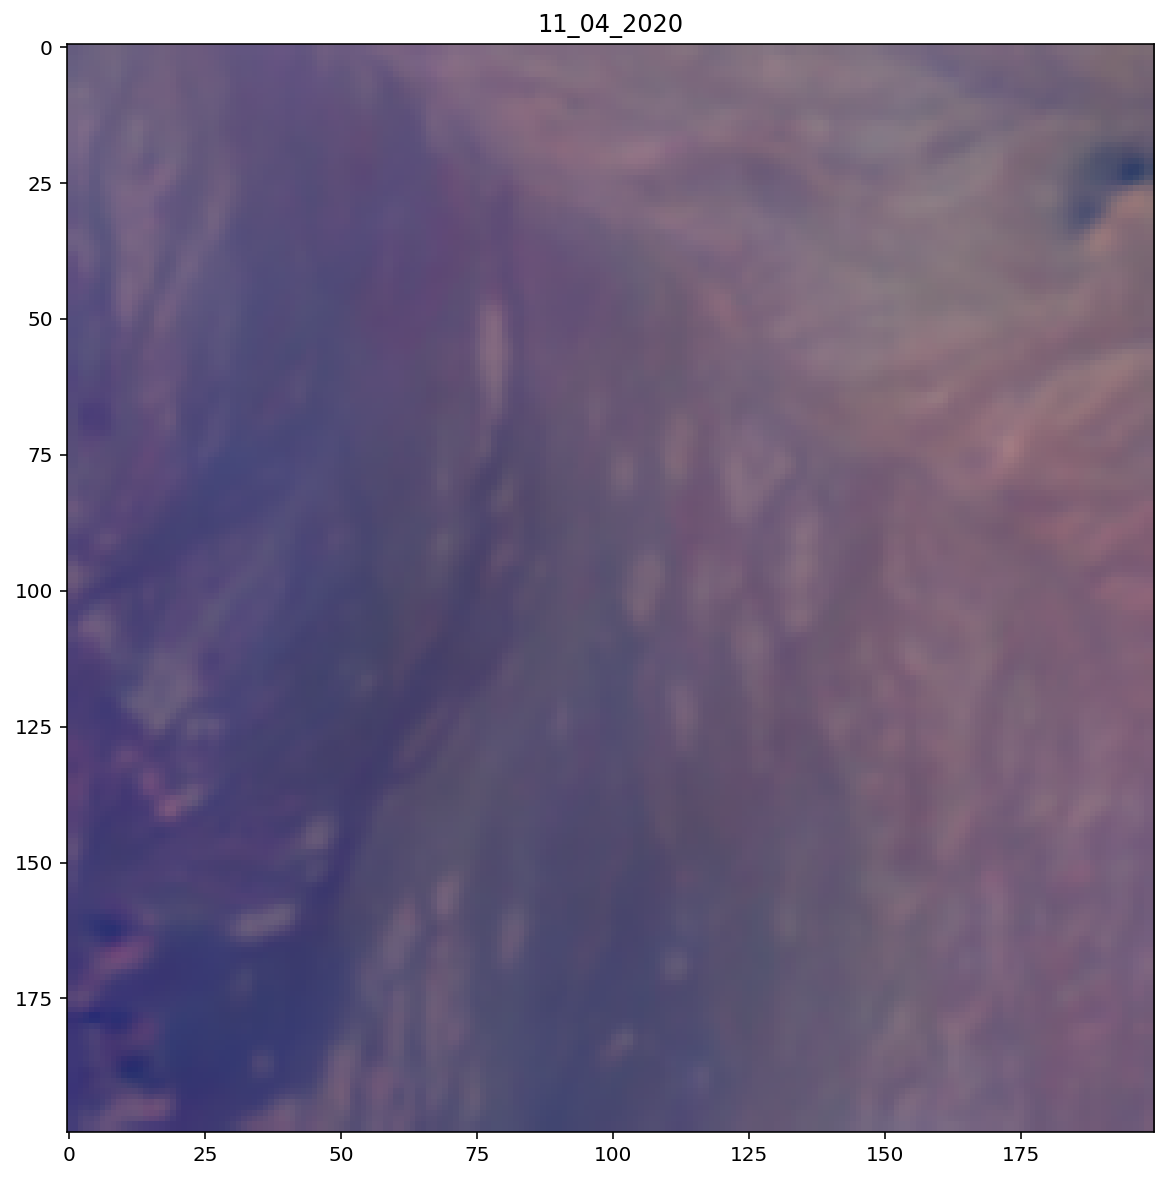

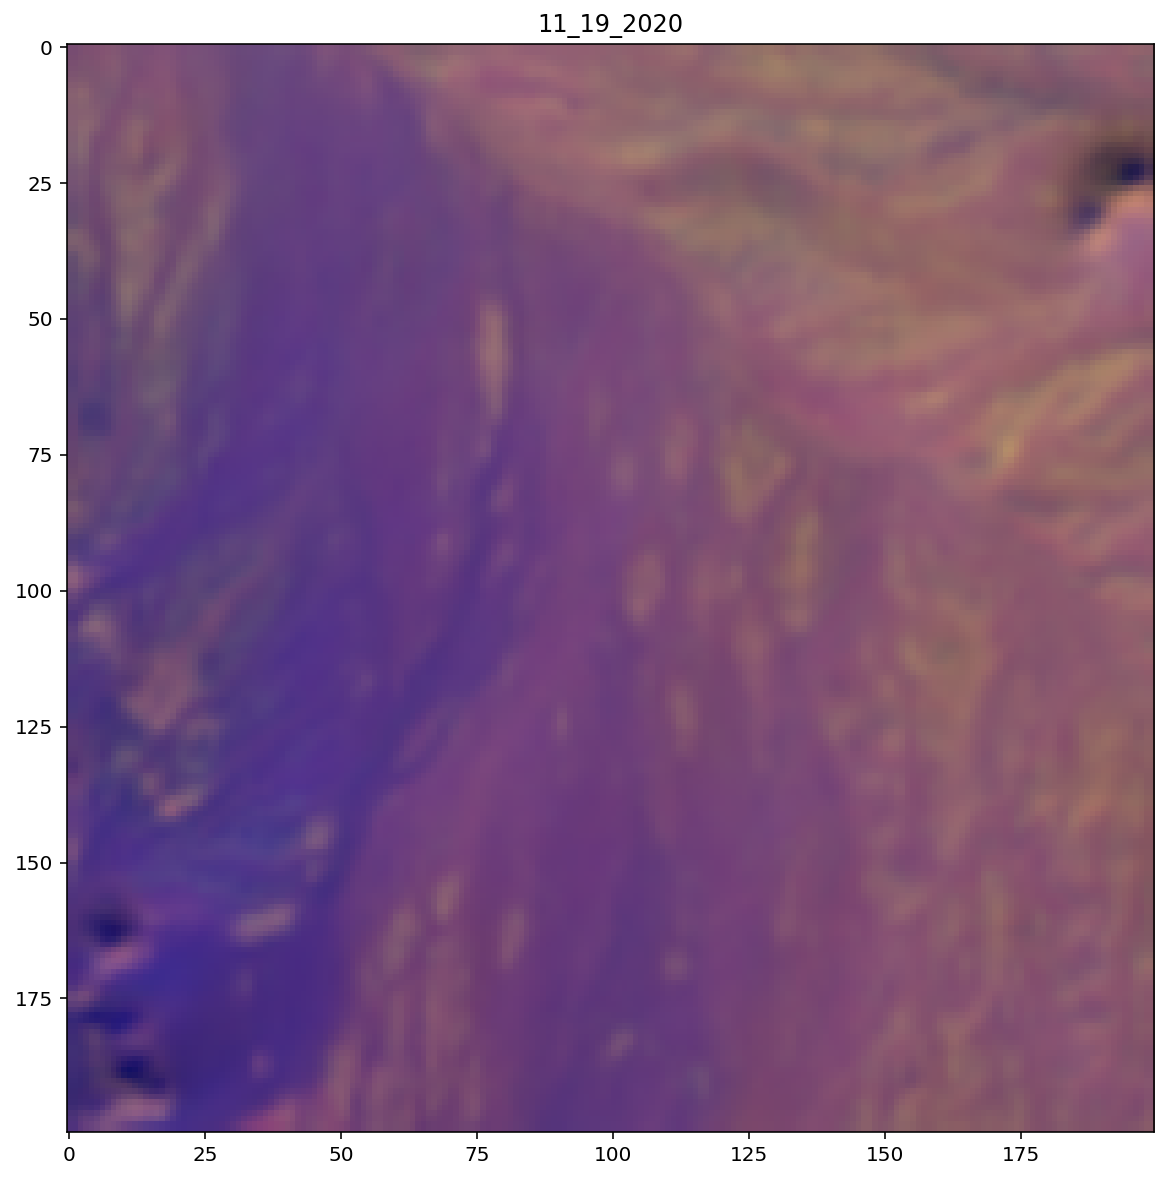

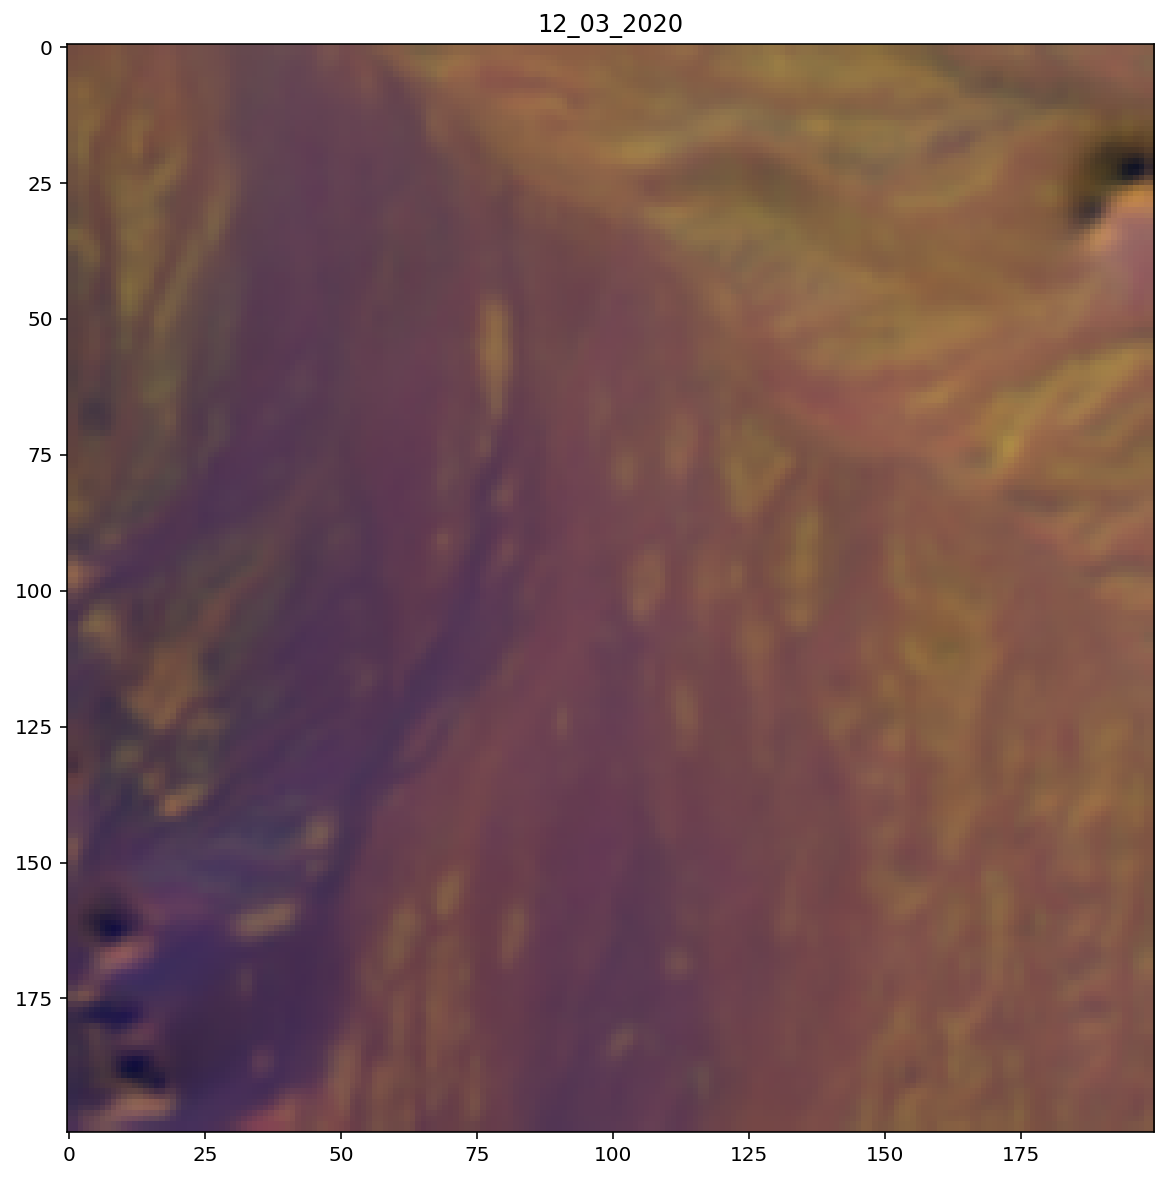

In [18]:
### LOW-RES RESCALED RGB ###

# Plotting the locally saved resized low-res images to test them
# This cell can be commented out if the locally saved images plotted correctly after running this cell, as this is just a way to visually confirm the correct image adjustments.
#-------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_0_lw_large)
plt.title(dates[0])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_2_lw_large)
plt.title(dates[2])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_3_lw_large)
plt.title(dates[3])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_4_lw_large)
plt.title(dates[4])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_5_lw_large)
plt.title(dates[5])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_6_lw_large)
plt.title(dates[6])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(ls_7_lw_large)
plt.title(dates[7])
plt.show()
#-------------------------------------------------------------------------------#

## 4. Pansharpening to create final high-res images
### 4.1 Functions for pansharpening

In [19]:
### PANSHARPENING ###

# Creating a function that automatically loads the resized low-res RGB image, pan image, concatinates their data and stacks them to make a final pansharpened image
#---------------------------------------------------#
@jit(parallel=True)
def pansharpening(resized_RGB, pan):
    image_list = (resized_RGB, pan)
    
    image_concat = []
    for image in image_list:
        image_concat.append(image)
   
    final_image = np.zeros(shape=image_concat[0].shape)

    for image in image_concat:
        final_image += image

    return(final_image)
#---------------------------------------------------#

### 4.2 Pansharpening the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


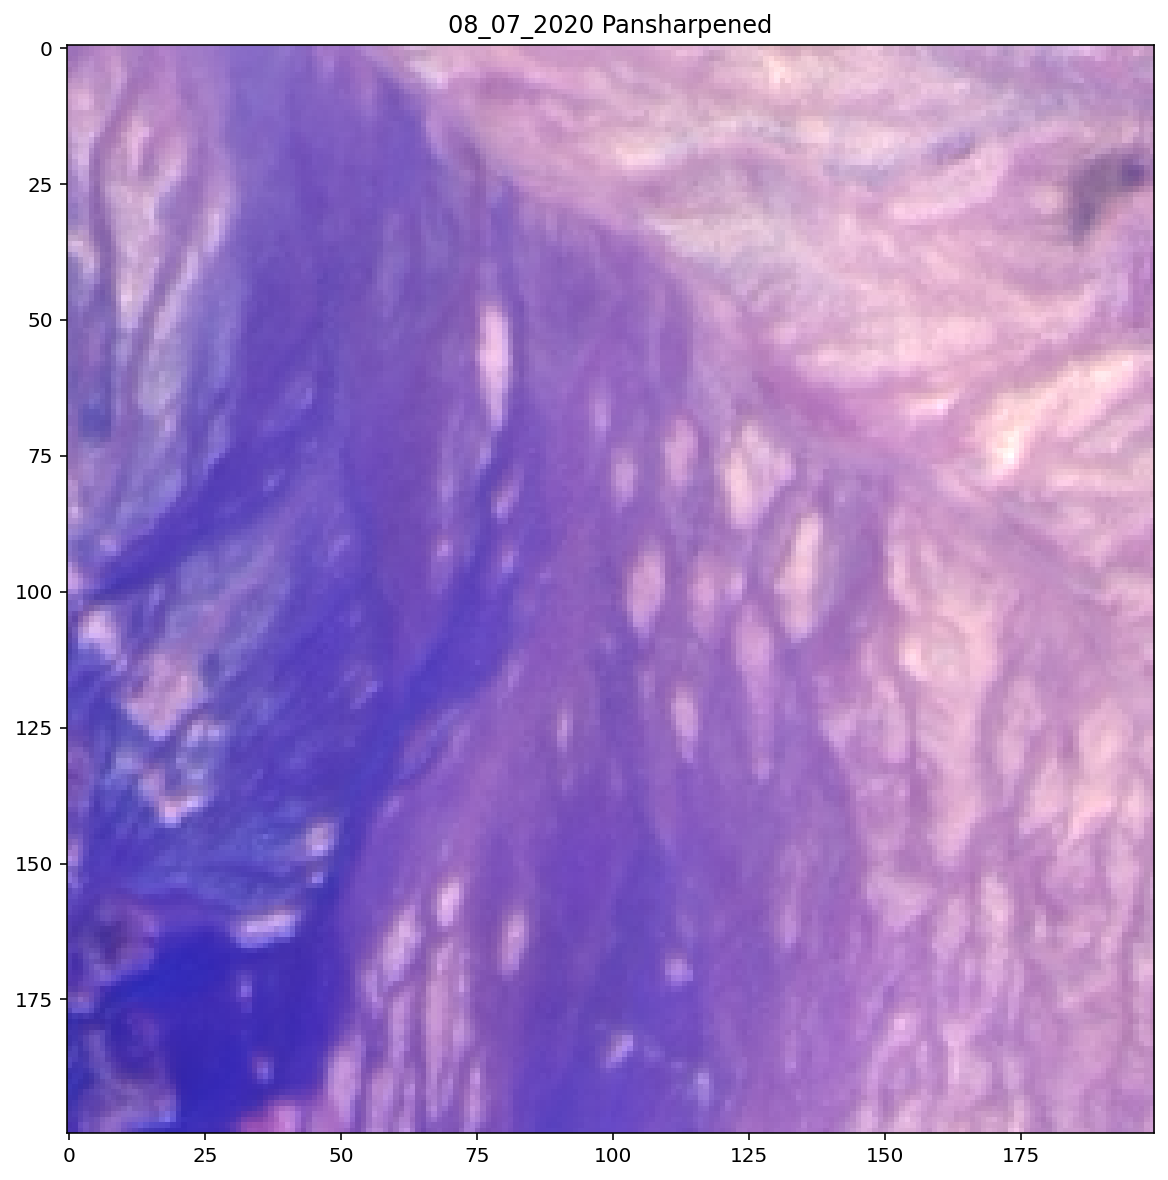

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Array info:
shape: (200, 200, 3)
dtype: float64
min, max: 0.14847059556441558 1.2010680634404596


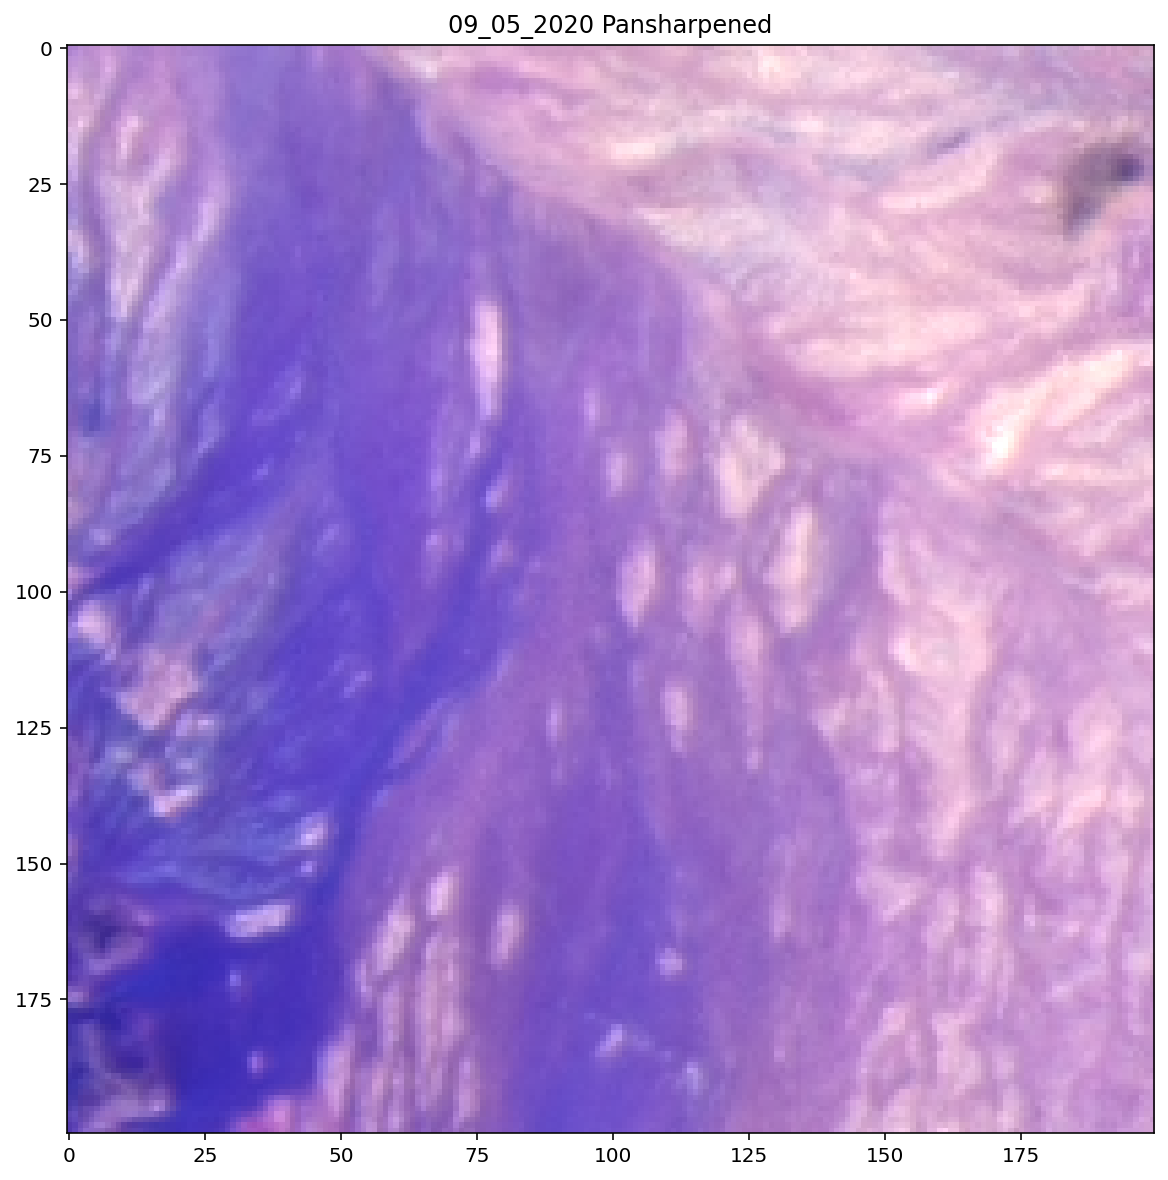

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Array info:
shape: (200, 200, 3)
dtype: float64
min, max: 0.1494868751745324 1.2218093963507615


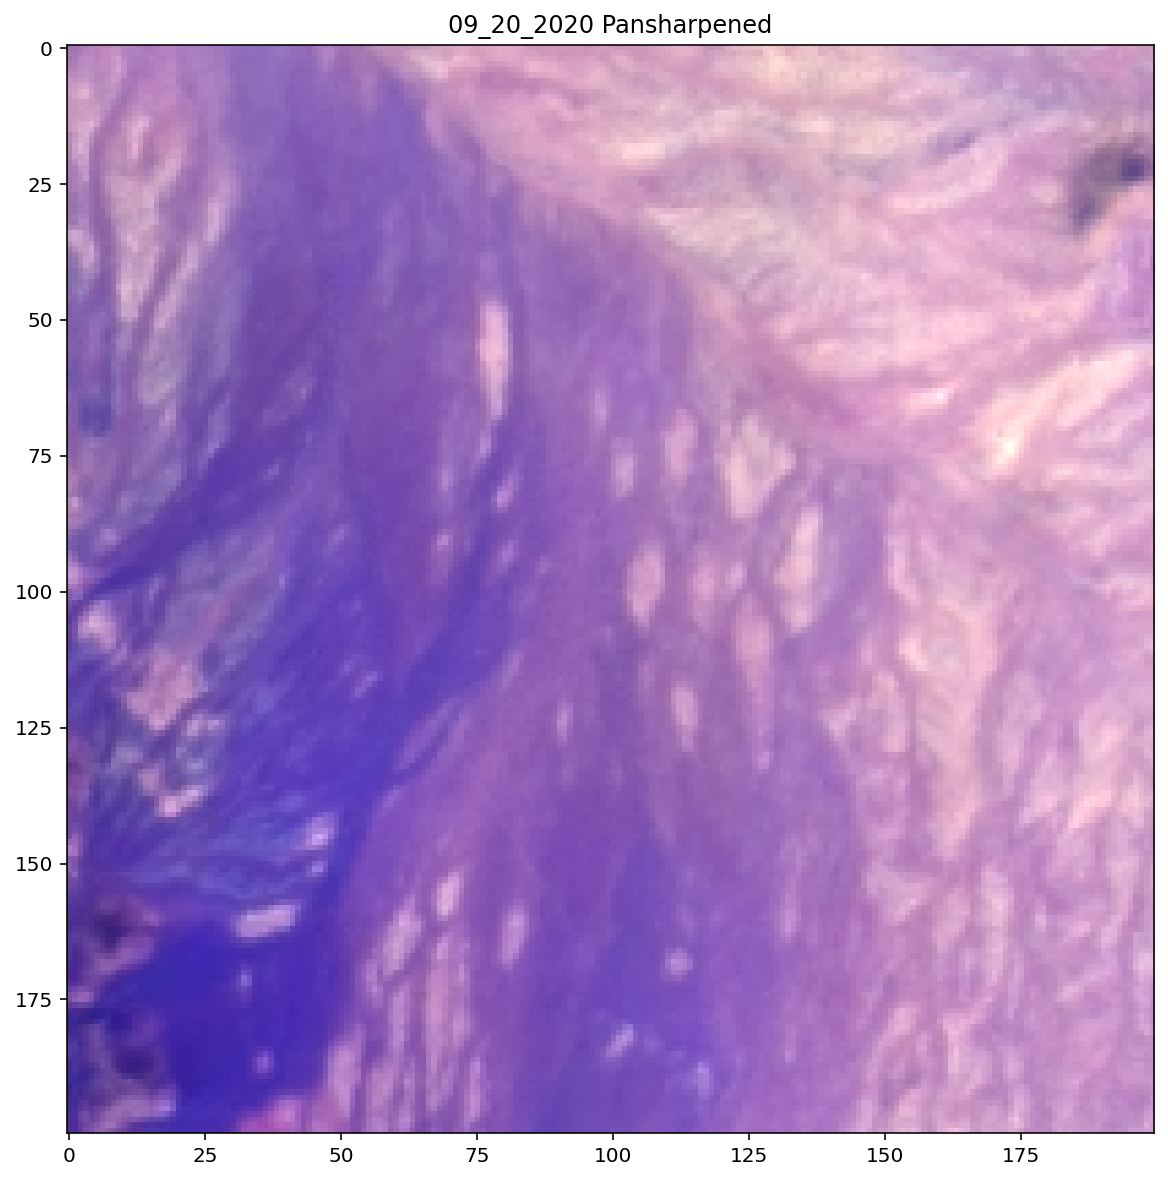

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Array info:
shape: (200, 200, 3)
dtype: float64
min, max: 0.11128246052972167 1.197174329577238


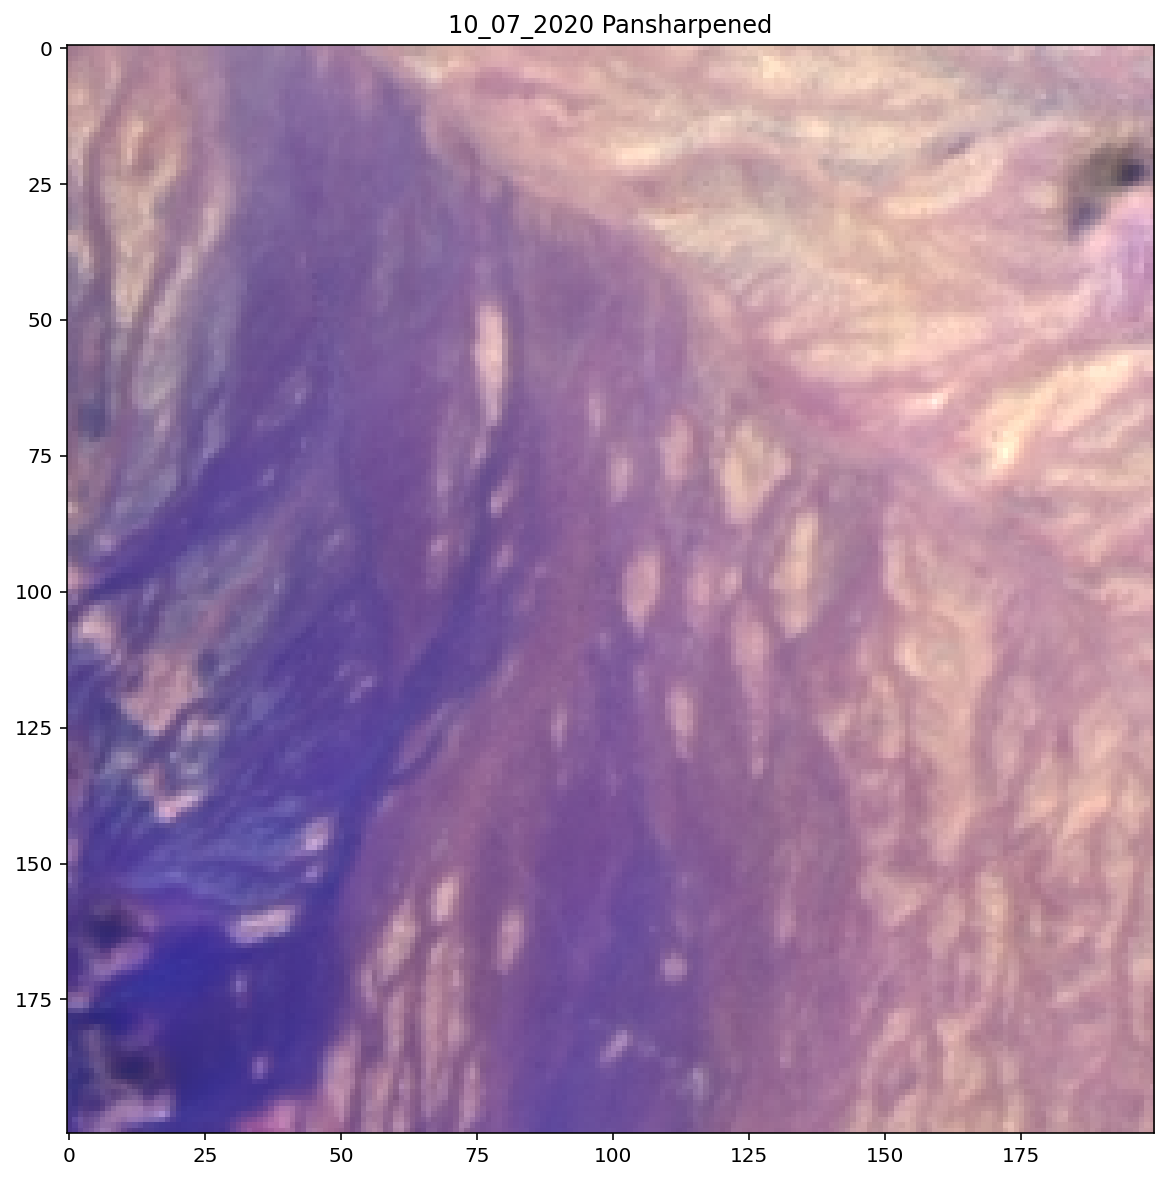

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Array info:
shape: (200, 200, 3)
dtype: float64
min, max: 0.15430238522698136 1.1582692315866658


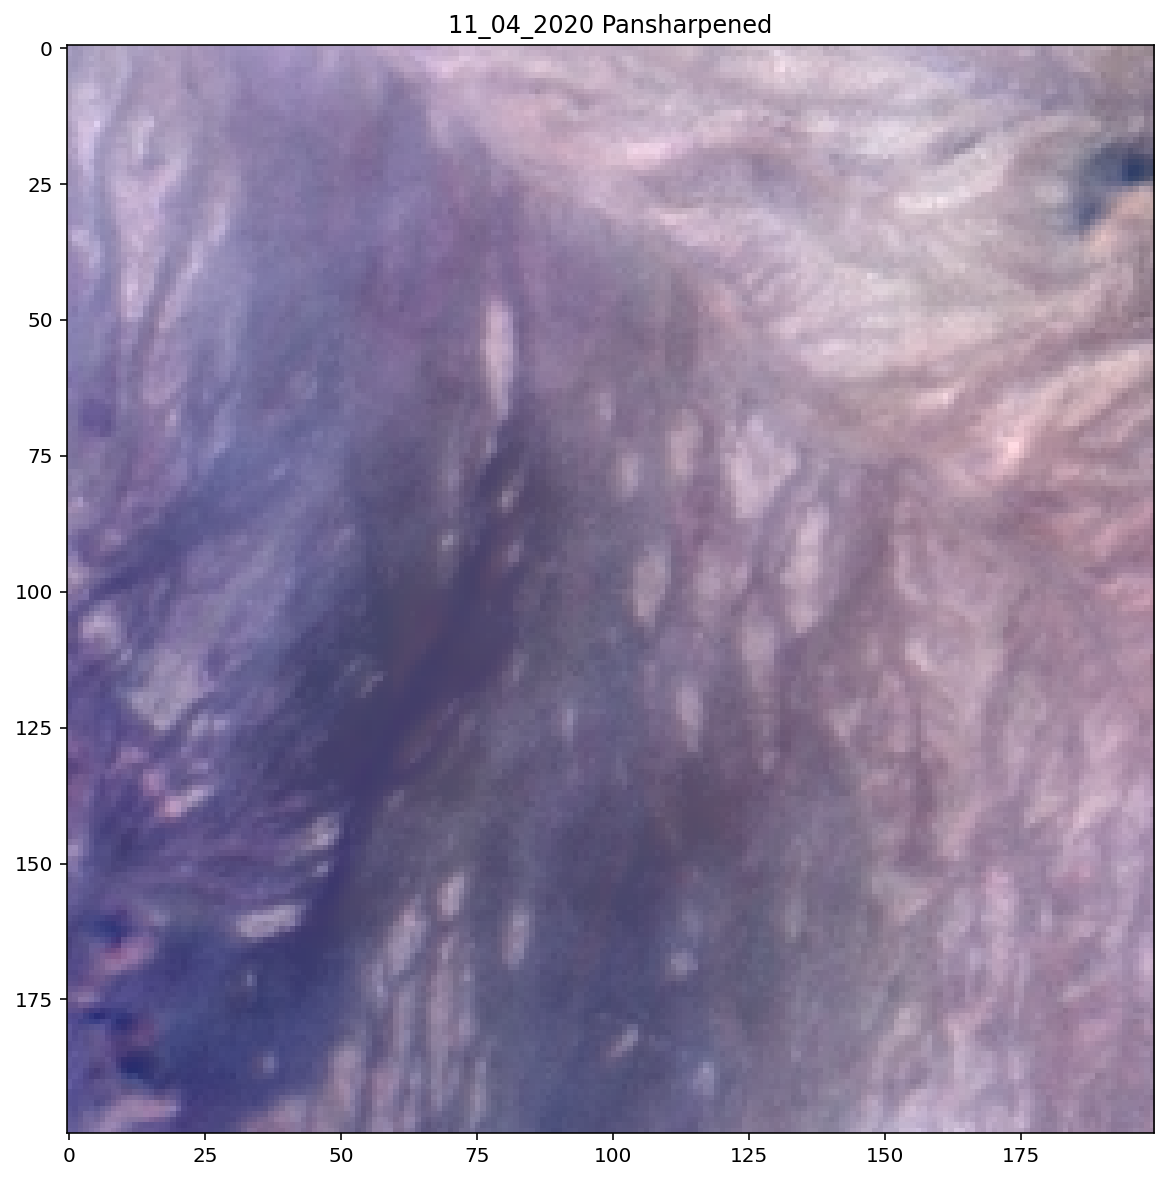

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Array info:
shape: (200, 200, 3)
dtype: float64
min, max: 0.15302249106852844 1.0145676794852658


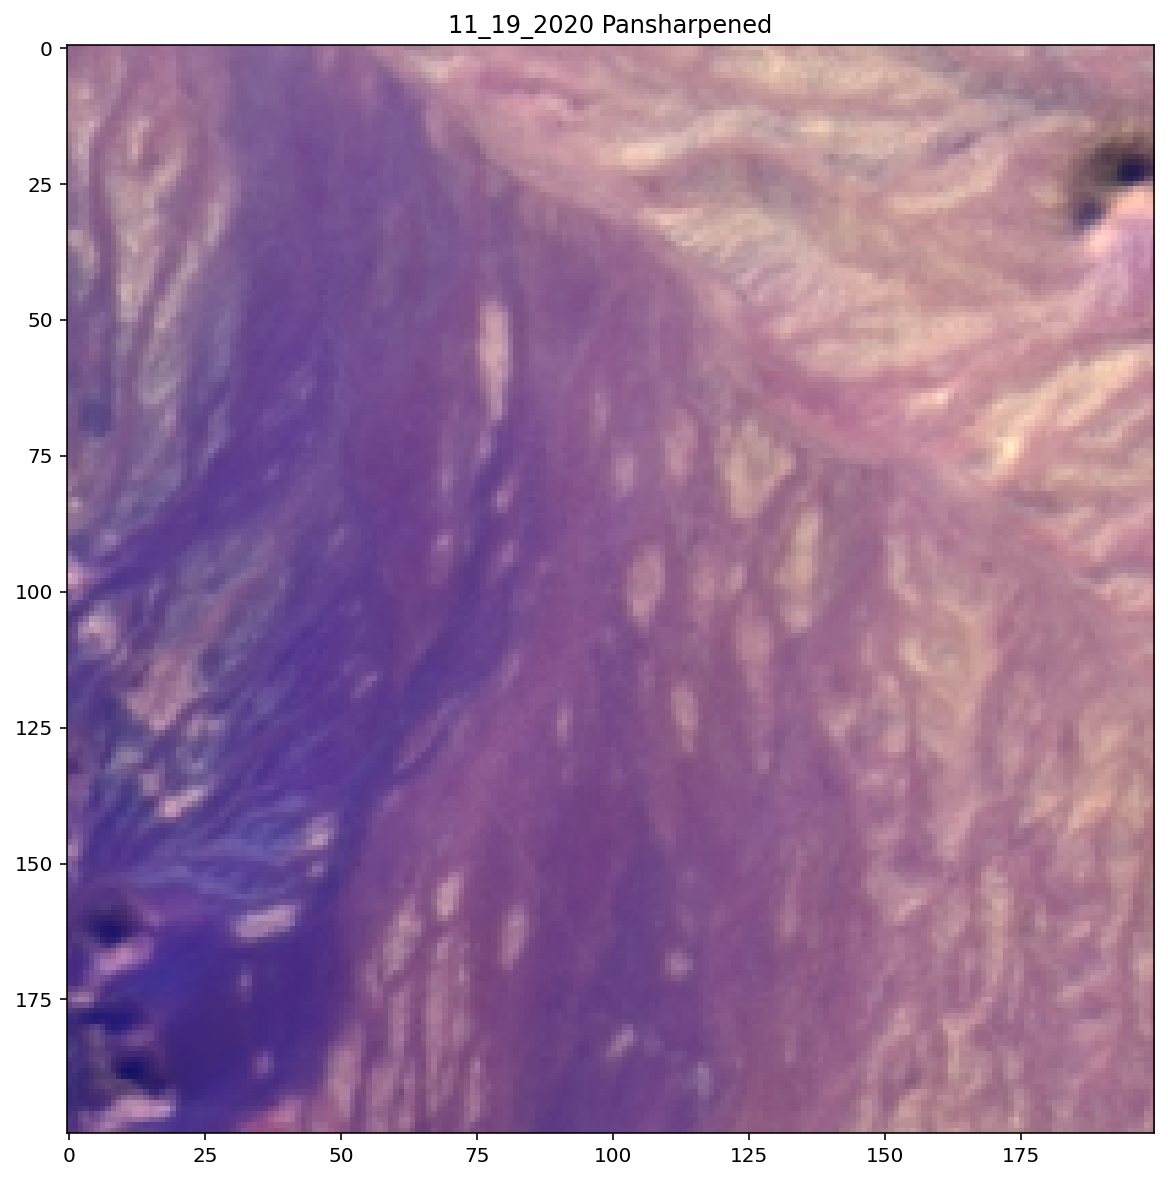

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Array info:
shape: (200, 200, 3)
dtype: float64
min, max: 0.06367097550764028 1.0835894842187608


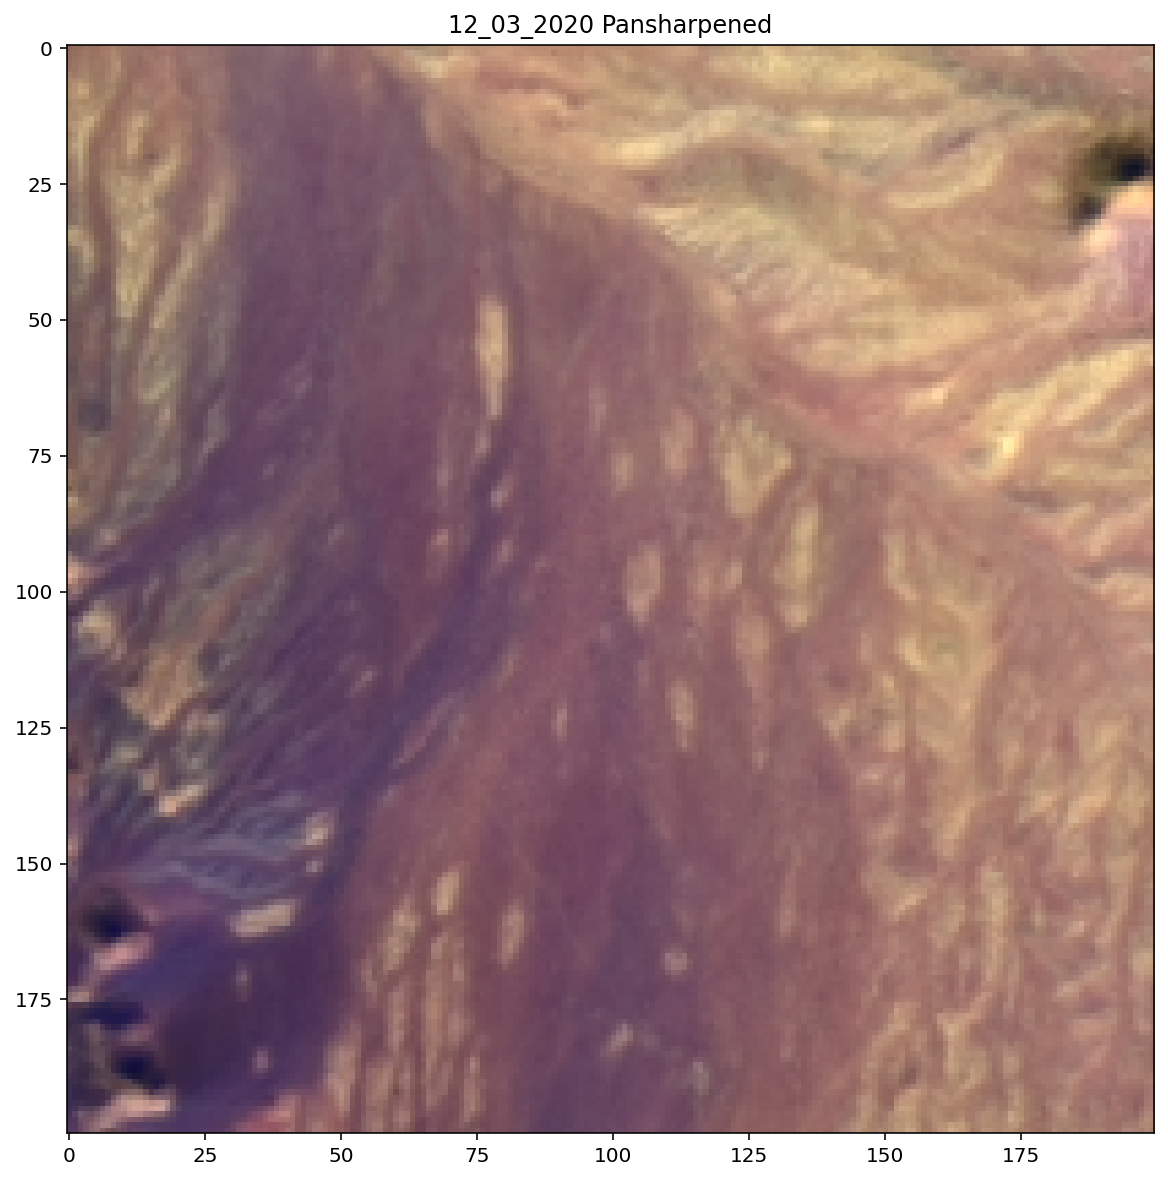

Array info:
shape: (200, 200, 3)
dtype: float64
min, max: 0.056625886119367884 1.0878843967277092


In [20]:
### PANSHARPENING ###

### This cell is used to create the pansharpened images and finally save the desired images locally as npz's so that we don't have to use the full sized Landsat frames every time.
### Once the desired images are saved locally, this entire cell can be commented out.
#-------------------------------------------------------------------------------#
# date0 = '08_07_2020'
# date1 = '08_22_2020'
# date2 = '09_05_2020'
# date3 = '09_20_2020'
# date4 = '10_07_2020'
# date5 = '11_04_2020'
# date6 = '11_19_2020'
# date7 = '12_03_2020'

dates = ['08_07_2020', '08_22_2020', '09_05_2020', '09_20_2020', '10_07_2020', '11_04_2020', '11_19_2020', '12_03_2020']

#----------------------------------------------------#

pansharpened_0 = pansharpening(ls_0_lw_large, ls_0_large)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(pansharpened_0)
plt.title(dates[0] + ' Pansharpened')
#plt.axis('off')
#plt.colorbar()
plt.show()
PrintArrayInfo(pansharpened_0)

#np.savez('pansharpened_0', pansharpened_0)

#----------------------------------------------------#

# ### Skipping this frame due to too much cloud cover

# pansharpened_1 = pansharpening(ls_1_lw_large, ls_1_large)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# plt.imshow(pansharpened_1)
# plt.title(dates[1] + ' Pansharpened')
# #plt.axis('off')
# #plt.colorbar()
# plt.show()
# PrintArrayInfo(pansharpened_1)

# #np.savez('pansharpened_1', pansharpened_1)

#----------------------------------------------------#

pansharpened_2 = pansharpening(ls_2_lw_large, ls_2_large)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(pansharpened_2)
plt.title(dates[2] + ' Pansharpened')
#plt.axis('off')
#plt.colorbar()
plt.show()
PrintArrayInfo(pansharpened_2)

#np.savez('pansharpened_2', pansharpened_2)

#----------------------------------------------------#

pansharpened_3 = pansharpening(ls_3_lw_large, ls_3_large)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(pansharpened_3)
plt.title(dates[3] + ' Pansharpened')
#plt.axis('off')
#plt.colorbar()
plt.show()
PrintArrayInfo(pansharpened_3)

#np.savez('pansharpened_3', pansharpened_3)

#----------------------------------------------------#

pansharpened_4 = pansharpening(ls_4_lw_large, ls_4_large)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(pansharpened_4)
plt.title(dates[4] + ' Pansharpened')
#plt.axis('off')
#plt.colorbar()
plt.show()
PrintArrayInfo(pansharpened_4)

#np.savez('pansharpened_4', pansharpened_4)

#----------------------------------------------------#

pansharpened_5 = pansharpening(ls_5_lw_large, ls_5_large)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(pansharpened_5)
plt.title(dates[5] + ' Pansharpened')
#plt.axis('off')
#plt.colorbar()
plt.show()
PrintArrayInfo(pansharpened_5)

#np.savez('pansharpened_5', pansharpened_5)

#----------------------------------------------------#

pansharpened_6 = pansharpening(ls_6_lw_large, ls_6_large)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(pansharpened_6)
plt.title(dates[6] + ' Pansharpened')
#plt.axis('off')
#plt.colorbar()
plt.show()
PrintArrayInfo(pansharpened_6)

#np.savez('pansharpened_6', pansharpened_6)

#----------------------------------------------------#

pansharpened_7 = pansharpening(ls_7_lw_large, ls_7_large)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(pansharpened_7)
plt.title(dates[7] + ' Pansharpened')
#plt.axis('off')
#plt.colorbar()
plt.show()
PrintArrayInfo(pansharpened_7)

#np.savez('pansharpened_7', pansharpened_7)

#----------------------------------------------------#

#### 4.2.1 Loading in the locally saved pansharpened images

In [21]:
### PANSHARPENING ###

# Load in the locally saved pansharpened images
#-------------------------------------------------------------------------------#
pansharpened_0 = np.load('pansharpened_0'+'.npz')
pansharpened_0 = pansharpened_0['arr_0']

pansharpened_2 = np.load('pansharpened_2'+'.npz')
pansharpened_2 = pansharpened_2['arr_0']

pansharpened_3 = np.load('pansharpened_3'+'.npz')
pansharpened_3 = pansharpened_3['arr_0']

pansharpened_4 = np.load('pansharpened_4'+'.npz')
pansharpened_4 = pansharpened_4['arr_0']

pansharpened_5 = np.load('pansharpened_5'+'.npz')
pansharpened_5 = pansharpened_5['arr_0']

pansharpened_6 = np.load('pansharpened_6'+'.npz')
pansharpened_6 = pansharpened_6['arr_0']

pansharpened_7 = np.load('pansharpened_7'+'.npz')
pansharpened_7 = pansharpened_7['arr_0']
#-------------------------------------------------------------------------------#

#### 4.2.2 Plotting the locally saved pansharpened images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


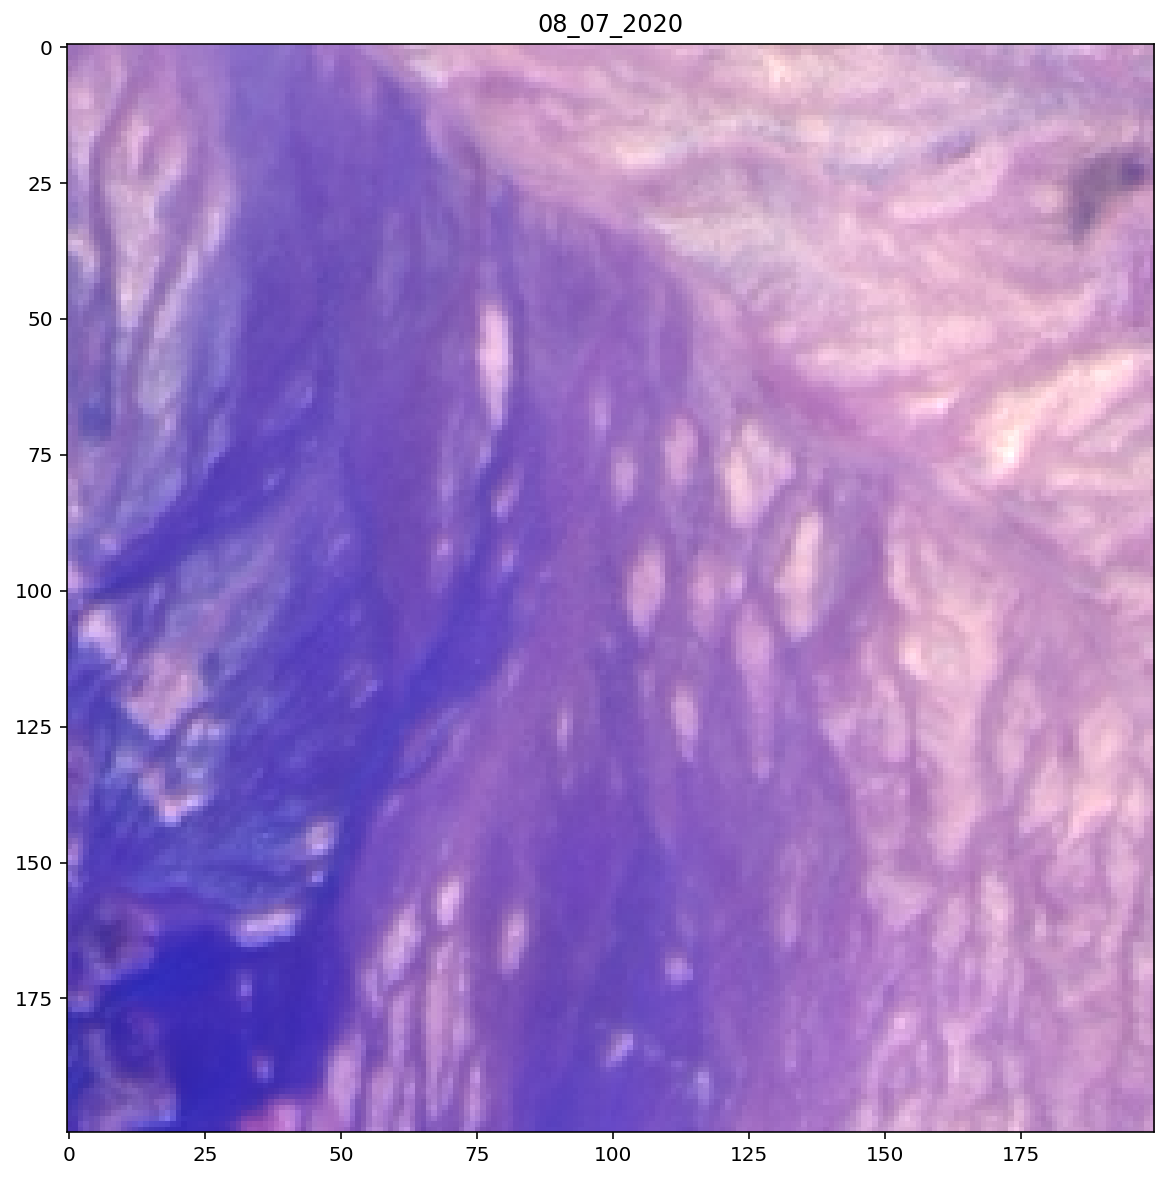

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


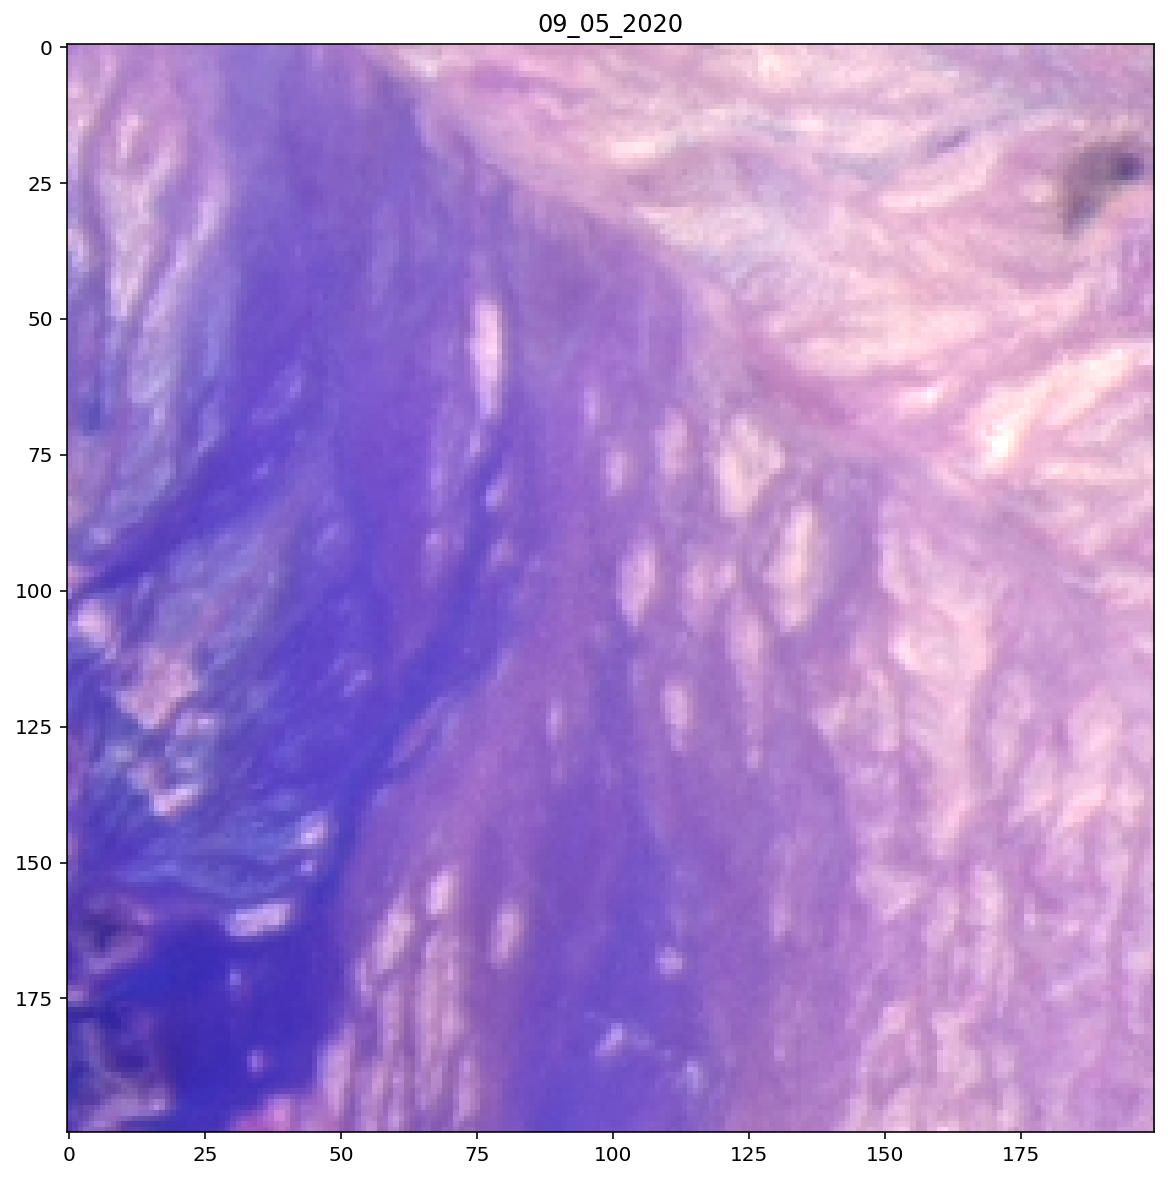

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


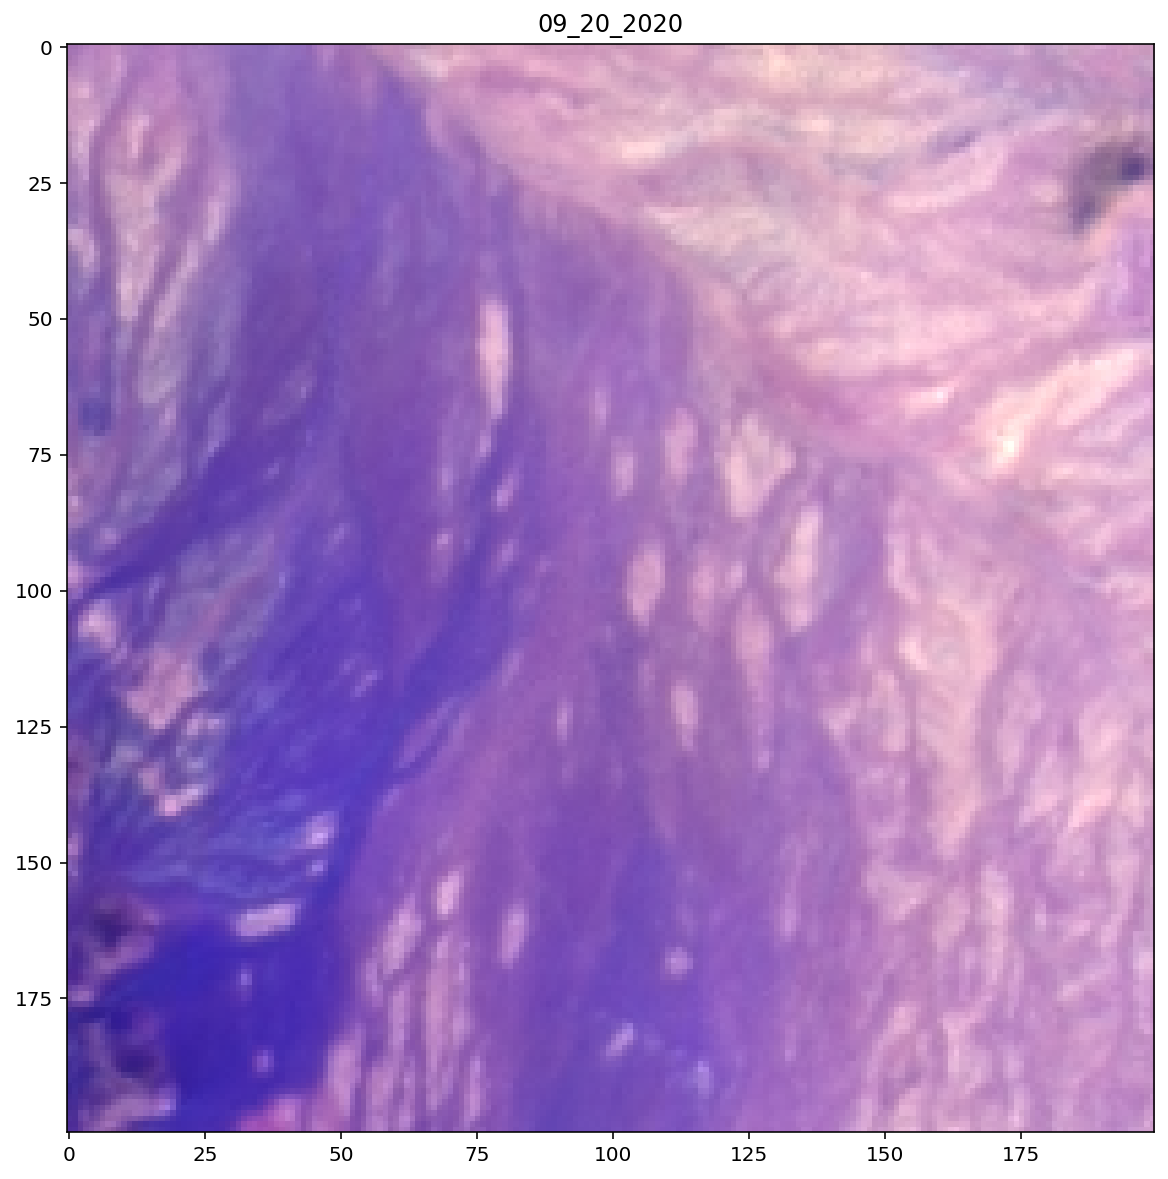

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


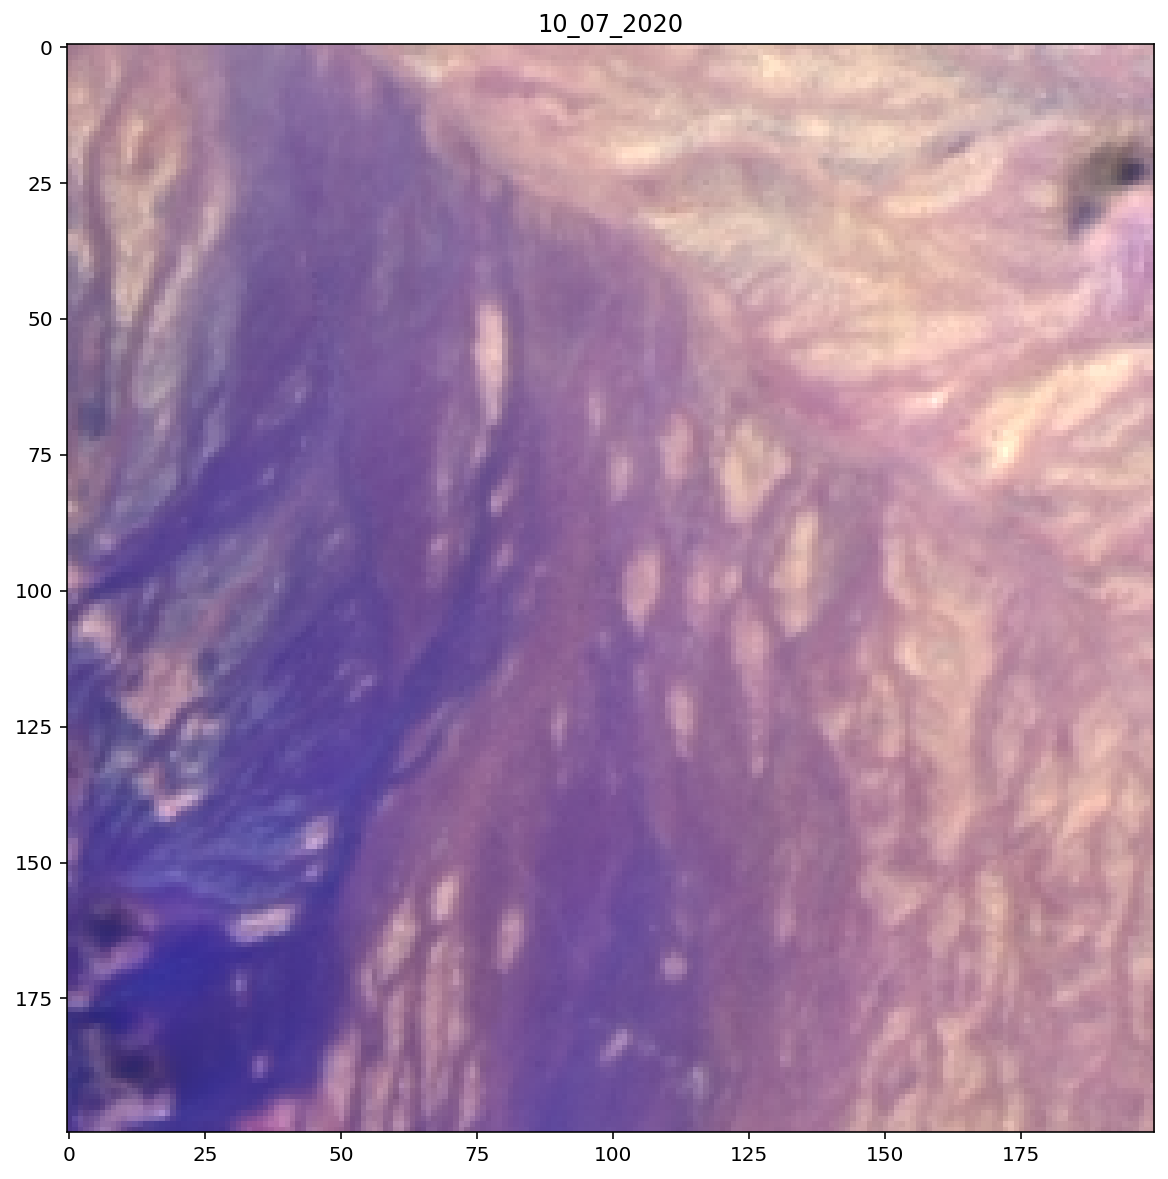

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


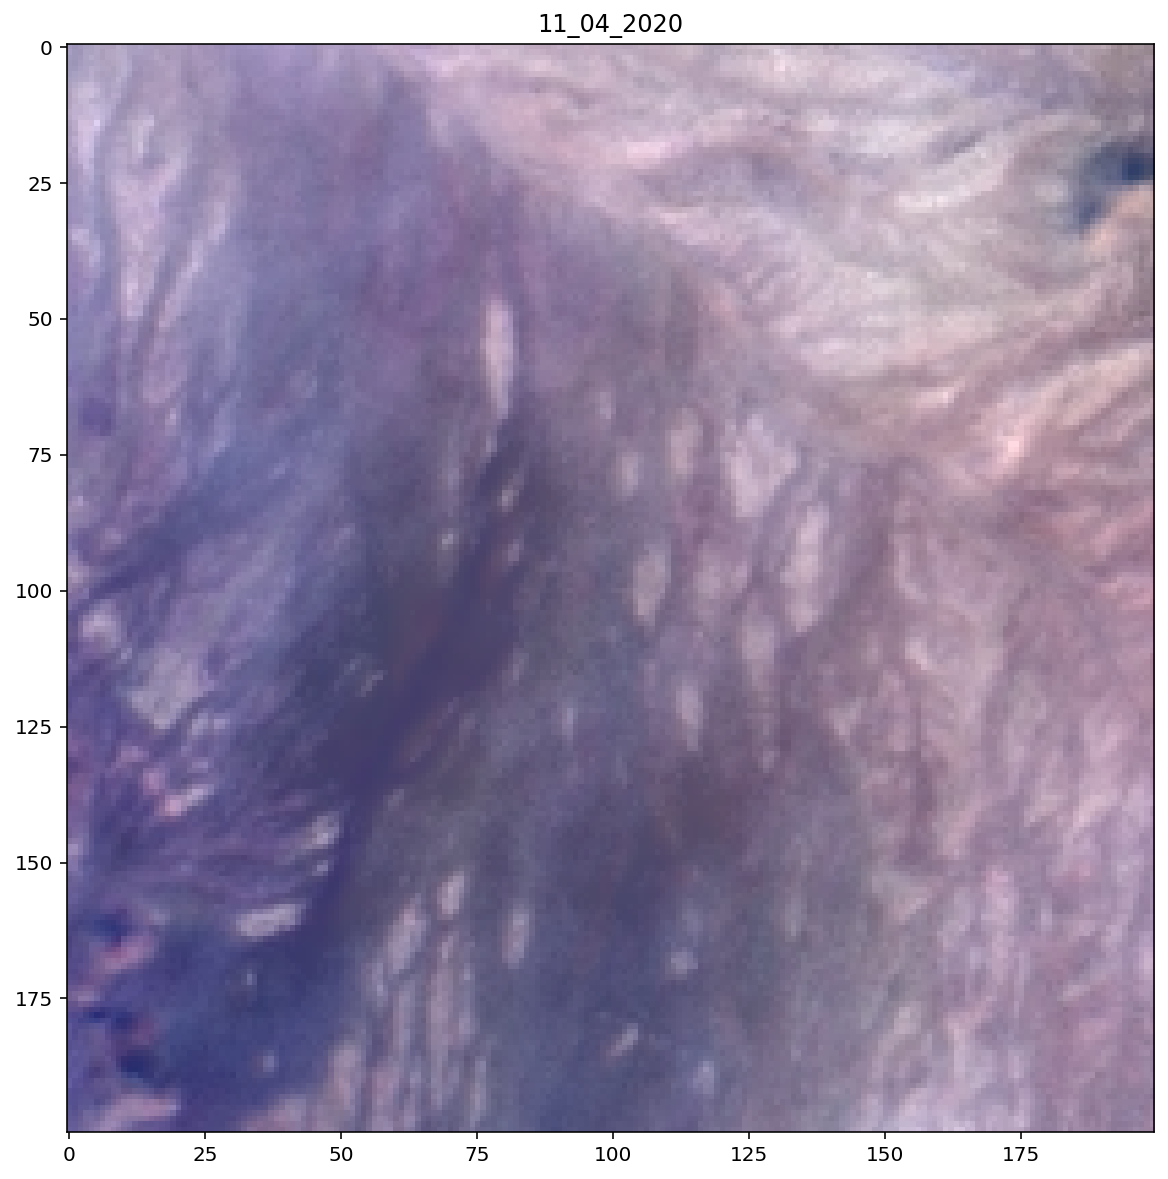

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


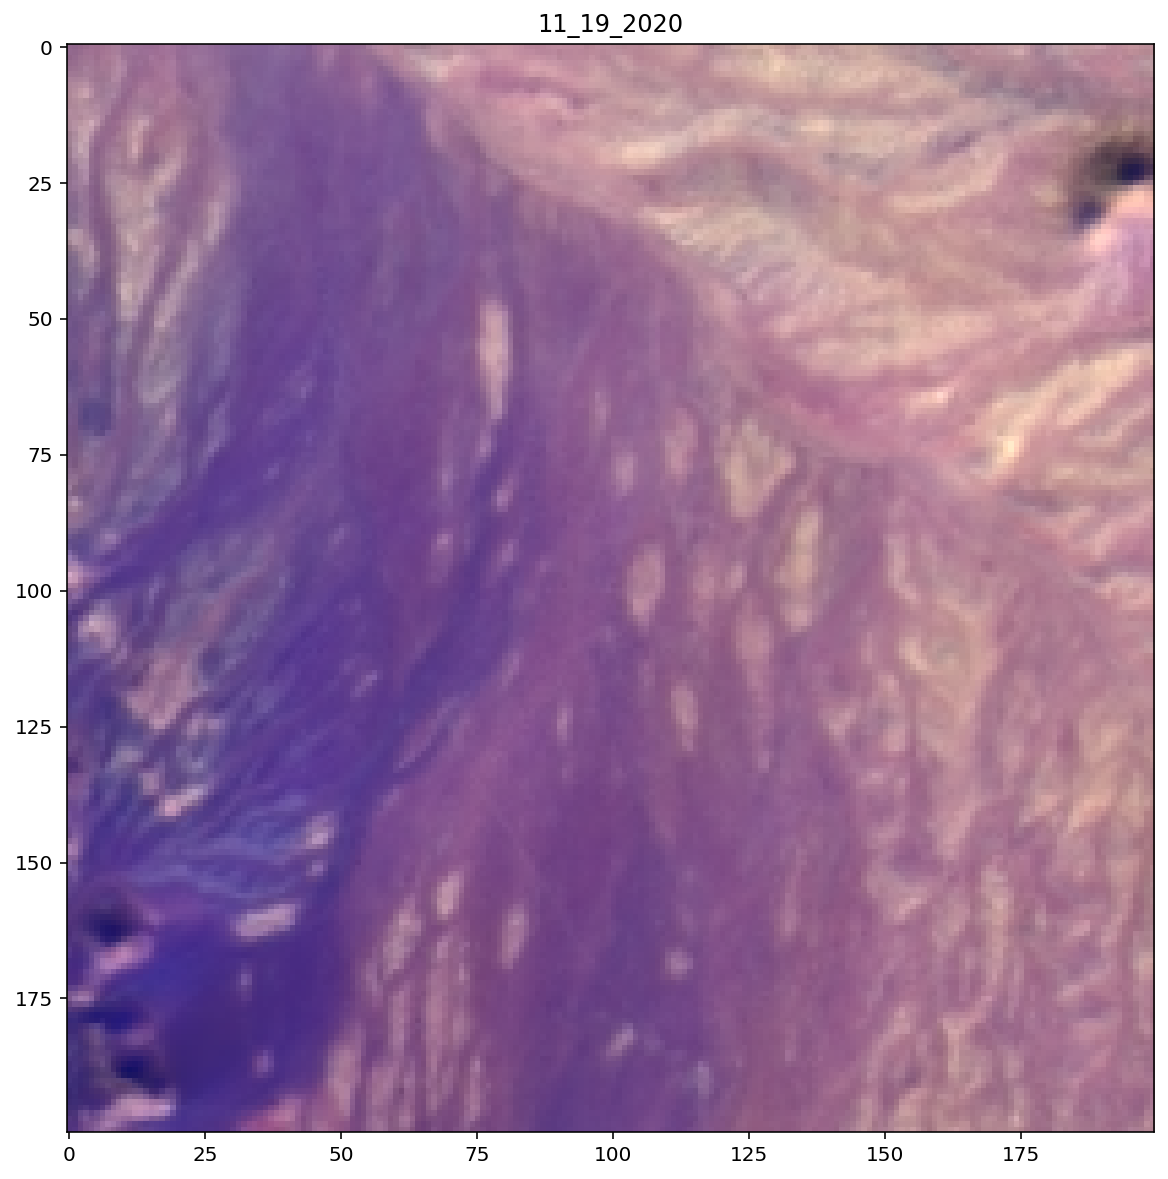

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


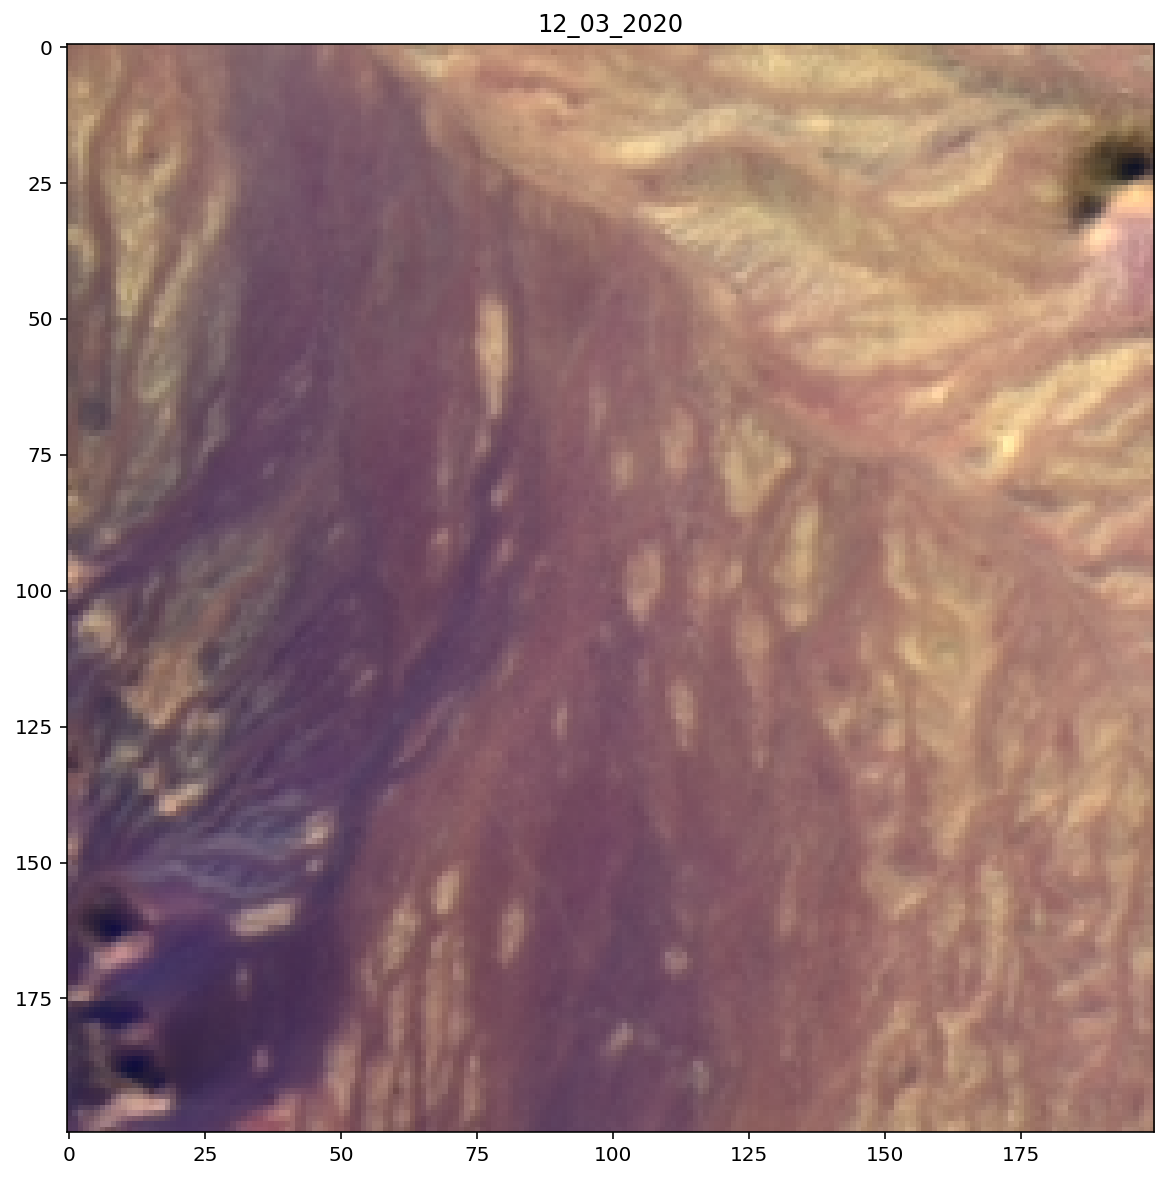

In [22]:
### PANSHARPENING ###

# Plotting the locally saved pansharpened images to test them
# This cell can be commented out if the locally saved images plotted correctly after running this cell, as this is just a way to visually confirm the correct image adjustments.
#-------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(pansharpened_0)
plt.title(dates[0])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(pansharpened_2)
plt.title(dates[2])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(pansharpened_3)
plt.title(dates[3])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(pansharpened_4)
plt.title(dates[4])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(pansharpened_5)
plt.title(dates[5])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(pansharpened_6)
plt.title(dates[6])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plt.axis('off')
plt.imshow(pansharpened_7)
plt.title(dates[7])
plt.show()
#-------------------------------------------------------------------------------#

## 5. Animate the finalized high-res RGB pansharpened images to view changes over time

# <font color=red>WARNING:</font> 
### <font color=red>ONLY RUN THE CELL BELOW ONCE YOU ARE SATISFIED WITH THE RESULTING PANSHARPENED IMAGES SEEN IN SECTION 4.2.2 (above).</font>
### Once you run the cell below, it will overwrite any previous animations you had and you also have to restart your kernal if you want to view the images from the previous sections again *(at least that's what happened on my computer).*

In [24]:
# # Run this cell only when you are happy with the pansharpened images, as running this cell will generate the mp4 animation of them, but force you to restart and clear the output of your kernel in order to view images again.
# # After running this cell and generating the animation, comment it all out so that you can view previous images.

# %matplotlib osx
# %config InlineBackend.figure_format = 'retina'
# from matplotlib.animation import FFMpegWriter
# metadata = dict(title='Long-Wave IR Pansharpened Search', artist='Matplotlib',comment='LW-IR.')
# writer = FFMpegWriter(fps=1, metadata=metadata,bitrate=200000)
# fig = plt.figure(dpi=300)

# lw_ir_pan_arr = [pansharpened_0, pansharpened_2, pansharpened_3, pansharpened_4, pansharpened_5, pansharpened_6, pansharpened_7]
# dates = ['08_07_2020', '09_05_2020', '09_20_2020', '10_07_2020', '11_04_2020', '11_19_2020', '12_03_2020']

# with writer.saving(fig, "long_wave_ir_pansharpened.mp4", dpi=300):
    
#     for i in lw_ir_pan_arr:
        

#         #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#         #plt.axis('off')
#         plt.imshow(i)
#         #plt.axis('off')
        
#         plt.show()
#         plt.draw()
#         #plt.title('Pansharpened Image')
#         #plt.colorbar()
    
#         plt.pause(5)
        
#         i += 1
#         writer.grab_frame()
#         plt.clf()      

# $II-$ ASTRA High Altitude Balloon (HAB) Monte Carlo Predictor Section

# Necessary packages for the ASTRA HAB predictor 

In [ ]:
### For ASTRA balloon predictions ###
# Comment out this cell if you are not using the ASTRA HAB predictor, as explained in Section 3.3 of the READ ME.
#-------------------------------------------------------------------------------#
import astra
from astra.target_landing import targetFlight
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
from astra.weather import forecastEnvironment
import os
from astra.GFS import GFS_Handler
#-------------------------------------------------------------------------------#

# <font color=magenta>*ASTRA balloon predictions (in the cells below)*</font>

## 1. Getting GFS weather data

In [ ]:
GFS_Handler.weatherParameters

## 2. Input the desired flight parameters number of simulations to run, then execute the simulator in the cell below

## <font color=red>IMPORTANT NOTE:</font>
### <font color=red>I have commented the simulator cell out, because I was happy with my simulation results and if I run the simulator again, it will overwrite the previous results. However, feel free to uncomment the cell below and run your own simulations!</font>
### *The final prediction outputs will appear in a folder titled "astra_output" in the same directory as this notebook is in. In there, you can find Google Earth, JSON, and CSV files containing the flight predictions.*

In [ ]:
# ### ASTRA High Altitude Balloon (HAB) Monte Carlo Predictor ###

# ### Once this has been run, comment it out so that the simulation doesn't overwrite the previous results. ###
# ### The prediction outputs will appear in a folder titled "astra_output".

# """
# example_forecast.py
# ASTRA High Altitude Balloon Flight Planner

# DESCRIPTION
# --------------

# Example: Forecast based Simulation

# University of Southampton
# Niccolo' Zapponi, nz1g10@soton.ac.uk, 22/04/2013

# Modified and adapted for the Zephyrus XI HAB payload by:
# Hunter Hall
# University of California, Berkeley
# hall@berkeley.edu
# December, 2020

# """
# import logging
# import numpy as np
# logging.basicConfig(level=logging.DEBUG)

# if __name__ == "__main__":
#     from datetime import datetime, timedelta
#     from astra.simulator import *

#     np.random.seed(62)

#     # Environment parameters
#     # Launch site: Apple Valley, CA
#     #        time: August 13, 3pm PDT
#     #         lat: 34.60209
#     #         lon: -117.159
#     #   elevation: 989 m
#     #     payload: 3.75 kg
#     #        lift: 4 kg
    
#     launch_datetime = datetime.now() + timedelta(days=+4.005556)
#     print(type(launch_datetime))
#     simEnvironment = forecastEnvironment(launchSiteLat=34.60209,      # deg
#                                          launchSiteLon=-117.159,     # deg
#                                          launchSiteElev=989,           # m
#                                          dateAndTime=launch_datetime,
#                                          forceNonHD=True,
#                                          debugging=True)

#     # Launch setup
#     simulator = flight(environment=simEnvironment,
#                        balloonGasType='Helium',
#                        balloonModel='TA1500',
#                        nozzleLift=4,                                # kg
#                        payloadTrainWeight=3.75,                    # kg
#                        parachuteModel='SPH100',
#                        numberOfSimRuns=100,
#                        trainEquivSphereDiam=.1,                    # m
#                        floatingFlight=False,
#                        excessPressureCoeff=1,
#                        outputFile=os.path.join('.', 'astra_output'),
#                        debugging=True,
#                        log_to_file=True)

#     # simFlight.maxFlightTime = 5*60*60

#     # Run the simulation
#     simulator.run()
